In [2]:
import os
import shutil
import numpy as np
import pandas as pd

In [3]:
pip install split-folders

Note: you may need to restart the kernel to use updated packages.


In [4]:
path="/kaggle/working/"
os.makedirs(os.path.join(path,'data'),exist_ok=True)

In [5]:
# path='/kaggle/working/data'
# for i in range(1,125):
#     os.makedirs(os.path.join(path,str(i)),exist_ok=True)
#     os.makedirs(os.path.join(path,str(i),'bg'),exist_ok=True)
#     os.makedirs(os.path.join(path,str(i),'cl'),exist_ok=True)
#     os.makedirs(os.path.join(path,str(i),'nm'),exist_ok=True)

# create only bg and nm folders
path='/kaggle/working/data'
os.makedirs(os.path.join(path,'bg'),exist_ok=True)
os.makedirs(os.path.join(path,'nm'),exist_ok=True)



In [6]:
def organize_folders(root_folder, dest_folder):
    
    for split_folder in ['test', 'train', 'val']:
        split_path = os.path.join(root_folder, split_folder)

        for subfolder in os.listdir(split_path):
            subfolder_path = os.path.join(split_path, subfolder)
            dest_path = os.path.join(dest_folder, subfolder)

            for image_file in os.listdir(subfolder_path):
                source_path = os.path.join(subfolder_path, image_file)

                if 'bg' in image_file:
                    destination_folder = 'bg'
                elif 'cl' in image_file:
#                     destination_folder = 'cl'
                    continue
                elif 'nm' in image_file:
                    destination_folder = 'nm'
#                 print(image_file)
                # Constructing the destination path using os.path.join
                destination_path = os.path.join(dest_folder, destination_folder, os.path.basename(image_file))
                shutil.copy(source_path, destination_path)

# Example usage
root_folder = "/kaggle/input/casiab-identification/DATASETidentification"
dest_folder = "/kaggle/working/data/"
organize_folders(root_folder, dest_folder)

In [7]:
import os
import shutil
import splitfolders

input_folder = '/kaggle/working/data'
output_folder = '/kaggle/working/use'
ratio = (0.7, 0.3)

splitfolders.ratio(input_folder, output=output_folder, seed=1337, ratio=ratio, group_prefix=None)

train_folder = os.path.join(output_folder, 'train')
test_folder = os.path.join(output_folder, 'val')

for subfolder in os.listdir(input_folder):
    subfolder_path = os.path.join(input_folder, subfolder)
    if os.path.isdir(subfolder_path):
        for category in os.listdir(subfolder_path):
            category_path = os.path.join(subfolder_path, category)
            if os.path.isdir(category_path):
                train_category_path = os.path.join(train_folder, subfolder, category)
                test_category_path = os.path.join(test_folder, subfolder, category)
                os.makedirs(train_category_path, exist_ok=True)
                os.makedirs(test_category_path, exist_ok=True)
                train_files = os.listdir(category_path)[:int(len(os.listdir(category_path))*0.7)]
                test_files = os.listdir(category_path)[int(len(os.listdir(category_path))*0.7):]
                for file in train_files:
                    shutil.move(os.path.join(category_path, file), os.path.join(train_category_path, file))
                for file in test_files:
                    shutil.move(os.path.join(category_path, file), os.path.join(test_category_path, file))


Copying files: 10872 files [00:01, 5944.97 files/s]


# TRAINING PHASE

In [8]:
#Generator architecture

import torch
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(Generator, self).__init__()
     
        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64), 
            nn.ReLU(),

            nn.ConvTranspose2d(64, output_channels, kernel_size=3, stride=1, padding=1),
            nn.Tanh(), 
        )


    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        return x


In [9]:
#Discriminator
import torch
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self, input_channels):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.Conv2d(512, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


In [10]:
g=Generator(1,1)
d=Discriminator(1)
dummy = torch.randn(1, 1, 64, 64)
out_gen=g(dummy)
out_disc=d(dummy)
print(out_gen.shape,out_disc.shape)

torch.Size([1, 1, 64, 64]) torch.Size([1, 1, 2, 2])


In [11]:
import os
import numpy as np
from PIL import Image
from torch.utils.data import Dataset

class BagNormalDataset(Dataset):
    def __init__(self,rootbag,rootnormal,transforms=None):
        self.rootbag=rootbag
        self.rootnormal=rootnormal
        self.transforms=transforms
        
        self.bag_images=os.listdir(rootbag)
        self.normal_images=os.listdir(rootnormal)
        self.length=max(len(self.bag_images),len(self.normal_images))
        self.bag_len=len(self.bag_images)
        self.normal_len=len(self.normal_images)
    
    def __len__(self):
        return self.length
    
    def __getitem__(self,index):
        bag_image=self.bag_images[index%self.bag_len]
        normal_image=self.normal_images[index%self.normal_len]
        
        bag_path=os.path.join(self.rootbag,bag_image)
        normal_path=os.path.join(self.rootnormal,normal_image)
        
        bag_image=np.array(Image.open(bag_path))
        normal_image=np.array(Image.open(normal_path))
        
        if self.transforms:
            # Convert NumPy arrays back to PIL Images
            bag_image_pil = Image.fromarray(bag_image)
            normal_image_pil = Image.fromarray(normal_image)

            # Apply transformations separately for each image
            bag_image_pil = self.transforms(bag_image_pil)
            normal_image_pil = self.transforms(normal_image_pil)

            # Convert augmented images back to NumPy arrays
            bag_image = np.array(bag_image_pil)
            normal_image = np.array(normal_image_pil)

        return bag_image,normal_image

In [12]:
data=BagNormalDataset(rootbag='/kaggle/working/use/train/bg',rootnormal='/kaggle/working/use/train/nm')
len(data)

5707

In [13]:
# #sample data

import matplotlib.pyplot as plt
import torchvision.transforms as transforms
def displayImage(x):
    x=x[0].cpu()
    image_bag = (x.permute(1,2,0).detach().numpy() * 255).astype('uint8')
    plt.imshow(image_bag)
    plt.show()


In [14]:
#DiscoGAN structure

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from itertools import chain
from torchvision.datasets import ImageFolder

# Define the DiscoGAN model
class DiscoGAN(nn.Module):
    def __init__(self, generator_AB, generator_BA, discriminator_A, discriminator_B):
        super(DiscoGAN, self).__init__()
        self.generator_AB = generator_AB
        self.generator_BA = generator_BA
        self.discriminator_A = discriminator_A
        self.discriminator_B = discriminator_B

    def forward(self, real_A, real_B):
        fake_B = self.generator_AB(real_A)
        rec_A = self.generator_BA(fake_B)
        fake_A = self.generator_BA(real_B)
        rec_B = self.generator_AB(fake_A)

        return fake_B, rec_A, fake_A, rec_B

    
# Adversarial loss (BCE loss)
adv_loss = nn.MSELoss()

# Reconstruction loss (L1 loss)
recon_loss = nn.L1Loss()

feat_criterion = nn.HingeEmbeddingLoss()

# Initialize models
input_channels = 1  # Grayscale input
output_channels = 1  # Grayscale output
generator_AB = Generator(input_channels, output_channels)
generator_BA = Generator(input_channels, output_channels)
discriminator_A = Discriminator(input_channels)
discriminator_B = Discriminator(input_channels)

gen_params = chain(generator_AB.parameters(), generator_BA.parameters())
dis_params = chain(discriminator_A.parameters(), discriminator_B.parameters())

    
discoGAN = DiscoGAN(generator_AB, generator_BA, discriminator_A, discriminator_B)

opt_gen = optim.Adam( gen_params, lr=0.00001, betas=(0.5,0.999), weight_decay=0.00001)
opt_disc = optim.Adam( dis_params, lr=0.00001, betas=(0.5,0.999), weight_decay=0.00001)

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Grayscale(),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])
dataset=BagNormalDataset(rootbag='/kaggle/working/use/train/bg',rootnormal='/kaggle/working/use/train/nm',transforms=transform)
train_loader=DataLoader(dataset,batch_size=16,shuffle=True,num_workers=2)


In [15]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device,torch.cuda.get_device_name(0))

generator_AB.to(device)
generator_BA.to(device)
discriminator_A.to(device)
discriminator_B.to(device)
discoGAN.to(device)


cuda Tesla T4


DiscoGAN(
  (generator_AB): Generator(
    (encoder): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2)
      (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): LeakyReLU(negative_slope=0.2)
      (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): LeakyReLU(negative_slope=0.2)
      (8): Dropout(p=0.2, inplace=False)
      (9): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): LeakyReLU(negative_slope=0.2)
    )
    (decoder): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNo

In [16]:
image = next(iter(train_loader))
image[0].shape

torch.Size([16, 1, 64, 64])

In [17]:
import os
os.makedirs("/kaggle/working/saved",exist_ok=True)
print(os.listdir("/kaggle/working/"))

['saved', 'data', 'use', '.virtual_documents']


In [19]:
from tqdm import tqdm
from torch.autograd import Variable
from torchvision.utils import save_image

total_loss_D = 0.0
total_loss_G = 0.0

num_epochs = 10 

for epoch in range(num_epochs):
    loop = tqdm(train_loader, leave=True)
    for idx, (A, B) in enumerate(loop):
        torch.cuda.empty_cache()

        A = A.to(device)
        B = B.to(device)

        real_label = 1
        fake_label = 0

        BA, ABA, AB, BAB = discoGAN(A, B)
        
        real_tensor = Variable(torch.FloatTensor(A.size(0), 1, 2, 2).fill_(real_label).cuda())
        fake_tensor = Variable(torch.FloatTensor(A.size(0), 1, 2, 2).fill_(fake_label).cuda())
        
        # TRAIN GENERATOR
        generator_AB.zero_grad()
        generator_BA.zero_grad()
        opt_gen.zero_grad()

        rec_loss_A = recon_loss(ABA, A)
        rec_loss_B = recon_loss(BAB, B)        
        
        loss_adv_AB = adv_loss(discriminator_B(AB), real_tensor).to(device)
        loss_adv_BA = adv_loss(discriminator_A(BA), real_tensor).to(device)
        
        total_G_loss = loss_adv_AB + loss_adv_BA + rec_loss_A + rec_loss_B
        total_G_loss.backward()
        opt_gen.step()
        
        # TRAIN DISCRIMINATOR
        discriminator_A.zero_grad()
        discriminator_B.zero_grad()
        opt_disc.zero_grad()

        loss_DB_real = adv_loss(discriminator_B(B), real_tensor).to(device)
        loss_DB_fake = adv_loss(discriminator_B(AB.detach()), fake_tensor).to(device)
        
        loss_DA_real = adv_loss(discriminator_A(A), real_tensor).to(device)
        loss_DA_fake = adv_loss(discriminator_A(BA.detach()), fake_tensor).to(device)
        
        total_D_loss = loss_DB_real + loss_DB_fake + loss_DA_real + loss_DA_fake
        
        total_D_loss.backward(retain_graph=True)
        opt_disc.step()
        
#         print(f'\nDiscriminator A Real Output: {discriminator_A(A).mean().item()}, Fake Output: {discriminator_A(BA.detach()).mean().item()}')
#         print(f'Discriminator B Real Output: {discriminator_B(B).mean().item()}, Fake Output: {discriminator_B(AB.detach()).mean().item()}')
#         print(f'Loss Components: Adv_AB {loss_adv_AB.item()}, Rec_A {rec_loss_A.item()}, Adv_BA {loss_adv_BA.item()}, Rec_B {rec_loss_B.item()}')
#         print(f'Discriminator Loss: {total_D_loss.item()}, Generator Loss: {total_G_loss.item()}\n')
#         if idx % 100 == 0:
#             displayImage(A)
#             displayImage(B)
#             displayImage(AB)
#             displayImage(BA)

    # Print or log losses for monitoring during training
    print(f'Epoch [{epoch + 1}/{num_epochs}], Discriminator Loss: {total_D_loss.item()}, Generator Loss: {total_G_loss.item()}')
    save_image(BA,f'/kaggle/working/saved/{epoch}_bag.png')
    save_image(AB,f'/kaggle/working/saved/{epoch}_normal.png')
    

        




  0%|          | 0/357 [00:00<?, ?it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  1%|          | 2/357 [00:01<04:45,  1.24it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  1%|          | 3/357 [00:02<04:08,  1.42it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  1%|          | 4/357 [00:03<03:51,  1.52it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  1%|▏         | 5/357 [00:03<03:41,  1.59it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  2%|▏         | 6/357 [00:04<03:34,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  2%|▏         | 7/357 [00:04<03:30,  1.66it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  2%|▏         | 8/357 [00:05<03:27,  1.68it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  3%|▎         | 9/357 [00:05<03:24,  1.70it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  3%|▎         | 10/357 [00:06<03:23,  1.71it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  3%|▎         | 11/357 [00:07<03:22,  1.71it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  3%|▎         | 12/357 [00:07<03:21,  1.71it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  4%|▎         | 13/357 [00:08<03:19,  1.72it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  4%|▍         | 14/357 [00:08<03:19,  1.72it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  4%|▍         | 16/357 [00:09<03:18,  1.72it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  5%|▍         | 17/357 [00:10<03:17,  1.72it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  5%|▌         | 18/357 [00:11<03:17,  1.72it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  5%|▌         | 19/357 [00:11<03:16,  1.72it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  6%|▌         | 20/357 [00:12<03:16,  1.72it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  6%|▌         | 21/357 [00:12<03:15,  1.72it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  6%|▌         | 22/357 [00:13<03:15,  1.71it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  6%|▋         | 23/357 [00:14<03:14,  1.72it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  7%|▋         | 24/357 [00:14<03:14,  1.71it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  7%|▋         | 25/357 [00:15<03:14,  1.71it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  7%|▋         | 26/357 [00:15<03:13,  1.71it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  8%|▊         | 27/357 [00:16<03:13,  1.71it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  8%|▊         | 28/357 [00:16<03:13,  1.70it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  8%|▊         | 29/357 [00:17<03:12,  1.70it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  8%|▊         | 30/357 [00:18<03:11,  1.70it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  9%|▊         | 31/357 [00:18<03:11,  1.70it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  9%|▉         | 32/357 [00:19<03:11,  1.70it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  9%|▉         | 33/357 [00:19<03:10,  1.70it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 10%|▉         | 34/357 [00:20<03:09,  1.70it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 10%|▉         | 35/357 [00:21<03:08,  1.71it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 10%|█         | 36/357 [00:21<03:08,  1.70it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 10%|█         | 37/357 [00:22<03:07,  1.71it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 11%|█         | 38/357 [00:22<03:07,  1.71it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 11%|█         | 39/357 [00:23<03:06,  1.70it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 11%|█         | 40/357 [00:24<03:06,  1.70it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 12%|█▏        | 42/357 [00:25<03:04,  1.70it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 12%|█▏        | 43/357 [00:25<03:05,  1.69it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 13%|█▎        | 45/357 [00:26<03:02,  1.71it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 13%|█▎        | 46/357 [00:27<03:02,  1.70it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 13%|█▎        | 47/357 [00:28<03:02,  1.70it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 13%|█▎        | 48/357 [00:28<03:01,  1.71it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 14%|█▎        | 49/357 [00:29<03:00,  1.71it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 14%|█▍        | 50/357 [00:29<02:59,  1.71it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 14%|█▍        | 51/357 [00:30<02:59,  1.71it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 15%|█▍        | 52/357 [00:31<02:59,  1.70it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 15%|█▍        | 53/357 [00:31<02:58,  1.70it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 15%|█▌        | 54/357 [00:32<02:58,  1.70it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 15%|█▌        | 55/357 [00:32<02:57,  1.70it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 16%|█▌        | 56/357 [00:33<02:57,  1.70it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 16%|█▌        | 57/357 [00:34<02:56,  1.70it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 16%|█▌        | 58/357 [00:34<02:56,  1.70it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 17%|█▋        | 59/357 [00:35<02:55,  1.70it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 17%|█▋        | 60/357 [00:35<02:54,  1.70it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 17%|█▋        | 61/357 [00:36<02:54,  1.70it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 17%|█▋        | 62/357 [00:36<02:53,  1.70it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 18%|█▊        | 63/357 [00:37<02:52,  1.71it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 18%|█▊        | 64/357 [00:38<02:51,  1.70it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 18%|█▊        | 65/357 [00:38<02:51,  1.71it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 18%|█▊        | 66/357 [00:39<02:50,  1.70it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 19%|█▉        | 67/357 [00:39<02:50,  1.70it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 19%|█▉        | 68/357 [00:40<02:49,  1.70it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 19%|█▉        | 69/357 [00:41<02:48,  1.70it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 20%|█▉        | 70/357 [00:41<02:48,  1.70it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 20%|█▉        | 71/357 [00:42<02:47,  1.70it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 20%|██        | 72/357 [00:42<02:47,  1.70it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 21%|██        | 74/357 [00:44<02:46,  1.70it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 21%|██        | 75/357 [00:44<02:45,  1.70it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 21%|██▏       | 76/357 [00:45<02:45,  1.70it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 22%|██▏       | 77/357 [00:45<02:44,  1.70it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 22%|██▏       | 78/357 [00:46<02:44,  1.70it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 22%|██▏       | 79/357 [00:46<02:43,  1.70it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 22%|██▏       | 80/357 [00:47<02:42,  1.70it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 23%|██▎       | 81/357 [00:48<02:42,  1.70it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 23%|██▎       | 82/357 [00:48<02:41,  1.70it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 23%|██▎       | 83/357 [00:49<02:41,  1.70it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 24%|██▎       | 84/357 [00:49<02:40,  1.70it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 24%|██▍       | 85/357 [00:50<02:40,  1.70it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 24%|██▍       | 86/357 [00:51<02:39,  1.69it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 24%|██▍       | 87/357 [00:51<02:39,  1.69it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 25%|██▍       | 88/357 [00:52<02:38,  1.69it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 25%|██▍       | 89/357 [00:52<02:38,  1.69it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 25%|██▌       | 90/357 [00:53<02:37,  1.69it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 25%|██▌       | 91/357 [00:54<02:37,  1.69it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 26%|██▌       | 92/357 [00:54<02:37,  1.69it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 26%|██▌       | 93/357 [00:55<02:36,  1.69it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 26%|██▋       | 94/357 [00:55<02:35,  1.69it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 27%|██▋       | 95/357 [00:56<02:35,  1.69it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 27%|██▋       | 96/357 [00:57<02:34,  1.69it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 27%|██▋       | 97/357 [00:57<02:34,  1.69it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 27%|██▋       | 98/357 [00:58<02:33,  1.68it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 28%|██▊       | 99/357 [00:58<02:32,  1.69it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 28%|██▊       | 100/357 [00:59<02:32,  1.68it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 28%|██▊       | 101/357 [00:59<02:32,  1.68it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 29%|██▊       | 102/357 [01:00<02:31,  1.68it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 29%|██▉       | 103/357 [01:01<02:31,  1.68it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 29%|██▉       | 104/357 [01:01<02:31,  1.67it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 29%|██▉       | 105/357 [01:02<02:30,  1.67it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 30%|██▉       | 106/357 [01:02<02:30,  1.67it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 30%|██▉       | 107/357 [01:03<02:29,  1.67it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 30%|███       | 108/357 [01:04<02:29,  1.67it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 31%|███       | 109/357 [01:04<02:28,  1.67it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 31%|███       | 110/357 [01:05<02:27,  1.67it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 31%|███▏      | 112/357 [01:06<02:26,  1.67it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 32%|███▏      | 113/357 [01:07<02:26,  1.66it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 32%|███▏      | 114/357 [01:07<02:26,  1.66it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 32%|███▏      | 115/357 [01:08<02:25,  1.66it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 32%|███▏      | 116/357 [01:08<02:25,  1.66it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 33%|███▎      | 117/357 [01:09<02:24,  1.66it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 33%|███▎      | 118/357 [01:10<02:24,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 33%|███▎      | 119/357 [01:10<02:24,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 34%|███▎      | 120/357 [01:11<02:23,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 34%|███▍      | 121/357 [01:12<02:23,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 34%|███▍      | 122/357 [01:12<02:22,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 34%|███▍      | 123/357 [01:13<02:22,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 35%|███▍      | 124/357 [01:13<02:21,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 35%|███▌      | 125/357 [01:14<02:21,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 35%|███▌      | 126/357 [01:15<02:20,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 36%|███▌      | 127/357 [01:15<02:20,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 36%|███▌      | 128/357 [01:16<02:19,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 36%|███▌      | 129/357 [01:16<02:18,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 36%|███▋      | 130/357 [01:17<02:18,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 37%|███▋      | 131/357 [01:18<02:17,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 37%|███▋      | 132/357 [01:18<02:17,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 37%|███▋      | 133/357 [01:19<02:16,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 38%|███▊      | 134/357 [01:19<02:16,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 38%|███▊      | 135/357 [01:20<02:15,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 38%|███▊      | 136/357 [01:21<02:15,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 38%|███▊      | 137/357 [01:21<02:14,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 39%|███▊      | 138/357 [01:22<02:13,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 39%|███▉      | 139/357 [01:23<02:13,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 39%|███▉      | 140/357 [01:23<02:12,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 39%|███▉      | 141/357 [01:24<02:12,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 40%|███▉      | 142/357 [01:24<02:12,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 40%|████      | 143/357 [01:25<02:11,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 40%|████      | 144/357 [01:26<02:10,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 41%|████      | 145/357 [01:26<02:10,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 41%|████      | 146/357 [01:27<02:09,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 41%|████      | 147/357 [01:27<02:09,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 41%|████▏     | 148/357 [01:28<02:08,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 42%|████▏     | 149/357 [01:29<02:08,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 42%|████▏     | 150/357 [01:29<02:07,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 42%|████▏     | 151/357 [01:30<02:07,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 43%|████▎     | 152/357 [01:31<02:06,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 43%|████▎     | 153/357 [01:31<02:06,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 43%|████▎     | 154/357 [01:32<02:05,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 43%|████▎     | 155/357 [01:32<02:05,  1.61it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 44%|████▎     | 156/357 [01:33<02:04,  1.61it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 44%|████▍     | 157/357 [01:34<02:04,  1.61it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 44%|████▍     | 158/357 [01:34<02:03,  1.61it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 45%|████▍     | 159/357 [01:35<02:03,  1.61it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 45%|████▍     | 160/357 [01:35<02:02,  1.61it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 45%|████▌     | 161/357 [01:36<02:02,  1.60it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 45%|████▌     | 162/357 [01:37<02:01,  1.61it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 46%|████▌     | 163/357 [01:37<02:01,  1.60it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 46%|████▌     | 164/357 [01:38<02:00,  1.60it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 46%|████▌     | 165/357 [01:39<02:00,  1.60it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 46%|████▋     | 166/357 [01:39<01:59,  1.60it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 47%|████▋     | 167/357 [01:40<01:58,  1.60it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 47%|████▋     | 168/357 [01:41<01:58,  1.60it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 47%|████▋     | 169/357 [01:41<01:57,  1.59it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 48%|████▊     | 170/357 [01:42<01:57,  1.59it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 48%|████▊     | 171/357 [01:42<01:56,  1.59it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 48%|████▊     | 172/357 [01:43<01:56,  1.59it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 48%|████▊     | 173/357 [01:44<01:55,  1.59it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 49%|████▊     | 174/357 [01:44<01:54,  1.59it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 49%|████▉     | 175/357 [01:45<01:54,  1.59it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 49%|████▉     | 176/357 [01:46<01:53,  1.59it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 50%|████▉     | 177/357 [01:46<01:53,  1.59it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 50%|████▉     | 178/357 [01:47<01:52,  1.59it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 50%|█████     | 179/357 [01:47<01:51,  1.59it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 50%|█████     | 180/357 [01:48<01:51,  1.59it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 51%|█████     | 181/357 [01:49<01:50,  1.59it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 51%|█████     | 182/357 [01:49<01:49,  1.59it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 51%|█████▏    | 183/357 [01:50<01:49,  1.59it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 52%|█████▏    | 184/357 [01:51<01:48,  1.60it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 52%|█████▏    | 185/357 [01:51<01:47,  1.60it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 52%|█████▏    | 186/357 [01:52<01:47,  1.60it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 52%|█████▏    | 187/357 [01:52<01:45,  1.60it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 53%|█████▎    | 188/357 [01:53<01:45,  1.61it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 53%|█████▎    | 189/357 [01:54<01:44,  1.61it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 53%|█████▎    | 190/357 [01:54<01:44,  1.60it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 54%|█████▎    | 191/357 [01:55<01:43,  1.61it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 54%|█████▍    | 192/357 [01:56<01:42,  1.61it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 54%|█████▍    | 193/357 [01:56<01:42,  1.61it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 54%|█████▍    | 194/357 [01:57<01:41,  1.61it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 55%|█████▍    | 195/357 [01:57<01:40,  1.61it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 55%|█████▍    | 196/357 [01:58<01:39,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 55%|█████▌    | 197/357 [01:59<01:39,  1.61it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 55%|█████▌    | 198/357 [01:59<01:38,  1.61it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 56%|█████▌    | 199/357 [02:00<01:37,  1.61it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 56%|█████▌    | 200/357 [02:00<01:36,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 56%|█████▋    | 201/357 [02:01<01:36,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 57%|█████▋    | 202/357 [02:02<01:35,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 57%|█████▋    | 203/357 [02:02<01:35,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 57%|█████▋    | 204/357 [02:03<01:34,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 57%|█████▋    | 205/357 [02:04<01:33,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 58%|█████▊    | 206/357 [02:04<01:33,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 58%|█████▊    | 207/357 [02:05<01:32,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 58%|█████▊    | 208/357 [02:05<01:31,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 59%|█████▊    | 209/357 [02:06<01:31,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 59%|█████▉    | 210/357 [02:07<01:30,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 59%|█████▉    | 211/357 [02:07<01:29,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 59%|█████▉    | 212/357 [02:08<01:29,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 60%|█████▉    | 213/357 [02:08<01:28,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 60%|█████▉    | 214/357 [02:09<01:27,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 60%|██████    | 215/357 [02:10<01:27,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 61%|██████    | 216/357 [02:10<01:26,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 61%|██████    | 217/357 [02:11<01:25,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 61%|██████    | 218/357 [02:12<01:25,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 61%|██████▏   | 219/357 [02:12<01:24,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 62%|██████▏   | 220/357 [02:13<01:23,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 62%|██████▏   | 221/357 [02:13<01:23,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 62%|██████▏   | 222/357 [02:14<01:22,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 62%|██████▏   | 223/357 [02:15<01:22,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 63%|██████▎   | 224/357 [02:15<01:21,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 63%|██████▎   | 225/357 [02:16<01:20,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 63%|██████▎   | 226/357 [02:16<01:19,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 64%|██████▎   | 227/357 [02:17<01:19,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 64%|██████▍   | 228/357 [02:18<01:18,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 64%|██████▍   | 229/357 [02:18<01:18,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 64%|██████▍   | 230/357 [02:19<01:17,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 65%|██████▍   | 231/357 [02:19<01:16,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 65%|██████▍   | 232/357 [02:20<01:16,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 65%|██████▌   | 233/357 [02:21<01:15,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 66%|██████▌   | 234/357 [02:21<01:15,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 66%|██████▌   | 235/357 [02:22<01:14,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 66%|██████▌   | 236/357 [02:23<01:13,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 66%|██████▋   | 237/357 [02:23<01:13,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 67%|██████▋   | 238/357 [02:24<01:12,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 67%|██████▋   | 239/357 [02:24<01:11,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 67%|██████▋   | 240/357 [02:25<01:11,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 68%|██████▊   | 241/357 [02:26<01:10,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 68%|██████▊   | 242/357 [02:26<01:09,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 68%|██████▊   | 243/357 [02:27<01:09,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 68%|██████▊   | 244/357 [02:27<01:08,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 69%|██████▊   | 245/357 [02:28<01:08,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 69%|██████▉   | 246/357 [02:29<01:07,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 69%|██████▉   | 247/357 [02:29<01:06,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 69%|██████▉   | 248/357 [02:30<01:06,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 70%|██████▉   | 249/357 [02:30<01:06,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 70%|███████   | 250/357 [02:31<01:05,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 70%|███████   | 251/357 [02:32<01:04,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 71%|███████   | 252/357 [02:32<01:03,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 71%|███████   | 253/357 [02:33<01:03,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 71%|███████   | 254/357 [02:34<01:02,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 71%|███████▏  | 255/357 [02:34<01:02,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 72%|███████▏  | 256/357 [02:35<01:01,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 72%|███████▏  | 257/357 [02:35<01:00,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 72%|███████▏  | 258/357 [02:36<01:00,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 73%|███████▎  | 259/357 [02:37<00:59,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 73%|███████▎  | 260/357 [02:37<00:58,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 73%|███████▎  | 261/357 [02:38<00:58,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 73%|███████▎  | 262/357 [02:38<00:58,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 74%|███████▎  | 263/357 [02:39<00:57,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 74%|███████▍  | 264/357 [02:40<00:56,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 74%|███████▍  | 265/357 [02:40<00:56,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 75%|███████▍  | 266/357 [02:41<00:55,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 75%|███████▍  | 267/357 [02:41<00:55,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 75%|███████▌  | 268/357 [02:42<00:54,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 75%|███████▌  | 269/357 [02:43<00:53,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 76%|███████▌  | 270/357 [02:43<00:53,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 76%|███████▌  | 271/357 [02:44<00:52,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 76%|███████▌  | 272/357 [02:45<00:52,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 76%|███████▋  | 273/357 [02:45<00:51,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 77%|███████▋  | 274/357 [02:46<00:50,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 77%|███████▋  | 275/357 [02:46<00:50,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 77%|███████▋  | 276/357 [02:47<00:49,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 78%|███████▊  | 277/357 [02:48<00:49,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 78%|███████▊  | 278/357 [02:48<00:48,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 78%|███████▊  | 279/357 [02:49<00:47,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 78%|███████▊  | 280/357 [02:49<00:47,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 79%|███████▊  | 281/357 [02:50<00:46,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 79%|███████▉  | 282/357 [02:51<00:45,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 79%|███████▉  | 283/357 [02:51<00:45,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 80%|███████▉  | 284/357 [02:52<00:44,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 80%|███████▉  | 285/357 [02:52<00:44,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 80%|████████  | 286/357 [02:53<00:43,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 80%|████████  | 287/357 [02:54<00:42,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 81%|████████  | 288/357 [02:54<00:42,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 81%|████████  | 289/357 [02:55<00:41,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 81%|████████  | 290/357 [02:56<00:41,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 82%|████████▏ | 291/357 [02:56<00:40,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 82%|████████▏ | 292/357 [02:57<00:39,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 82%|████████▏ | 293/357 [02:57<00:39,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 82%|████████▏ | 294/357 [02:58<00:38,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 83%|████████▎ | 295/357 [02:59<00:38,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 83%|████████▎ | 296/357 [02:59<00:37,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 83%|████████▎ | 297/357 [03:00<00:36,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 83%|████████▎ | 298/357 [03:00<00:36,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 84%|████████▍ | 299/357 [03:01<00:35,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 84%|████████▍ | 300/357 [03:02<00:35,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 84%|████████▍ | 301/357 [03:02<00:34,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 85%|████████▍ | 302/357 [03:03<00:33,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 85%|████████▍ | 303/357 [03:04<00:33,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 85%|████████▌ | 304/357 [03:04<00:32,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 85%|████████▌ | 305/357 [03:05<00:31,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 86%|████████▌ | 306/357 [03:05<00:31,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 86%|████████▌ | 307/357 [03:06<00:30,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 86%|████████▋ | 308/357 [03:07<00:30,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 87%|████████▋ | 309/357 [03:07<00:29,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 87%|████████▋ | 310/357 [03:08<00:28,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 87%|████████▋ | 311/357 [03:08<00:28,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 87%|████████▋ | 312/357 [03:09<00:27,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 88%|████████▊ | 313/357 [03:10<00:27,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 88%|████████▊ | 314/357 [03:10<00:26,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 88%|████████▊ | 315/357 [03:11<00:25,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 89%|████████▊ | 316/357 [03:12<00:25,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 89%|████████▉ | 317/357 [03:12<00:24,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 89%|████████▉ | 318/357 [03:13<00:24,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 89%|████████▉ | 319/357 [03:13<00:23,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 90%|████████▉ | 320/357 [03:14<00:22,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 90%|████████▉ | 321/357 [03:15<00:22,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 90%|█████████ | 322/357 [03:15<00:21,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 90%|█████████ | 323/357 [03:16<00:20,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 91%|█████████ | 324/357 [03:16<00:20,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 91%|█████████ | 325/357 [03:17<00:19,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 91%|█████████▏| 326/357 [03:18<00:19,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 92%|█████████▏| 327/357 [03:18<00:18,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 92%|█████████▏| 328/357 [03:19<00:17,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 92%|█████████▏| 329/357 [03:20<00:17,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 92%|█████████▏| 330/357 [03:20<00:16,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 93%|█████████▎| 331/357 [03:21<00:15,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 93%|█████████▎| 332/357 [03:21<00:15,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 93%|█████████▎| 333/357 [03:22<00:14,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 94%|█████████▎| 334/357 [03:23<00:14,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 94%|█████████▍| 335/357 [03:23<00:13,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 94%|█████████▍| 336/357 [03:24<00:12,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 94%|█████████▍| 337/357 [03:24<00:12,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 95%|█████████▍| 338/357 [03:25<00:11,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 95%|█████████▍| 339/357 [03:26<00:11,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 95%|█████████▌| 340/357 [03:26<00:10,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 96%|█████████▌| 341/357 [03:27<00:09,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 96%|█████████▌| 342/357 [03:28<00:09,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 96%|█████████▌| 343/357 [03:28<00:08,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 96%|█████████▋| 344/357 [03:29<00:07,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 97%|█████████▋| 345/357 [03:29<00:07,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 97%|█████████▋| 346/357 [03:30<00:06,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 97%|█████████▋| 347/357 [03:31<00:06,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 97%|█████████▋| 348/357 [03:31<00:05,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 98%|█████████▊| 349/357 [03:32<00:04,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 98%|█████████▊| 350/357 [03:32<00:04,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 98%|█████████▊| 351/357 [03:33<00:03,  1.61it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 99%|█████████▊| 352/357 [03:34<00:03,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 99%|█████████▉| 353/357 [03:34<00:02,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 99%|█████████▉| 354/357 [03:35<00:01,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 99%|█████████▉| 355/357 [03:36<00:01,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


100%|██████████| 357/357 [03:37<00:00,  1.64it/s]

torch.Size([11, 1, 64, 64]) torch.Size([11, 1, 64, 64]) torch.Size([11, 1, 64, 64]) torch.Size([11, 1, 64, 64]) torch.Size([11, 1, 64, 64]) torch.Size([11, 1, 64, 64])


Epoch [1/10], Discriminator Loss: 2.4183666706085205, Generator Loss: 2.578848123550415


  0%|          | 1/357 [00:00<01:58,  3.00it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  1%|          | 2/357 [00:00<02:55,  2.03it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  1%|          | 3/357 [00:01<03:16,  1.80it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  1%|          | 4/357 [00:02<03:24,  1.73it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  1%|▏         | 5/357 [00:02<03:27,  1.69it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  2%|▏         | 6/357 [00:03<03:29,  1.67it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  2%|▏         | 7/357 [00:04<03:31,  1.66it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  2%|▏         | 8/357 [00:04<03:31,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  3%|▎         | 9/357 [00:05<03:31,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  3%|▎         | 10/357 [00:05<03:31,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  3%|▎         | 11/357 [00:06<03:31,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  3%|▎         | 12/357 [00:07<03:31,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  4%|▎         | 13/357 [00:07<03:30,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  4%|▍         | 14/357 [00:08<03:30,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  4%|▍         | 15/357 [00:08<03:29,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  4%|▍         | 16/357 [00:09<03:29,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  5%|▍         | 17/357 [00:10<03:29,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  5%|▌         | 18/357 [00:10<03:27,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  5%|▌         | 19/357 [00:11<03:26,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  6%|▌         | 20/357 [00:11<03:25,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  6%|▌         | 21/357 [00:12<03:25,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  6%|▌         | 22/357 [00:13<03:24,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  6%|▋         | 23/357 [00:13<03:23,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  7%|▋         | 24/357 [00:14<03:22,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  7%|▋         | 25/357 [00:15<03:22,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  7%|▋         | 26/357 [00:15<03:22,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  8%|▊         | 27/357 [00:16<03:21,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  8%|▊         | 28/357 [00:16<03:20,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  8%|▊         | 29/357 [00:17<03:20,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  8%|▊         | 30/357 [00:18<03:20,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  9%|▊         | 31/357 [00:18<03:19,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  9%|▉         | 32/357 [00:19<03:19,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  9%|▉         | 33/357 [00:19<03:18,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 10%|▉         | 34/357 [00:20<03:17,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 10%|▉         | 35/357 [00:21<03:16,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 10%|█         | 36/357 [00:21<03:16,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 10%|█         | 37/357 [00:22<03:15,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 11%|█         | 38/357 [00:22<03:14,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 11%|█         | 39/357 [00:23<03:13,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 11%|█         | 40/357 [00:24<03:12,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 11%|█▏        | 41/357 [00:24<03:12,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 12%|█▏        | 42/357 [00:25<03:11,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 12%|█▏        | 43/357 [00:26<03:10,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 12%|█▏        | 44/357 [00:26<03:10,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 13%|█▎        | 45/357 [00:27<03:10,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 13%|█▎        | 46/357 [00:27<03:09,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 13%|█▎        | 47/357 [00:28<03:08,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 13%|█▎        | 48/357 [00:29<03:08,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 14%|█▎        | 49/357 [00:29<03:08,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 14%|█▍        | 50/357 [00:30<03:07,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 14%|█▍        | 51/357 [00:30<03:06,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 15%|█▍        | 52/357 [00:31<03:06,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 15%|█▍        | 53/357 [00:32<03:05,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 15%|█▌        | 54/357 [00:32<03:04,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 15%|█▌        | 55/357 [00:33<03:03,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 16%|█▌        | 56/357 [00:33<03:03,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 16%|█▌        | 57/357 [00:34<03:02,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 16%|█▌        | 58/357 [00:35<03:02,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 17%|█▋        | 59/357 [00:35<03:01,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 17%|█▋        | 60/357 [00:36<03:01,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 17%|█▋        | 61/357 [00:36<03:00,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 17%|█▋        | 62/357 [00:37<03:00,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 18%|█▊        | 63/357 [00:38<02:59,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 18%|█▊        | 64/357 [00:38<02:59,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 18%|█▊        | 65/357 [00:39<02:59,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 18%|█▊        | 66/357 [00:40<02:57,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 19%|█▉        | 67/357 [00:40<02:57,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 19%|█▉        | 68/357 [00:41<02:56,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 19%|█▉        | 69/357 [00:41<02:56,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 20%|█▉        | 70/357 [00:42<02:55,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 20%|█▉        | 71/357 [00:43<02:54,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 20%|██        | 72/357 [00:43<02:54,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 20%|██        | 73/357 [00:44<02:53,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 21%|██        | 74/357 [00:44<02:53,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 21%|██        | 75/357 [00:45<02:52,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 21%|██▏       | 76/357 [00:46<02:51,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 22%|██▏       | 77/357 [00:46<02:50,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 22%|██▏       | 78/357 [00:47<02:50,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 22%|██▏       | 79/357 [00:48<02:50,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 22%|██▏       | 80/357 [00:48<02:50,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 23%|██▎       | 81/357 [00:49<02:49,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 23%|██▎       | 82/357 [00:49<02:48,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 23%|██▎       | 83/357 [00:50<02:47,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 24%|██▎       | 84/357 [00:51<02:47,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 24%|██▍       | 85/357 [00:51<02:46,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 24%|██▍       | 86/357 [00:52<02:45,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 24%|██▍       | 87/357 [00:52<02:44,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 25%|██▍       | 88/357 [00:53<02:44,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 25%|██▍       | 89/357 [00:54<02:43,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 25%|██▌       | 90/357 [00:54<02:43,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 25%|██▌       | 91/357 [00:55<02:42,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 26%|██▌       | 92/357 [00:55<02:42,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 26%|██▌       | 93/357 [00:56<02:41,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 26%|██▋       | 94/357 [00:57<02:41,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 27%|██▋       | 95/357 [00:57<02:40,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 27%|██▋       | 96/357 [00:58<02:40,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 27%|██▋       | 97/357 [00:59<02:38,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 27%|██▋       | 98/357 [00:59<02:37,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 28%|██▊       | 99/357 [01:00<02:37,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 28%|██▊       | 100/357 [01:00<02:36,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 28%|██▊       | 101/357 [01:01<02:36,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 29%|██▊       | 102/357 [01:02<02:34,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 29%|██▉       | 103/357 [01:02<02:34,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 29%|██▉       | 104/357 [01:03<02:33,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 29%|██▉       | 105/357 [01:03<02:33,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 30%|██▉       | 106/357 [01:04<02:32,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 30%|██▉       | 107/357 [01:05<02:32,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 30%|███       | 108/357 [01:05<02:32,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 31%|███       | 109/357 [01:06<02:31,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 31%|███       | 110/357 [01:06<02:31,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 31%|███       | 111/357 [01:07<02:30,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 31%|███▏      | 112/357 [01:08<02:29,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 32%|███▏      | 113/357 [01:08<02:28,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 32%|███▏      | 114/357 [01:09<02:28,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 32%|███▏      | 115/357 [01:09<02:27,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 32%|███▏      | 116/357 [01:10<02:26,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 33%|███▎      | 117/357 [01:11<02:26,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 33%|███▎      | 118/357 [01:11<02:25,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 33%|███▎      | 119/357 [01:12<02:24,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 34%|███▎      | 120/357 [01:13<02:24,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 34%|███▍      | 121/357 [01:13<02:23,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 34%|███▍      | 122/357 [01:14<02:23,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 34%|███▍      | 123/357 [01:14<02:23,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 35%|███▍      | 124/357 [01:15<02:22,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 35%|███▌      | 125/357 [01:16<02:22,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 35%|███▌      | 126/357 [01:16<02:21,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 36%|███▌      | 127/357 [01:17<02:20,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 36%|███▌      | 128/357 [01:17<02:20,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 36%|███▌      | 129/357 [01:18<02:19,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 36%|███▋      | 130/357 [01:19<02:19,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 37%|███▋      | 131/357 [01:19<02:18,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 37%|███▋      | 132/357 [01:20<02:17,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 37%|███▋      | 133/357 [01:21<02:16,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 38%|███▊      | 134/357 [01:21<02:16,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 38%|███▊      | 135/357 [01:22<02:15,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 38%|███▊      | 136/357 [01:22<02:15,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 38%|███▊      | 137/357 [01:23<02:14,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 39%|███▊      | 138/357 [01:24<02:14,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 39%|███▉      | 139/357 [01:24<02:13,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 39%|███▉      | 140/357 [01:25<02:12,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 39%|███▉      | 141/357 [01:25<02:12,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 40%|███▉      | 142/357 [01:26<02:11,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 40%|████      | 143/357 [01:27<02:10,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 40%|████      | 144/357 [01:27<02:10,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 41%|████      | 145/357 [01:28<02:09,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 41%|████      | 146/357 [01:28<02:08,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 41%|████      | 147/357 [01:29<02:08,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 41%|████▏     | 148/357 [01:30<02:08,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 42%|████▏     | 149/357 [01:30<02:07,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 42%|████▏     | 150/357 [01:31<02:07,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 42%|████▏     | 151/357 [01:32<02:05,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 43%|████▎     | 152/357 [01:32<02:05,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 43%|████▎     | 153/357 [01:33<02:05,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 43%|████▎     | 154/357 [01:33<02:04,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 43%|████▎     | 155/357 [01:34<02:03,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 44%|████▎     | 156/357 [01:35<02:03,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 44%|████▍     | 157/357 [01:35<02:02,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 44%|████▍     | 158/357 [01:36<02:02,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 45%|████▍     | 159/357 [01:36<02:01,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 45%|████▍     | 160/357 [01:37<02:01,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 45%|████▌     | 161/357 [01:38<02:00,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 45%|████▌     | 162/357 [01:38<02:00,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 46%|████▌     | 163/357 [01:39<01:59,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 46%|████▌     | 164/357 [01:40<01:58,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 46%|████▌     | 165/357 [01:40<01:58,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 46%|████▋     | 166/357 [01:41<01:57,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 47%|████▋     | 167/357 [01:41<01:57,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 47%|████▋     | 168/357 [01:42<01:56,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 47%|████▋     | 169/357 [01:43<01:55,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 48%|████▊     | 170/357 [01:43<01:54,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 48%|████▊     | 171/357 [01:44<01:54,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 48%|████▊     | 172/357 [01:44<01:53,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 48%|████▊     | 173/357 [01:45<01:52,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 49%|████▊     | 174/357 [01:46<01:52,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 49%|████▉     | 175/357 [01:46<01:51,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 49%|████▉     | 176/357 [01:47<01:51,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 50%|████▉     | 177/357 [01:48<01:50,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 50%|████▉     | 178/357 [01:48<01:49,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 50%|█████     | 179/357 [01:49<01:49,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 50%|█████     | 180/357 [01:49<01:48,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 51%|█████     | 181/357 [01:50<01:47,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 51%|█████     | 182/357 [01:51<01:47,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 51%|█████▏    | 183/357 [01:51<01:46,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 52%|█████▏    | 184/357 [01:52<01:46,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 52%|█████▏    | 185/357 [01:52<01:45,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 52%|█████▏    | 186/357 [01:53<01:44,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 52%|█████▏    | 187/357 [01:54<01:44,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 53%|█████▎    | 188/357 [01:54<01:43,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 53%|█████▎    | 189/357 [01:55<01:42,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 53%|█████▎    | 190/357 [01:55<01:41,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 54%|█████▎    | 191/357 [01:56<01:41,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 54%|█████▍    | 192/357 [01:57<01:40,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 54%|█████▍    | 193/357 [01:57<01:40,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 54%|█████▍    | 194/357 [01:58<01:39,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 55%|█████▍    | 195/357 [01:59<01:39,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 55%|█████▍    | 196/357 [01:59<01:38,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 55%|█████▌    | 197/357 [02:00<01:37,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 55%|█████▌    | 198/357 [02:00<01:37,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 56%|█████▌    | 199/357 [02:01<01:37,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 56%|█████▌    | 200/357 [02:02<01:36,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 56%|█████▋    | 201/357 [02:02<01:35,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 57%|█████▋    | 202/357 [02:03<01:35,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 57%|█████▋    | 203/357 [02:03<01:34,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 57%|█████▋    | 204/357 [02:04<01:33,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 57%|█████▋    | 205/357 [02:05<01:32,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 58%|█████▊    | 206/357 [02:05<01:32,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 58%|█████▊    | 207/357 [02:06<01:31,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 58%|█████▊    | 208/357 [02:06<01:30,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 59%|█████▊    | 209/357 [02:07<01:30,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 59%|█████▉    | 210/357 [02:08<01:29,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 59%|█████▉    | 211/357 [02:08<01:29,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 59%|█████▉    | 212/357 [02:09<01:28,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 60%|█████▉    | 213/357 [02:10<01:27,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 60%|█████▉    | 214/357 [02:10<01:27,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 60%|██████    | 215/357 [02:11<01:26,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 61%|██████    | 216/357 [02:11<01:26,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 61%|██████    | 217/357 [02:12<01:25,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 61%|██████    | 218/357 [02:13<01:25,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 61%|██████▏   | 219/357 [02:13<01:24,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 62%|██████▏   | 220/357 [02:14<01:23,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 62%|██████▏   | 221/357 [02:14<01:23,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 62%|██████▏   | 222/357 [02:15<01:22,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 62%|██████▏   | 223/357 [02:16<01:21,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 63%|██████▎   | 224/357 [02:16<01:21,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 63%|██████▎   | 225/357 [02:17<01:20,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 63%|██████▎   | 226/357 [02:17<01:20,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 64%|██████▎   | 227/357 [02:18<01:19,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 64%|██████▍   | 228/357 [02:19<01:18,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 64%|██████▍   | 229/357 [02:19<01:18,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 64%|██████▍   | 230/357 [02:20<01:17,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 65%|██████▍   | 231/357 [02:21<01:17,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 65%|██████▍   | 232/357 [02:21<01:16,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 65%|██████▌   | 233/357 [02:22<01:15,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 66%|██████▌   | 234/357 [02:22<01:15,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 66%|██████▌   | 235/357 [02:23<01:14,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 66%|██████▌   | 236/357 [02:24<01:14,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 66%|██████▋   | 237/357 [02:24<01:13,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 67%|██████▋   | 238/357 [02:25<01:12,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 67%|██████▋   | 239/357 [02:25<01:12,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 67%|██████▋   | 240/357 [02:26<01:11,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 68%|██████▊   | 241/357 [02:27<01:11,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 68%|██████▊   | 242/357 [02:27<01:10,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 68%|██████▊   | 243/357 [02:28<01:09,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 68%|██████▊   | 244/357 [02:28<01:09,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 69%|██████▊   | 245/357 [02:29<01:08,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 69%|██████▉   | 246/357 [02:30<01:08,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 69%|██████▉   | 247/357 [02:30<01:07,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 69%|██████▉   | 248/357 [02:31<01:07,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 70%|██████▉   | 249/357 [02:32<01:06,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 70%|███████   | 250/357 [02:32<01:05,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 70%|███████   | 251/357 [02:33<01:05,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 71%|███████   | 252/357 [02:33<01:04,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 71%|███████   | 253/357 [02:34<01:03,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 71%|███████   | 254/357 [02:35<01:03,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 71%|███████▏  | 255/357 [02:35<01:02,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 72%|███████▏  | 256/357 [02:36<01:01,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 72%|███████▏  | 257/357 [02:36<01:01,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 72%|███████▏  | 258/357 [02:37<01:00,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 73%|███████▎  | 259/357 [02:38<01:00,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 73%|███████▎  | 260/357 [02:38<00:59,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 73%|███████▎  | 261/357 [02:39<00:59,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 73%|███████▎  | 262/357 [02:40<00:58,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 74%|███████▎  | 263/357 [02:40<00:57,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 74%|███████▍  | 264/357 [02:41<00:57,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 74%|███████▍  | 265/357 [02:41<00:56,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 75%|███████▍  | 266/357 [02:42<00:56,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 75%|███████▍  | 267/357 [02:43<00:55,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 75%|███████▌  | 268/357 [02:43<00:54,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 75%|███████▌  | 269/357 [02:44<00:54,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 76%|███████▌  | 270/357 [02:44<00:53,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 76%|███████▌  | 271/357 [02:45<00:53,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 76%|███████▌  | 272/357 [02:46<00:52,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 76%|███████▋  | 273/357 [02:46<00:51,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 77%|███████▋  | 274/357 [02:47<00:51,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 77%|███████▋  | 275/357 [02:48<00:50,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 77%|███████▋  | 276/357 [02:48<00:49,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 78%|███████▊  | 277/357 [02:49<00:49,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 78%|███████▊  | 278/357 [02:49<00:48,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 78%|███████▊  | 279/357 [02:50<00:47,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 78%|███████▊  | 280/357 [02:51<00:47,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 79%|███████▊  | 281/357 [02:51<00:46,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 79%|███████▉  | 282/357 [02:52<00:46,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 79%|███████▉  | 283/357 [02:52<00:45,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 80%|███████▉  | 284/357 [02:53<00:44,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 80%|███████▉  | 285/357 [02:54<00:44,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 80%|████████  | 286/357 [02:54<00:43,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 80%|████████  | 287/357 [02:55<00:42,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 81%|████████  | 288/357 [02:56<00:42,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 81%|████████  | 289/357 [02:56<00:41,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 81%|████████  | 290/357 [02:57<00:41,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 82%|████████▏ | 291/357 [02:57<00:40,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 82%|████████▏ | 292/357 [02:58<00:39,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 82%|████████▏ | 293/357 [02:59<00:39,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 82%|████████▏ | 294/357 [02:59<00:38,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 83%|████████▎ | 295/357 [03:00<00:38,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 83%|████████▎ | 296/357 [03:00<00:37,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 83%|████████▎ | 297/357 [03:01<00:36,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 83%|████████▎ | 298/357 [03:02<00:36,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 84%|████████▍ | 299/357 [03:02<00:35,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 84%|████████▍ | 300/357 [03:03<00:34,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 84%|████████▍ | 301/357 [03:04<00:34,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 85%|████████▍ | 302/357 [03:04<00:33,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 85%|████████▍ | 303/357 [03:05<00:33,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 85%|████████▌ | 304/357 [03:05<00:32,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 85%|████████▌ | 305/357 [03:06<00:31,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 86%|████████▌ | 306/357 [03:07<00:31,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 86%|████████▌ | 307/357 [03:07<00:30,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 86%|████████▋ | 308/357 [03:08<00:30,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 87%|████████▋ | 309/357 [03:08<00:29,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 87%|████████▋ | 310/357 [03:09<00:28,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 87%|████████▋ | 311/357 [03:10<00:28,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 87%|████████▋ | 312/357 [03:10<00:27,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 88%|████████▊ | 313/357 [03:11<00:26,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 88%|████████▊ | 314/357 [03:11<00:26,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 88%|████████▊ | 315/357 [03:12<00:25,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 89%|████████▊ | 316/357 [03:13<00:25,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 89%|████████▉ | 317/357 [03:13<00:24,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 89%|████████▉ | 318/357 [03:14<00:23,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 89%|████████▉ | 319/357 [03:15<00:23,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 90%|████████▉ | 320/357 [03:15<00:22,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 90%|████████▉ | 321/357 [03:16<00:22,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 90%|█████████ | 322/357 [03:16<00:21,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 90%|█████████ | 323/357 [03:17<00:20,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 91%|█████████ | 324/357 [03:18<00:20,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 91%|█████████ | 325/357 [03:18<00:19,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 91%|█████████▏| 326/357 [03:19<00:18,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 92%|█████████▏| 327/357 [03:19<00:18,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 92%|█████████▏| 328/357 [03:20<00:17,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 92%|█████████▏| 329/357 [03:21<00:17,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 92%|█████████▏| 330/357 [03:21<00:16,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 93%|█████████▎| 331/357 [03:22<00:15,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 93%|█████████▎| 332/357 [03:22<00:15,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 93%|█████████▎| 333/357 [03:23<00:14,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 94%|█████████▎| 334/357 [03:24<00:14,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 94%|█████████▍| 335/357 [03:24<00:13,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 94%|█████████▍| 336/357 [03:25<00:12,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 94%|█████████▍| 337/357 [03:26<00:12,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 95%|█████████▍| 338/357 [03:26<00:11,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 95%|█████████▍| 339/357 [03:27<00:10,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 95%|█████████▌| 340/357 [03:27<00:10,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 96%|█████████▌| 341/357 [03:28<00:09,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 96%|█████████▌| 342/357 [03:29<00:09,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 96%|█████████▌| 343/357 [03:29<00:08,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 96%|█████████▋| 344/357 [03:30<00:07,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 97%|█████████▋| 345/357 [03:30<00:07,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 97%|█████████▋| 346/357 [03:31<00:06,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 97%|█████████▋| 347/357 [03:32<00:06,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 97%|█████████▋| 348/357 [03:32<00:05,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 98%|█████████▊| 349/357 [03:33<00:04,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 98%|█████████▊| 350/357 [03:33<00:04,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 98%|█████████▊| 351/357 [03:34<00:03,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 99%|█████████▊| 352/357 [03:35<00:03,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 99%|█████████▉| 353/357 [03:35<00:02,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 99%|█████████▉| 354/357 [03:36<00:01,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 99%|█████████▉| 355/357 [03:37<00:01,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


100%|██████████| 357/357 [03:38<00:00,  1.65it/s]

torch.Size([11, 1, 64, 64]) torch.Size([11, 1, 64, 64]) torch.Size([11, 1, 64, 64]) torch.Size([11, 1, 64, 64]) torch.Size([11, 1, 64, 64]) torch.Size([11, 1, 64, 64])


100%|██████████| 357/357 [03:38<00:00,  1.64it/s]


Epoch [2/10], Discriminator Loss: 2.506220579147339, Generator Loss: 1.8457087278366089


  0%|          | 0/357 [00:00<?, ?it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  0%|          | 1/357 [00:00<01:57,  3.04it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  1%|          | 2/357 [00:00<02:53,  2.04it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  1%|          | 3/357 [00:01<03:15,  1.81it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  1%|          | 4/357 [00:02<03:22,  1.74it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  1%|▏         | 5/357 [00:02<03:27,  1.70it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  2%|▏         | 6/357 [00:03<03:28,  1.68it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  2%|▏         | 7/357 [00:04<03:30,  1.66it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  2%|▏         | 8/357 [00:04<03:30,  1.66it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  3%|▎         | 9/357 [00:05<03:31,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  3%|▎         | 10/357 [00:05<03:31,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  3%|▎         | 11/357 [00:06<03:31,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  3%|▎         | 12/357 [00:07<03:31,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  4%|▎         | 13/357 [00:07<03:30,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  4%|▍         | 14/357 [00:08<03:30,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  4%|▍         | 15/357 [00:08<03:29,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  4%|▍         | 16/357 [00:09<03:29,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  5%|▍         | 17/357 [00:10<03:28,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  5%|▌         | 18/357 [00:10<03:28,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  5%|▌         | 19/357 [00:11<03:27,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  6%|▌         | 20/357 [00:11<03:26,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  6%|▌         | 21/357 [00:12<03:25,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  6%|▌         | 22/357 [00:13<03:25,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  6%|▋         | 23/357 [00:13<03:25,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  7%|▋         | 24/357 [00:14<03:24,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  7%|▋         | 25/357 [00:15<03:24,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  7%|▋         | 26/357 [00:15<03:23,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  8%|▊         | 27/357 [00:16<03:22,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  8%|▊         | 28/357 [00:16<03:22,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  8%|▊         | 29/357 [00:17<03:21,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  8%|▊         | 30/357 [00:18<03:20,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  9%|▊         | 31/357 [00:18<03:20,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  9%|▉         | 32/357 [00:19<03:19,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  9%|▉         | 33/357 [00:19<03:19,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 10%|▉         | 34/357 [00:20<03:17,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 10%|▉         | 35/357 [00:21<03:17,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 10%|█         | 36/357 [00:21<03:17,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 10%|█         | 37/357 [00:22<03:16,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 11%|█         | 38/357 [00:23<03:15,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 11%|█         | 39/357 [00:23<03:15,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 11%|█         | 40/357 [00:24<03:14,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 11%|█▏        | 41/357 [00:24<03:13,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 12%|█▏        | 42/357 [00:25<03:11,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 12%|█▏        | 43/357 [00:26<03:11,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 12%|█▏        | 44/357 [00:26<03:10,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 13%|█▎        | 45/357 [00:27<03:09,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 13%|█▎        | 46/357 [00:27<03:09,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 13%|█▎        | 47/357 [00:28<03:08,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 13%|█▎        | 48/357 [00:29<03:07,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 14%|█▎        | 49/357 [00:29<03:07,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 14%|█▍        | 50/357 [00:30<03:06,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 14%|█▍        | 51/357 [00:30<03:06,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 15%|█▍        | 52/357 [00:31<03:05,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 15%|█▍        | 53/357 [00:32<03:05,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 15%|█▌        | 54/357 [00:32<03:04,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 15%|█▌        | 55/357 [00:33<03:03,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 16%|█▌        | 56/357 [00:33<03:03,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 16%|█▌        | 57/357 [00:34<03:02,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 16%|█▌        | 58/357 [00:35<03:02,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 17%|█▋        | 59/357 [00:35<03:01,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 17%|█▋        | 60/357 [00:36<03:01,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 17%|█▋        | 61/357 [00:37<03:00,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 17%|█▋        | 62/357 [00:37<03:00,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 18%|█▊        | 63/357 [00:38<02:59,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 18%|█▊        | 64/357 [00:38<02:58,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 18%|█▊        | 65/357 [00:39<02:57,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 18%|█▊        | 66/357 [00:40<02:56,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 19%|█▉        | 67/357 [00:40<02:56,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 19%|█▉        | 68/357 [00:41<02:55,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 19%|█▉        | 69/357 [00:41<02:55,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 20%|█▉        | 70/357 [00:42<02:54,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 20%|█▉        | 71/357 [00:43<02:53,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 20%|██        | 72/357 [00:43<02:54,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 20%|██        | 73/357 [00:44<02:53,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 21%|██        | 74/357 [00:44<02:53,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 21%|██        | 75/357 [00:45<02:52,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 21%|██▏       | 76/357 [00:46<02:51,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 22%|██▏       | 77/357 [00:46<02:51,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 22%|██▏       | 78/357 [00:47<02:50,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 22%|██▏       | 79/357 [00:48<02:50,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 22%|██▏       | 80/357 [00:48<02:49,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 23%|██▎       | 81/357 [00:49<02:49,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 23%|██▎       | 82/357 [00:49<02:47,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 23%|██▎       | 83/357 [00:50<02:46,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 24%|██▎       | 84/357 [00:51<02:45,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 24%|██▍       | 85/357 [00:51<02:45,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 24%|██▍       | 86/357 [00:52<02:44,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 24%|██▍       | 87/357 [00:52<02:44,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 25%|██▍       | 88/357 [00:53<02:43,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 25%|██▍       | 89/357 [00:54<02:43,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 25%|██▌       | 90/357 [00:54<02:42,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 25%|██▌       | 91/357 [00:55<02:41,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 26%|██▌       | 92/357 [00:55<02:41,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 26%|██▌       | 93/357 [00:56<02:40,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 26%|██▋       | 94/357 [00:57<02:40,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 27%|██▋       | 95/357 [00:57<02:39,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 27%|██▋       | 96/357 [00:58<02:38,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 27%|██▋       | 97/357 [00:59<02:39,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 27%|██▋       | 98/357 [00:59<02:37,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 28%|██▊       | 99/357 [01:00<02:36,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 28%|██▊       | 100/357 [01:00<02:36,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 28%|██▊       | 101/357 [01:01<02:35,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 29%|██▊       | 102/357 [01:02<02:35,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 29%|██▉       | 103/357 [01:02<02:34,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 29%|██▉       | 104/357 [01:03<02:33,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 29%|██▉       | 105/357 [01:03<02:33,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 30%|██▉       | 106/357 [01:04<02:32,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 30%|██▉       | 107/357 [01:05<02:31,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 30%|███       | 108/357 [01:05<02:30,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 31%|███       | 109/357 [01:06<02:30,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 31%|███       | 110/357 [01:06<02:30,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 31%|███       | 111/357 [01:07<02:29,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 31%|███▏      | 112/357 [01:08<02:28,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 32%|███▏      | 113/357 [01:08<02:28,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 32%|███▏      | 114/357 [01:09<02:27,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 32%|███▏      | 115/357 [01:09<02:27,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 32%|███▏      | 116/357 [01:10<02:26,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 33%|███▎      | 117/357 [01:11<02:25,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 33%|███▎      | 118/357 [01:11<02:25,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 33%|███▎      | 119/357 [01:12<02:24,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 34%|███▎      | 120/357 [01:12<02:24,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 34%|███▍      | 121/357 [01:13<02:23,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 34%|███▍      | 122/357 [01:14<02:22,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 34%|███▍      | 123/357 [01:14<02:22,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 35%|███▍      | 124/357 [01:15<02:22,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 35%|███▌      | 125/357 [01:16<02:21,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 35%|███▌      | 126/357 [01:16<02:21,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 36%|███▌      | 127/357 [01:17<02:20,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 36%|███▌      | 128/357 [01:17<02:19,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 36%|███▌      | 129/357 [01:18<02:19,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 36%|███▋      | 130/357 [01:19<02:18,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 37%|███▋      | 131/357 [01:19<02:18,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 37%|███▋      | 132/357 [01:20<02:17,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 37%|███▋      | 133/357 [01:20<02:17,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 38%|███▊      | 134/357 [01:21<02:16,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 38%|███▊      | 135/357 [01:22<02:15,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 38%|███▊      | 136/357 [01:22<02:14,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 38%|███▊      | 137/357 [01:23<02:13,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 39%|███▊      | 138/357 [01:23<02:13,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 39%|███▉      | 139/357 [01:24<02:12,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 39%|███▉      | 140/357 [01:25<02:11,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 39%|███▉      | 141/357 [01:25<02:11,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 40%|███▉      | 142/357 [01:26<02:10,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 40%|████      | 143/357 [01:27<02:10,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 40%|████      | 144/357 [01:27<02:09,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 41%|████      | 145/357 [01:28<02:08,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 41%|████      | 146/357 [01:28<02:08,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 41%|████      | 147/357 [01:29<02:07,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 41%|████▏     | 148/357 [01:30<02:07,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 42%|████▏     | 149/357 [01:30<02:06,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 42%|████▏     | 150/357 [01:31<02:05,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 42%|████▏     | 151/357 [01:31<02:05,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 43%|████▎     | 152/357 [01:32<02:04,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 43%|████▎     | 153/357 [01:33<02:04,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 43%|████▎     | 154/357 [01:33<02:03,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 43%|████▎     | 155/357 [01:34<02:02,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 44%|████▎     | 156/357 [01:34<02:02,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 44%|████▍     | 157/357 [01:35<02:01,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 44%|████▍     | 158/357 [01:36<02:01,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 45%|████▍     | 159/357 [01:36<02:00,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 45%|████▍     | 160/357 [01:37<01:59,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 45%|████▌     | 161/357 [01:37<01:59,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 45%|████▌     | 162/357 [01:38<01:58,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 46%|████▌     | 163/357 [01:39<01:57,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 46%|████▌     | 164/357 [01:39<01:58,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 46%|████▌     | 165/357 [01:40<01:57,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 46%|████▋     | 166/357 [01:41<01:56,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 47%|████▋     | 167/357 [01:41<01:56,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 47%|████▋     | 168/357 [01:42<01:55,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 47%|████▋     | 169/357 [01:42<01:55,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 48%|████▊     | 170/357 [01:43<01:54,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 48%|████▊     | 171/357 [01:44<01:53,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 48%|████▊     | 172/357 [01:44<01:53,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 48%|████▊     | 173/357 [01:45<01:52,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 49%|████▊     | 174/357 [01:45<01:51,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 49%|████▉     | 175/357 [01:46<01:51,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 49%|████▉     | 176/357 [01:47<01:51,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 50%|████▉     | 177/357 [01:47<01:50,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 50%|████▉     | 178/357 [01:48<01:49,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 50%|█████     | 179/357 [01:49<01:50,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 50%|█████     | 180/357 [01:49<01:49,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 51%|█████     | 181/357 [01:50<01:47,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 51%|█████     | 182/357 [01:50<01:47,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 51%|█████▏    | 183/357 [01:51<01:46,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 52%|█████▏    | 184/357 [01:52<01:45,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 52%|█████▏    | 185/357 [01:52<01:44,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 52%|█████▏    | 186/357 [01:53<01:44,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 52%|█████▏    | 187/357 [01:53<01:43,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 53%|█████▎    | 188/357 [01:54<01:42,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 53%|█████▎    | 189/357 [01:55<01:42,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 53%|█████▎    | 190/357 [01:55<01:41,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 54%|█████▎    | 191/357 [01:56<01:41,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 54%|█████▍    | 192/357 [01:56<01:40,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 54%|█████▍    | 193/357 [01:57<01:39,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 54%|█████▍    | 194/357 [01:58<01:39,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 55%|█████▍    | 195/357 [01:58<01:38,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 55%|█████▍    | 196/357 [01:59<01:38,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 55%|█████▌    | 197/357 [01:59<01:37,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 55%|█████▌    | 198/357 [02:00<01:36,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 56%|█████▌    | 199/357 [02:01<01:36,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 56%|█████▌    | 200/357 [02:01<01:35,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 56%|█████▋    | 201/357 [02:02<01:35,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 57%|█████▋    | 202/357 [02:03<01:34,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 57%|█████▋    | 203/357 [02:03<01:34,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 57%|█████▋    | 204/357 [02:04<01:33,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 57%|█████▋    | 205/357 [02:04<01:32,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 58%|█████▊    | 206/357 [02:05<01:31,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 58%|█████▊    | 207/357 [02:06<01:31,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 58%|█████▊    | 208/357 [02:06<01:30,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 59%|█████▊    | 209/357 [02:07<01:30,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 59%|█████▉    | 210/357 [02:07<01:29,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 59%|█████▉    | 211/357 [02:08<01:28,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 59%|█████▉    | 212/357 [02:09<01:28,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 60%|█████▉    | 213/357 [02:09<01:27,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 60%|█████▉    | 214/357 [02:10<01:27,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 60%|██████    | 215/357 [02:10<01:26,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 61%|██████    | 216/357 [02:11<01:25,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 61%|██████    | 217/357 [02:12<01:25,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 61%|██████    | 218/357 [02:12<01:24,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 61%|██████▏   | 219/357 [02:13<01:23,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 62%|██████▏   | 220/357 [02:13<01:23,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 62%|██████▏   | 221/357 [02:14<01:22,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 62%|██████▏   | 222/357 [02:15<01:22,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 62%|██████▏   | 223/357 [02:15<01:21,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 63%|██████▎   | 224/357 [02:16<01:21,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 63%|██████▎   | 225/357 [02:17<01:20,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 63%|██████▎   | 226/357 [02:17<01:19,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 64%|██████▎   | 227/357 [02:18<01:19,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 64%|██████▍   | 228/357 [02:18<01:18,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 64%|██████▍   | 229/357 [02:19<01:18,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 64%|██████▍   | 230/357 [02:20<01:17,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 65%|██████▍   | 231/357 [02:20<01:17,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 65%|██████▍   | 232/357 [02:21<01:16,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 65%|██████▌   | 233/357 [02:21<01:15,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 66%|██████▌   | 234/357 [02:22<01:15,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 66%|██████▌   | 235/357 [02:23<01:14,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 66%|██████▌   | 236/357 [02:23<01:13,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 66%|██████▋   | 237/357 [02:24<01:13,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 67%|██████▋   | 238/357 [02:24<01:12,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 67%|██████▋   | 239/357 [02:25<01:11,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 67%|██████▋   | 240/357 [02:26<01:11,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 68%|██████▊   | 241/357 [02:26<01:11,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 68%|██████▊   | 242/357 [02:27<01:10,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 68%|██████▊   | 243/357 [02:28<01:09,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 68%|██████▊   | 244/357 [02:28<01:08,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 69%|██████▊   | 245/357 [02:29<01:08,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 69%|██████▉   | 246/357 [02:29<01:07,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 69%|██████▉   | 247/357 [02:30<01:07,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 69%|██████▉   | 248/357 [02:31<01:06,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 70%|██████▉   | 249/357 [02:31<01:06,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 70%|███████   | 250/357 [02:32<01:05,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 70%|███████   | 251/357 [02:32<01:04,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 71%|███████   | 252/357 [02:33<01:03,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 71%|███████   | 253/357 [02:34<01:03,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 71%|███████   | 254/357 [02:34<01:02,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 71%|███████▏  | 255/357 [02:35<01:02,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 72%|███████▏  | 256/357 [02:35<01:01,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 72%|███████▏  | 257/357 [02:36<01:01,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 72%|███████▏  | 258/357 [02:37<01:00,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 73%|███████▎  | 259/357 [02:37<00:59,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 73%|███████▎  | 260/357 [02:38<00:59,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 73%|███████▎  | 261/357 [02:39<00:58,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 73%|███████▎  | 262/357 [02:39<00:57,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 74%|███████▎  | 263/357 [02:40<00:57,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 74%|███████▍  | 264/357 [02:40<00:56,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 74%|███████▍  | 265/357 [02:41<00:56,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 75%|███████▍  | 266/357 [02:42<00:55,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 75%|███████▍  | 267/357 [02:42<00:54,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 75%|███████▌  | 268/357 [02:43<00:54,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 75%|███████▌  | 269/357 [02:43<00:53,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 76%|███████▌  | 270/357 [02:44<00:53,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 76%|███████▌  | 271/357 [02:45<00:52,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 76%|███████▌  | 272/357 [02:45<00:52,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 76%|███████▋  | 273/357 [02:46<00:51,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 77%|███████▋  | 274/357 [02:46<00:50,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 77%|███████▋  | 275/357 [02:47<00:50,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 77%|███████▋  | 276/357 [02:48<00:49,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 78%|███████▊  | 277/357 [02:48<00:48,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 78%|███████▊  | 278/357 [02:49<00:48,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 78%|███████▊  | 279/357 [02:49<00:47,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 78%|███████▊  | 280/357 [02:50<00:46,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 79%|███████▊  | 281/357 [02:51<00:46,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 79%|███████▉  | 282/357 [02:51<00:45,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 79%|███████▉  | 283/357 [02:52<00:45,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 80%|███████▉  | 284/357 [02:53<00:44,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 80%|███████▉  | 285/357 [02:53<00:43,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 80%|████████  | 286/357 [02:54<00:43,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 80%|████████  | 287/357 [02:54<00:42,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 81%|████████  | 288/357 [02:55<00:42,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 81%|████████  | 289/357 [02:56<00:41,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 81%|████████  | 290/357 [02:56<00:40,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 82%|████████▏ | 291/357 [02:57<00:40,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 82%|████████▏ | 292/357 [02:57<00:39,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 82%|████████▏ | 293/357 [02:58<00:39,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 82%|████████▏ | 294/357 [02:59<00:38,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 83%|████████▎ | 295/357 [02:59<00:37,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 83%|████████▎ | 296/357 [03:00<00:37,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 83%|████████▎ | 297/357 [03:00<00:36,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 83%|████████▎ | 298/357 [03:01<00:35,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 84%|████████▍ | 299/357 [03:02<00:35,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 84%|████████▍ | 300/357 [03:02<00:34,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 84%|████████▍ | 301/357 [03:03<00:34,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 85%|████████▍ | 302/357 [03:03<00:33,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 85%|████████▍ | 303/357 [03:04<00:32,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 85%|████████▌ | 304/357 [03:05<00:32,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 85%|████████▌ | 305/357 [03:05<00:31,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 86%|████████▌ | 306/357 [03:06<00:31,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 86%|████████▌ | 307/357 [03:07<00:30,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 86%|████████▋ | 308/357 [03:07<00:29,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 87%|████████▋ | 309/357 [03:08<00:29,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 87%|████████▋ | 310/357 [03:08<00:28,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 87%|████████▋ | 311/357 [03:09<00:28,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 87%|████████▋ | 312/357 [03:10<00:27,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 88%|████████▊ | 313/357 [03:10<00:26,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 88%|████████▊ | 314/357 [03:11<00:26,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 88%|████████▊ | 315/357 [03:11<00:25,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 89%|████████▊ | 316/357 [03:12<00:24,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 89%|████████▉ | 317/357 [03:13<00:24,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 89%|████████▉ | 318/357 [03:13<00:23,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 89%|████████▉ | 319/357 [03:14<00:23,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 90%|████████▉ | 320/357 [03:14<00:22,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 90%|████████▉ | 321/357 [03:15<00:21,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 90%|█████████ | 322/357 [03:16<00:21,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 90%|█████████ | 323/357 [03:16<00:20,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 91%|█████████ | 324/357 [03:17<00:20,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 91%|█████████ | 325/357 [03:17<00:19,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 91%|█████████▏| 326/357 [03:18<00:18,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 92%|█████████▏| 327/357 [03:19<00:18,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 92%|█████████▏| 328/357 [03:19<00:17,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 92%|█████████▏| 329/357 [03:20<00:17,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 92%|█████████▏| 330/357 [03:21<00:16,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 93%|█████████▎| 331/357 [03:21<00:15,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 93%|█████████▎| 332/357 [03:22<00:15,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 93%|█████████▎| 333/357 [03:22<00:14,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 94%|█████████▎| 334/357 [03:23<00:14,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 94%|█████████▍| 335/357 [03:24<00:13,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 94%|█████████▍| 336/357 [03:24<00:12,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 94%|█████████▍| 337/357 [03:25<00:12,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 95%|█████████▍| 338/357 [03:25<00:11,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 95%|█████████▍| 339/357 [03:26<00:10,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 95%|█████████▌| 340/357 [03:27<00:10,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 96%|█████████▌| 341/357 [03:27<00:09,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 96%|█████████▌| 342/357 [03:28<00:09,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 96%|█████████▌| 343/357 [03:28<00:08,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 96%|█████████▋| 344/357 [03:29<00:07,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 97%|█████████▋| 345/357 [03:30<00:07,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 97%|█████████▋| 346/357 [03:30<00:06,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 97%|█████████▋| 347/357 [03:31<00:06,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 97%|█████████▋| 348/357 [03:31<00:05,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 98%|█████████▊| 349/357 [03:32<00:04,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 98%|█████████▊| 350/357 [03:33<00:04,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 98%|█████████▊| 351/357 [03:33<00:03,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 99%|█████████▊| 352/357 [03:34<00:03,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 99%|█████████▉| 353/357 [03:35<00:02,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 99%|█████████▉| 354/357 [03:35<00:01,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 99%|█████████▉| 355/357 [03:36<00:01,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


100%|██████████| 357/357 [03:37<00:00,  1.66it/s]

torch.Size([11, 1, 64, 64]) torch.Size([11, 1, 64, 64]) torch.Size([11, 1, 64, 64]) torch.Size([11, 1, 64, 64]) torch.Size([11, 1, 64, 64]) torch.Size([11, 1, 64, 64])


100%|██████████| 357/357 [03:37<00:00,  1.64it/s]


Epoch [3/10], Discriminator Loss: 2.544466018676758, Generator Loss: 1.4294347763061523


  0%|          | 0/357 [00:00<?, ?it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  0%|          | 1/357 [00:00<02:00,  2.96it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  1%|          | 2/357 [00:00<02:54,  2.03it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  1%|          | 3/357 [00:01<03:14,  1.82it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  1%|          | 4/357 [00:02<03:22,  1.74it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  1%|▏         | 5/357 [00:02<03:27,  1.69it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  2%|▏         | 6/357 [00:03<03:29,  1.68it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  2%|▏         | 7/357 [00:04<03:31,  1.66it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  2%|▏         | 8/357 [00:04<03:31,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  3%|▎         | 9/357 [00:05<03:31,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  3%|▎         | 10/357 [00:05<03:31,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  3%|▎         | 11/357 [00:06<03:31,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  3%|▎         | 12/357 [00:07<03:30,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  4%|▎         | 13/357 [00:07<03:30,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  4%|▍         | 14/357 [00:08<03:29,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  4%|▍         | 15/357 [00:08<03:28,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  4%|▍         | 16/357 [00:09<03:28,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  5%|▍         | 17/357 [00:10<03:26,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  5%|▌         | 18/357 [00:10<03:26,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  5%|▌         | 19/357 [00:11<03:25,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  6%|▌         | 20/357 [00:11<03:24,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  6%|▌         | 21/357 [00:12<03:24,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  6%|▌         | 22/357 [00:13<03:23,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  6%|▋         | 23/357 [00:13<03:23,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  7%|▋         | 24/357 [00:14<03:22,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  7%|▋         | 25/357 [00:14<03:22,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  7%|▋         | 26/357 [00:15<03:21,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  8%|▊         | 27/357 [00:16<03:21,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  8%|▊         | 28/357 [00:16<03:20,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  8%|▊         | 29/357 [00:17<03:19,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  8%|▊         | 30/357 [00:18<03:18,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  9%|▊         | 31/357 [00:18<03:18,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  9%|▉         | 32/357 [00:19<03:18,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  9%|▉         | 33/357 [00:19<03:17,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 10%|▉         | 34/357 [00:20<03:16,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 10%|▉         | 35/357 [00:21<03:16,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 10%|█         | 36/357 [00:21<03:15,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 10%|█         | 37/357 [00:22<03:15,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 11%|█         | 38/357 [00:22<03:15,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 11%|█         | 39/357 [00:23<03:14,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 11%|█         | 40/357 [00:24<03:14,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 11%|█▏        | 41/357 [00:24<03:13,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 12%|█▏        | 42/357 [00:25<03:13,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 12%|█▏        | 43/357 [00:25<03:13,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 12%|█▏        | 44/357 [00:26<03:12,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 13%|█▎        | 45/357 [00:27<03:11,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 13%|█▎        | 46/357 [00:27<03:11,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 13%|█▎        | 47/357 [00:28<03:09,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 13%|█▎        | 48/357 [00:29<03:09,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 14%|█▎        | 49/357 [00:29<03:08,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 14%|█▍        | 50/357 [00:30<03:07,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 14%|█▍        | 51/357 [00:30<03:06,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 15%|█▍        | 52/357 [00:31<03:06,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 15%|█▍        | 53/357 [00:32<03:05,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 15%|█▌        | 54/357 [00:32<03:05,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 15%|█▌        | 55/357 [00:33<03:04,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 16%|█▌        | 56/357 [00:33<03:03,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 16%|█▌        | 57/357 [00:34<03:02,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 16%|█▌        | 58/357 [00:35<03:02,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 17%|█▋        | 59/357 [00:35<03:02,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 17%|█▋        | 60/357 [00:36<03:01,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 17%|█▋        | 61/357 [00:36<03:00,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 17%|█▋        | 62/357 [00:37<02:59,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 18%|█▊        | 63/357 [00:38<02:58,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 18%|█▊        | 64/357 [00:38<02:58,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 18%|█▊        | 65/357 [00:39<02:57,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 18%|█▊        | 66/357 [00:40<02:57,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 19%|█▉        | 67/357 [00:40<02:56,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 19%|█▉        | 68/357 [00:41<02:56,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 19%|█▉        | 69/357 [00:41<02:55,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 20%|█▉        | 70/357 [00:42<02:55,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 20%|█▉        | 71/357 [00:43<02:54,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 20%|██        | 72/357 [00:43<02:54,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 20%|██        | 73/357 [00:44<02:53,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 21%|██        | 74/357 [00:44<02:53,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 21%|██        | 75/357 [00:45<02:53,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 21%|██▏       | 76/357 [00:46<02:52,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 22%|██▏       | 77/357 [00:46<02:51,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 22%|██▏       | 78/357 [00:47<02:51,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 22%|██▏       | 79/357 [00:48<02:50,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 22%|██▏       | 80/357 [00:48<02:49,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 23%|██▎       | 81/357 [00:49<02:48,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 23%|██▎       | 82/357 [00:49<02:47,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 23%|██▎       | 83/357 [00:50<02:46,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 24%|██▎       | 84/357 [00:51<02:46,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 24%|██▍       | 85/357 [00:51<02:45,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 24%|██▍       | 86/357 [00:52<02:45,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 24%|██▍       | 87/357 [00:52<02:44,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 25%|██▍       | 88/357 [00:53<02:44,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 25%|██▍       | 89/357 [00:54<02:43,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 25%|██▌       | 90/357 [00:54<02:43,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 25%|██▌       | 91/357 [00:55<02:43,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 26%|██▌       | 92/357 [00:55<02:43,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 26%|██▌       | 93/357 [00:56<02:42,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 26%|██▋       | 94/357 [00:57<02:42,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 27%|██▋       | 95/357 [00:57<02:41,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 27%|██▋       | 96/357 [00:58<02:40,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 27%|██▋       | 97/357 [00:59<02:39,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 27%|██▋       | 98/357 [00:59<02:38,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 28%|██▊       | 99/357 [01:00<02:38,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 28%|██▊       | 100/357 [01:00<02:36,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 28%|██▊       | 101/357 [01:01<02:35,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 29%|██▊       | 102/357 [01:02<02:35,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 29%|██▉       | 103/357 [01:02<02:34,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 29%|██▉       | 104/357 [01:03<02:33,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 29%|██▉       | 105/357 [01:03<02:32,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 30%|██▉       | 106/357 [01:04<02:32,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 30%|██▉       | 107/357 [01:05<02:31,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 30%|███       | 108/357 [01:05<02:31,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 31%|███       | 109/357 [01:06<02:30,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 31%|███       | 110/357 [01:06<02:30,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 31%|███       | 111/357 [01:07<02:29,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 31%|███▏      | 112/357 [01:08<02:29,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 32%|███▏      | 113/357 [01:08<02:28,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 32%|███▏      | 114/357 [01:09<02:28,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 32%|███▏      | 115/357 [01:09<02:27,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 32%|███▏      | 116/357 [01:10<02:27,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 33%|███▎      | 117/357 [01:11<02:26,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 33%|███▎      | 118/357 [01:11<02:26,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 33%|███▎      | 119/357 [01:12<02:25,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 34%|███▎      | 120/357 [01:13<02:25,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 34%|███▍      | 121/357 [01:13<02:24,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 34%|███▍      | 122/357 [01:14<02:24,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 34%|███▍      | 123/357 [01:14<02:23,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 35%|███▍      | 124/357 [01:15<02:23,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 35%|███▌      | 125/357 [01:16<02:22,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 35%|███▌      | 126/357 [01:16<02:21,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 36%|███▌      | 127/357 [01:17<02:20,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 36%|███▌      | 128/357 [01:17<02:20,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 36%|███▌      | 129/357 [01:18<02:19,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 36%|███▋      | 130/357 [01:19<02:19,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 37%|███▋      | 131/357 [01:19<02:18,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 37%|███▋      | 132/357 [01:20<02:18,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 37%|███▋      | 133/357 [01:21<02:17,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 38%|███▊      | 134/357 [01:21<02:16,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 38%|███▊      | 135/357 [01:22<02:15,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 38%|███▊      | 136/357 [01:22<02:15,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 38%|███▊      | 137/357 [01:23<02:14,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 39%|███▊      | 138/357 [01:24<02:14,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 39%|███▉      | 139/357 [01:24<02:13,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 39%|███▉      | 140/357 [01:25<02:13,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 39%|███▉      | 141/357 [01:25<02:12,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 40%|███▉      | 142/357 [01:26<02:12,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 40%|████      | 143/357 [01:27<02:11,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 40%|████      | 144/357 [01:27<02:10,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 41%|████      | 145/357 [01:28<02:09,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 41%|████      | 146/357 [01:28<02:08,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 41%|████      | 147/357 [01:29<02:08,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 41%|████▏     | 148/357 [01:30<02:08,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 42%|████▏     | 149/357 [01:30<02:07,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 42%|████▏     | 150/357 [01:31<02:06,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 42%|████▏     | 151/357 [01:32<02:05,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 43%|████▎     | 152/357 [01:32<02:05,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 43%|████▎     | 153/357 [01:33<02:04,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 43%|████▎     | 154/357 [01:33<02:04,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 43%|████▎     | 155/357 [01:34<02:03,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 44%|████▎     | 156/357 [01:35<02:03,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 44%|████▍     | 157/357 [01:35<02:02,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 44%|████▍     | 158/357 [01:36<02:01,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 45%|████▍     | 159/357 [01:36<02:01,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 45%|████▍     | 160/357 [01:37<02:00,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 45%|████▌     | 161/357 [01:38<01:59,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 45%|████▌     | 162/357 [01:38<01:59,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 46%|████▌     | 163/357 [01:39<01:58,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 46%|████▌     | 164/357 [01:40<01:58,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 46%|████▌     | 165/357 [01:40<01:57,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 46%|████▋     | 166/357 [01:41<01:57,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 47%|████▋     | 167/357 [01:41<01:56,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 47%|████▋     | 168/357 [01:42<01:56,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 47%|████▋     | 169/357 [01:43<01:54,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 48%|████▊     | 170/357 [01:43<01:54,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 48%|████▊     | 171/357 [01:44<01:53,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 48%|████▊     | 172/357 [01:44<01:52,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 48%|████▊     | 173/357 [01:45<01:52,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 49%|████▊     | 174/357 [01:46<01:51,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 49%|████▉     | 175/357 [01:46<01:51,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 49%|████▉     | 176/357 [01:47<01:50,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 50%|████▉     | 177/357 [01:47<01:49,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 50%|████▉     | 178/357 [01:48<01:49,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 50%|█████     | 179/357 [01:49<01:48,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 50%|█████     | 180/357 [01:49<01:48,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 51%|█████     | 181/357 [01:50<01:47,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 51%|█████     | 182/357 [01:51<01:46,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 51%|█████▏    | 183/357 [01:51<01:46,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 52%|█████▏    | 184/357 [01:52<01:45,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 52%|█████▏    | 185/357 [01:52<01:44,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 52%|█████▏    | 186/357 [01:53<01:44,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 52%|█████▏    | 187/357 [01:54<01:43,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 53%|█████▎    | 188/357 [01:54<01:43,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 53%|█████▎    | 189/357 [01:55<01:42,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 53%|█████▎    | 190/357 [01:55<01:42,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 54%|█████▎    | 191/357 [01:56<01:41,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 54%|█████▍    | 192/357 [01:57<01:40,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 54%|█████▍    | 193/357 [01:57<01:40,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 54%|█████▍    | 194/357 [01:58<01:39,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 55%|█████▍    | 195/357 [01:58<01:38,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 55%|█████▍    | 196/357 [01:59<01:38,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 55%|█████▌    | 197/357 [02:00<01:38,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 55%|█████▌    | 198/357 [02:00<01:37,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 56%|█████▌    | 199/357 [02:01<01:36,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 56%|█████▌    | 200/357 [02:02<01:35,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 56%|█████▋    | 201/357 [02:02<01:36,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 57%|█████▋    | 202/357 [02:03<01:34,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 57%|█████▋    | 203/357 [02:03<01:34,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 57%|█████▋    | 204/357 [02:04<01:33,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 57%|█████▋    | 205/357 [02:05<01:32,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 58%|█████▊    | 206/357 [02:05<01:32,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 58%|█████▊    | 207/357 [02:06<01:31,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 58%|█████▊    | 208/357 [02:06<01:31,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 59%|█████▊    | 209/357 [02:07<01:30,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 59%|█████▉    | 210/357 [02:08<01:30,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 59%|█████▉    | 211/357 [02:08<01:29,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 59%|█████▉    | 212/357 [02:09<01:28,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 60%|█████▉    | 213/357 [02:09<01:27,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 60%|█████▉    | 214/357 [02:10<01:27,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 60%|██████    | 215/357 [02:11<01:27,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 61%|██████    | 216/357 [02:11<01:26,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 61%|██████    | 217/357 [02:12<01:25,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 61%|██████    | 218/357 [02:13<01:24,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 61%|██████▏   | 219/357 [02:13<01:24,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 62%|██████▏   | 220/357 [02:14<01:23,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 62%|██████▏   | 221/357 [02:14<01:23,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 62%|██████▏   | 222/357 [02:15<01:22,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 62%|██████▏   | 223/357 [02:16<01:21,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 63%|██████▎   | 224/357 [02:16<01:21,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 63%|██████▎   | 225/357 [02:17<01:20,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 63%|██████▎   | 226/357 [02:17<01:20,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 64%|██████▎   | 227/357 [02:18<01:19,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 64%|██████▍   | 228/357 [02:19<01:19,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 64%|██████▍   | 229/357 [02:19<01:18,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 64%|██████▍   | 230/357 [02:20<01:18,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 65%|██████▍   | 231/357 [02:20<01:17,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 65%|██████▍   | 232/357 [02:21<01:16,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 65%|██████▌   | 233/357 [02:22<01:15,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 66%|██████▌   | 234/357 [02:22<01:15,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 66%|██████▌   | 235/357 [02:23<01:15,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 66%|██████▌   | 236/357 [02:24<01:14,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 66%|██████▋   | 237/357 [02:24<01:13,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 67%|██████▋   | 238/357 [02:25<01:12,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 67%|██████▋   | 239/357 [02:25<01:11,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 67%|██████▋   | 240/357 [02:26<01:11,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 68%|██████▊   | 241/357 [02:27<01:10,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 68%|██████▊   | 242/357 [02:27<01:10,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 68%|██████▊   | 243/357 [02:28<01:09,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 68%|██████▊   | 244/357 [02:28<01:09,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 69%|██████▊   | 245/357 [02:29<01:08,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 69%|██████▉   | 246/357 [02:30<01:07,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 69%|██████▉   | 247/357 [02:30<01:07,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 69%|██████▉   | 248/357 [02:31<01:06,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 70%|██████▉   | 249/357 [02:31<01:05,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 70%|███████   | 250/357 [02:32<01:05,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 70%|███████   | 251/357 [02:33<01:04,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 71%|███████   | 252/357 [02:33<01:03,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 71%|███████   | 253/357 [02:34<01:03,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 71%|███████   | 254/357 [02:35<01:03,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 71%|███████▏  | 255/357 [02:35<01:02,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 72%|███████▏  | 256/357 [02:36<01:01,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 72%|███████▏  | 257/357 [02:36<01:00,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 72%|███████▏  | 258/357 [02:37<01:00,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 73%|███████▎  | 259/357 [02:38<00:59,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 73%|███████▎  | 260/357 [02:38<00:59,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 73%|███████▎  | 261/357 [02:39<00:58,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 73%|███████▎  | 262/357 [02:39<00:58,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 74%|███████▎  | 263/357 [02:40<00:57,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 74%|███████▍  | 264/357 [02:41<00:57,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 74%|███████▍  | 265/357 [02:41<00:56,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 75%|███████▍  | 266/357 [02:42<00:56,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 75%|███████▍  | 267/357 [02:43<00:55,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 75%|███████▌  | 268/357 [02:43<00:54,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 75%|███████▌  | 269/357 [02:44<00:53,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 76%|███████▌  | 270/357 [02:44<00:53,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 76%|███████▌  | 271/357 [02:45<00:52,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 76%|███████▌  | 272/357 [02:46<00:52,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 76%|███████▋  | 273/357 [02:46<00:51,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 77%|███████▋  | 274/357 [02:47<00:50,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 77%|███████▋  | 275/357 [02:47<00:50,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 77%|███████▋  | 276/357 [02:48<00:49,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 78%|███████▊  | 277/357 [02:49<00:48,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 78%|███████▊  | 278/357 [02:49<00:48,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 78%|███████▊  | 279/357 [02:50<00:47,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 78%|███████▊  | 280/357 [02:50<00:46,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 79%|███████▊  | 281/357 [02:51<00:46,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 79%|███████▉  | 282/357 [02:52<00:45,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 79%|███████▉  | 283/357 [02:52<00:45,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 80%|███████▉  | 284/357 [02:53<00:44,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 80%|███████▉  | 285/357 [02:54<00:44,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 80%|████████  | 286/357 [02:54<00:43,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 80%|████████  | 287/357 [02:55<00:42,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 81%|████████  | 288/357 [02:55<00:42,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 81%|████████  | 289/357 [02:56<00:41,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 81%|████████  | 290/357 [02:57<00:40,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 82%|████████▏ | 291/357 [02:57<00:40,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 82%|████████▏ | 292/357 [02:58<00:39,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 82%|████████▏ | 293/357 [02:58<00:39,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 82%|████████▏ | 294/357 [02:59<00:38,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 83%|████████▎ | 295/357 [03:00<00:37,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 83%|████████▎ | 296/357 [03:00<00:37,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 83%|████████▎ | 297/357 [03:01<00:36,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 83%|████████▎ | 298/357 [03:01<00:36,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 84%|████████▍ | 299/357 [03:02<00:35,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 84%|████████▍ | 300/357 [03:03<00:35,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 84%|████████▍ | 301/357 [03:03<00:34,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 85%|████████▍ | 302/357 [03:04<00:33,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 85%|████████▍ | 303/357 [03:05<00:33,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 85%|████████▌ | 304/357 [03:05<00:32,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 85%|████████▌ | 305/357 [03:06<00:31,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 86%|████████▌ | 306/357 [03:06<00:31,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 86%|████████▌ | 307/357 [03:07<00:30,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 86%|████████▋ | 308/357 [03:08<00:29,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 87%|████████▋ | 309/357 [03:08<00:29,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 87%|████████▋ | 310/357 [03:09<00:28,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 87%|████████▋ | 311/357 [03:09<00:28,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 87%|████████▋ | 312/357 [03:10<00:27,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 88%|████████▊ | 313/357 [03:11<00:26,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 88%|████████▊ | 314/357 [03:11<00:26,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 88%|████████▊ | 315/357 [03:12<00:25,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 89%|████████▊ | 316/357 [03:13<00:25,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 89%|████████▉ | 317/357 [03:13<00:24,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 89%|████████▉ | 318/357 [03:14<00:23,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 89%|████████▉ | 319/357 [03:14<00:23,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 90%|████████▉ | 320/357 [03:15<00:22,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 90%|████████▉ | 321/357 [03:16<00:21,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 90%|█████████ | 322/357 [03:16<00:21,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 90%|█████████ | 323/357 [03:17<00:20,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 91%|█████████ | 324/357 [03:17<00:20,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 91%|█████████ | 325/357 [03:18<00:19,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 91%|█████████▏| 326/357 [03:19<00:19,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 92%|█████████▏| 327/357 [03:19<00:18,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 92%|█████████▏| 328/357 [03:20<00:17,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 92%|█████████▏| 329/357 [03:20<00:17,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 92%|█████████▏| 330/357 [03:21<00:16,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 93%|█████████▎| 331/357 [03:22<00:15,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 93%|█████████▎| 332/357 [03:22<00:15,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 93%|█████████▎| 333/357 [03:23<00:14,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 94%|█████████▎| 334/357 [03:24<00:14,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 94%|█████████▍| 335/357 [03:24<00:13,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 94%|█████████▍| 336/357 [03:25<00:12,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 94%|█████████▍| 337/357 [03:25<00:12,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 95%|█████████▍| 338/357 [03:26<00:11,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 95%|█████████▍| 339/357 [03:27<00:11,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 95%|█████████▌| 340/357 [03:27<00:10,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 96%|█████████▌| 341/357 [03:28<00:09,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 96%|█████████▌| 342/357 [03:28<00:09,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 96%|█████████▌| 343/357 [03:29<00:08,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 96%|█████████▋| 344/357 [03:30<00:07,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 97%|█████████▋| 345/357 [03:30<00:07,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 97%|█████████▋| 346/357 [03:31<00:06,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 97%|█████████▋| 347/357 [03:31<00:06,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 97%|█████████▋| 348/357 [03:32<00:05,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 98%|█████████▊| 349/357 [03:33<00:04,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 98%|█████████▊| 350/357 [03:33<00:04,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 98%|█████████▊| 351/357 [03:34<00:03,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 99%|█████████▊| 352/357 [03:35<00:03,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 99%|█████████▉| 353/357 [03:35<00:02,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 99%|█████████▉| 354/357 [03:36<00:01,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 99%|█████████▉| 355/357 [03:36<00:01,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


100%|██████████| 357/357 [03:38<00:00,  1.66it/s]

torch.Size([11, 1, 64, 64]) torch.Size([11, 1, 64, 64]) torch.Size([11, 1, 64, 64]) torch.Size([11, 1, 64, 64]) torch.Size([11, 1, 64, 64]) torch.Size([11, 1, 64, 64])


100%|██████████| 357/357 [03:38<00:00,  1.64it/s]


Epoch [4/10], Discriminator Loss: 2.6863861083984375, Generator Loss: 1.7594853639602661


  0%|          | 0/357 [00:00<?, ?it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  0%|          | 1/357 [00:00<02:01,  2.94it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  1%|          | 2/357 [00:00<02:56,  2.02it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  1%|          | 3/357 [00:01<03:15,  1.81it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  1%|          | 4/357 [00:02<03:23,  1.74it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  1%|▏         | 5/357 [00:02<03:27,  1.70it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  2%|▏         | 6/357 [00:03<03:29,  1.68it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  2%|▏         | 7/357 [00:04<03:29,  1.67it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  2%|▏         | 8/357 [00:04<03:30,  1.66it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  3%|▎         | 9/357 [00:05<03:30,  1.66it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  3%|▎         | 10/357 [00:05<03:30,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  3%|▎         | 11/357 [00:06<03:32,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  3%|▎         | 12/357 [00:07<03:29,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  4%|▎         | 13/357 [00:07<03:29,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  4%|▍         | 14/357 [00:08<03:28,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  4%|▍         | 15/357 [00:08<03:28,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  4%|▍         | 16/357 [00:09<03:28,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  5%|▍         | 17/357 [00:10<03:27,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  5%|▌         | 18/357 [00:10<03:27,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  5%|▌         | 19/357 [00:11<03:26,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  6%|▌         | 20/357 [00:11<03:25,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  6%|▌         | 21/357 [00:12<03:25,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  6%|▌         | 22/357 [00:13<03:24,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  6%|▋         | 23/357 [00:13<03:23,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  7%|▋         | 24/357 [00:14<03:22,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  7%|▋         | 25/357 [00:14<03:22,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  7%|▋         | 26/357 [00:15<03:21,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  8%|▊         | 27/357 [00:16<03:21,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  8%|▊         | 28/357 [00:16<03:21,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  8%|▊         | 29/357 [00:17<03:21,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  8%|▊         | 30/357 [00:18<03:20,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  9%|▊         | 31/357 [00:18<03:19,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  9%|▉         | 32/357 [00:19<03:18,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  9%|▉         | 33/357 [00:19<03:18,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 10%|▉         | 34/357 [00:20<03:17,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 10%|▉         | 35/357 [00:21<03:16,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 10%|█         | 36/357 [00:21<03:16,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 10%|█         | 37/357 [00:22<03:15,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 11%|█         | 38/357 [00:22<03:14,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 11%|█         | 39/357 [00:23<03:13,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 11%|█         | 40/357 [00:24<03:12,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 11%|█▏        | 41/357 [00:24<03:12,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 12%|█▏        | 42/357 [00:25<03:11,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 12%|█▏        | 43/357 [00:25<03:11,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 12%|█▏        | 44/357 [00:26<03:11,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 13%|█▎        | 45/357 [00:27<03:09,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 13%|█▎        | 46/357 [00:27<03:09,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 13%|█▎        | 47/357 [00:28<03:08,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 13%|█▎        | 48/357 [00:29<03:07,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 14%|█▎        | 49/357 [00:29<03:08,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 14%|█▍        | 50/357 [00:30<03:06,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 14%|█▍        | 51/357 [00:30<03:06,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 15%|█▍        | 52/357 [00:31<03:05,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 15%|█▍        | 53/357 [00:32<03:05,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 15%|█▌        | 54/357 [00:32<03:04,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 15%|█▌        | 55/357 [00:33<03:04,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 16%|█▌        | 56/357 [00:33<03:03,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 16%|█▌        | 57/357 [00:34<03:03,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 16%|█▌        | 58/357 [00:35<03:03,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 17%|█▋        | 59/357 [00:35<03:01,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 17%|█▋        | 60/357 [00:36<03:02,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 17%|█▋        | 61/357 [00:36<03:00,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 17%|█▋        | 62/357 [00:37<03:00,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 18%|█▊        | 63/357 [00:38<02:59,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 18%|█▊        | 64/357 [00:38<02:58,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 18%|█▊        | 65/357 [00:39<02:58,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 18%|█▊        | 66/357 [00:40<02:58,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 19%|█▉        | 67/357 [00:40<02:56,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 19%|█▉        | 68/357 [00:41<02:56,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 19%|█▉        | 69/357 [00:41<02:56,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 20%|█▉        | 70/357 [00:42<02:55,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 20%|█▉        | 71/357 [00:43<02:54,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 20%|██        | 72/357 [00:43<02:55,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 20%|██        | 73/357 [00:44<02:56,  1.61it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 21%|██        | 74/357 [00:44<02:51,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 21%|██        | 75/357 [00:45<02:51,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 21%|██▏       | 76/357 [00:46<02:50,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 22%|██▏       | 77/357 [00:46<02:50,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 22%|██▏       | 78/357 [00:47<02:49,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 22%|██▏       | 79/357 [00:47<02:49,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 22%|██▏       | 80/357 [00:48<02:48,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 23%|██▎       | 81/357 [00:49<02:47,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 23%|██▎       | 82/357 [00:49<02:47,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 23%|██▎       | 83/357 [00:50<02:46,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 24%|██▎       | 84/357 [00:50<02:45,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 24%|██▍       | 85/357 [00:51<02:45,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 24%|██▍       | 86/357 [00:52<02:44,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 24%|██▍       | 87/357 [00:52<02:44,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 25%|██▍       | 88/357 [00:53<02:43,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 25%|██▍       | 89/357 [00:54<02:43,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 25%|██▌       | 90/357 [00:54<02:42,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 25%|██▌       | 91/357 [00:55<02:42,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 26%|██▌       | 92/357 [00:55<02:42,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 26%|██▌       | 93/357 [00:56<02:41,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 26%|██▋       | 94/357 [00:57<02:40,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 27%|██▋       | 95/357 [00:57<02:39,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 27%|██▋       | 96/357 [00:58<02:39,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 27%|██▋       | 97/357 [00:58<02:39,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 27%|██▋       | 98/357 [00:59<02:38,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 28%|██▊       | 99/357 [01:00<02:37,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 28%|██▊       | 100/357 [01:00<02:37,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 28%|██▊       | 101/357 [01:01<02:36,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 29%|██▊       | 102/357 [01:01<02:35,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 29%|██▉       | 103/357 [01:02<02:35,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 29%|██▉       | 104/357 [01:03<02:34,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 29%|██▉       | 105/357 [01:03<02:34,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 30%|██▉       | 106/357 [01:04<02:33,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 30%|██▉       | 107/357 [01:05<02:33,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 30%|███       | 108/357 [01:05<02:32,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 31%|███       | 109/357 [01:06<02:31,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 31%|███       | 110/357 [01:06<02:31,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 31%|███       | 111/357 [01:07<02:30,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 31%|███▏      | 112/357 [01:08<02:29,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 32%|███▏      | 113/357 [01:08<02:29,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 32%|███▏      | 114/357 [01:09<02:29,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 32%|███▏      | 115/357 [01:09<02:28,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 32%|███▏      | 116/357 [01:10<02:28,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 33%|███▎      | 117/357 [01:11<02:27,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 33%|███▎      | 118/357 [01:11<02:26,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 33%|███▎      | 119/357 [01:12<02:26,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 34%|███▎      | 120/357 [01:13<02:25,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 34%|███▍      | 121/357 [01:13<02:25,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 34%|███▍      | 122/357 [01:14<02:24,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 34%|███▍      | 123/357 [01:14<02:23,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 35%|███▍      | 124/357 [01:15<02:23,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 35%|███▌      | 125/357 [01:16<02:22,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 35%|███▌      | 126/357 [01:16<02:21,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 36%|███▌      | 127/357 [01:17<02:21,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 36%|███▌      | 128/357 [01:17<02:20,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 36%|███▌      | 129/357 [01:18<02:19,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 36%|███▋      | 130/357 [01:19<02:19,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 37%|███▋      | 131/357 [01:19<02:18,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 37%|███▋      | 132/357 [01:20<02:18,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 37%|███▋      | 133/357 [01:21<02:17,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 38%|███▊      | 134/357 [01:21<02:16,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 38%|███▊      | 135/357 [01:22<02:15,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 38%|███▊      | 136/357 [01:22<02:15,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 38%|███▊      | 137/357 [01:23<02:14,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 39%|███▊      | 138/357 [01:24<02:14,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 39%|███▉      | 139/357 [01:24<02:13,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 39%|███▉      | 140/357 [01:25<02:12,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 39%|███▉      | 141/357 [01:25<02:12,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 40%|███▉      | 142/357 [01:26<02:11,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 40%|████      | 143/357 [01:27<02:11,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 40%|████      | 144/357 [01:27<02:10,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 41%|████      | 145/357 [01:28<02:09,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 41%|████      | 146/357 [01:28<02:09,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 41%|████      | 147/357 [01:29<02:08,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 41%|████▏     | 148/357 [01:30<02:07,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 42%|████▏     | 149/357 [01:30<02:06,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 42%|████▏     | 150/357 [01:31<02:06,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 42%|████▏     | 151/357 [01:32<02:06,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 43%|████▎     | 152/357 [01:32<02:05,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 43%|████▎     | 153/357 [01:33<02:04,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 43%|████▎     | 154/357 [01:33<02:03,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 43%|████▎     | 155/357 [01:34<02:03,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 44%|████▎     | 156/357 [01:35<02:02,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 44%|████▍     | 157/357 [01:35<02:02,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 44%|████▍     | 158/357 [01:36<02:01,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 45%|████▍     | 159/357 [01:36<02:01,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 45%|████▍     | 160/357 [01:37<02:00,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 45%|████▌     | 161/357 [01:38<01:59,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 45%|████▌     | 162/357 [01:38<01:59,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 46%|████▌     | 163/357 [01:39<01:58,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 46%|████▌     | 164/357 [01:39<01:57,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 46%|████▌     | 165/357 [01:40<01:57,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 46%|████▋     | 166/357 [01:41<01:56,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 47%|████▋     | 167/357 [01:41<01:55,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 47%|████▋     | 168/357 [01:42<01:54,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 47%|████▋     | 169/357 [01:42<01:54,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 48%|████▊     | 170/357 [01:43<01:54,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 48%|████▊     | 171/357 [01:44<01:53,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 48%|████▊     | 172/357 [01:44<01:53,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 48%|████▊     | 173/357 [01:45<01:52,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 49%|████▊     | 174/357 [01:46<01:52,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 49%|████▉     | 175/357 [01:46<01:51,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 49%|████▉     | 176/357 [01:47<01:50,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 50%|████▉     | 177/357 [01:47<01:50,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 50%|████▉     | 178/357 [01:48<01:49,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 50%|█████     | 179/357 [01:49<01:48,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 50%|█████     | 180/357 [01:49<01:48,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 51%|█████     | 181/357 [01:50<01:47,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 51%|█████     | 182/357 [01:50<01:47,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 51%|█████▏    | 183/357 [01:51<01:46,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 52%|█████▏    | 184/357 [01:52<01:45,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 52%|█████▏    | 185/357 [01:52<01:45,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 52%|█████▏    | 186/357 [01:53<01:44,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 52%|█████▏    | 187/357 [01:54<01:44,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 53%|█████▎    | 188/357 [01:54<01:43,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 53%|█████▎    | 189/357 [01:55<01:42,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 53%|█████▎    | 190/357 [01:55<01:42,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 54%|█████▎    | 191/357 [01:56<01:41,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 54%|█████▍    | 192/357 [01:57<01:40,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 54%|█████▍    | 193/357 [01:57<01:39,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 54%|█████▍    | 194/357 [01:58<01:39,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 55%|█████▍    | 195/357 [01:58<01:38,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 55%|█████▍    | 196/357 [01:59<01:37,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 55%|█████▌    | 197/357 [02:00<01:37,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 55%|█████▌    | 198/357 [02:00<01:36,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 56%|█████▌    | 199/357 [02:01<01:36,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 56%|█████▌    | 200/357 [02:01<01:35,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 56%|█████▋    | 201/357 [02:02<01:34,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 57%|█████▋    | 202/357 [02:03<01:34,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 57%|█████▋    | 203/357 [02:03<01:33,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 57%|█████▋    | 204/357 [02:04<01:32,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 57%|█████▋    | 205/357 [02:04<01:32,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 58%|█████▊    | 206/357 [02:05<01:31,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 58%|█████▊    | 207/357 [02:06<01:31,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 58%|█████▊    | 208/357 [02:06<01:30,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 59%|█████▊    | 209/357 [02:07<01:29,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 59%|█████▉    | 210/357 [02:08<01:29,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 59%|█████▉    | 211/357 [02:08<01:28,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 59%|█████▉    | 212/357 [02:09<01:28,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 60%|█████▉    | 213/357 [02:09<01:27,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 60%|█████▉    | 214/357 [02:10<01:26,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 60%|██████    | 215/357 [02:11<01:26,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 61%|██████    | 216/357 [02:11<01:25,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 61%|██████    | 217/357 [02:12<01:25,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 61%|██████    | 218/357 [02:12<01:24,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 61%|██████▏   | 219/357 [02:13<01:23,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 62%|██████▏   | 220/357 [02:14<01:23,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 62%|██████▏   | 221/357 [02:14<01:22,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 62%|██████▏   | 222/357 [02:15<01:22,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 62%|██████▏   | 223/357 [02:15<01:21,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 63%|██████▎   | 224/357 [02:16<01:20,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 63%|██████▎   | 225/357 [02:17<01:20,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 63%|██████▎   | 226/357 [02:17<01:19,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 64%|██████▎   | 227/357 [02:18<01:19,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 64%|██████▍   | 228/357 [02:18<01:18,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 64%|██████▍   | 229/357 [02:19<01:17,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 64%|██████▍   | 230/357 [02:20<01:17,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 65%|██████▍   | 231/357 [02:20<01:16,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 65%|██████▍   | 232/357 [02:21<01:16,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 65%|██████▌   | 233/357 [02:22<01:15,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 66%|██████▌   | 234/357 [02:22<01:15,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 66%|██████▌   | 235/357 [02:23<01:14,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 66%|██████▌   | 236/357 [02:23<01:13,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 66%|██████▋   | 237/357 [02:24<01:13,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 67%|██████▋   | 238/357 [02:25<01:12,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 67%|██████▋   | 239/357 [02:25<01:11,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 67%|██████▋   | 240/357 [02:26<01:11,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 68%|██████▊   | 241/357 [02:26<01:10,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 68%|██████▊   | 242/357 [02:27<01:09,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 68%|██████▊   | 243/357 [02:28<01:09,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 68%|██████▊   | 244/357 [02:28<01:08,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 69%|██████▊   | 245/357 [02:29<01:08,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 69%|██████▉   | 246/357 [02:29<01:07,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 69%|██████▉   | 247/357 [02:30<01:06,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 69%|██████▉   | 248/357 [02:31<01:06,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 70%|██████▉   | 249/357 [02:31<01:05,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 70%|███████   | 250/357 [02:32<01:04,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 70%|███████   | 251/357 [02:32<01:04,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 71%|███████   | 252/357 [02:33<01:03,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 71%|███████   | 253/357 [02:34<01:03,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 71%|███████   | 254/357 [02:34<01:03,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 71%|███████▏  | 255/357 [02:35<01:02,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 72%|███████▏  | 256/357 [02:36<01:01,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 72%|███████▏  | 257/357 [02:36<01:01,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 72%|███████▏  | 258/357 [02:37<01:00,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 73%|███████▎  | 259/357 [02:37<00:59,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 73%|███████▎  | 260/357 [02:38<00:59,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 73%|███████▎  | 261/357 [02:39<00:58,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 73%|███████▎  | 262/357 [02:39<00:58,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 74%|███████▎  | 263/357 [02:40<00:57,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 74%|███████▍  | 264/357 [02:40<00:56,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 74%|███████▍  | 265/357 [02:41<00:56,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 75%|███████▍  | 266/357 [02:42<00:55,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 75%|███████▍  | 267/357 [02:42<00:55,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 75%|███████▌  | 268/357 [02:43<00:54,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 75%|███████▌  | 269/357 [02:43<00:53,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 76%|███████▌  | 270/357 [02:44<00:53,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 76%|███████▌  | 271/357 [02:45<00:52,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 76%|███████▌  | 272/357 [02:45<00:52,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 76%|███████▋  | 273/357 [02:46<00:51,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 77%|███████▋  | 274/357 [02:47<00:50,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 77%|███████▋  | 275/357 [02:47<00:50,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 77%|███████▋  | 276/357 [02:48<00:49,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 78%|███████▊  | 277/357 [02:48<00:48,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 78%|███████▊  | 278/357 [02:49<00:48,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 78%|███████▊  | 279/357 [02:50<00:47,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 78%|███████▊  | 280/357 [02:50<00:47,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 79%|███████▊  | 281/357 [02:51<00:46,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 79%|███████▉  | 282/357 [02:51<00:45,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 79%|███████▉  | 283/357 [02:52<00:45,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 80%|███████▉  | 284/357 [02:53<00:44,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 80%|███████▉  | 285/357 [02:53<00:44,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 80%|████████  | 286/357 [02:54<00:43,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 80%|████████  | 287/357 [02:54<00:42,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 81%|████████  | 288/357 [02:55<00:42,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 81%|████████  | 289/357 [02:56<00:41,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 81%|████████  | 290/357 [02:56<00:40,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 82%|████████▏ | 291/357 [02:57<00:40,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 82%|████████▏ | 292/357 [02:58<00:39,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 82%|████████▏ | 293/357 [02:58<00:38,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 82%|████████▏ | 294/357 [02:59<00:38,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 83%|████████▎ | 295/357 [02:59<00:38,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 83%|████████▎ | 296/357 [03:00<00:37,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 83%|████████▎ | 297/357 [03:01<00:36,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 83%|████████▎ | 298/357 [03:01<00:36,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 84%|████████▍ | 299/357 [03:02<00:35,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 84%|████████▍ | 300/357 [03:02<00:34,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 84%|████████▍ | 301/357 [03:03<00:34,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 85%|████████▍ | 302/357 [03:04<00:33,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 85%|████████▍ | 303/357 [03:04<00:33,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 85%|████████▌ | 304/357 [03:05<00:32,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 85%|████████▌ | 305/357 [03:05<00:31,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 86%|████████▌ | 306/357 [03:06<00:31,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 86%|████████▌ | 307/357 [03:07<00:30,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 86%|████████▋ | 308/357 [03:07<00:29,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 87%|████████▋ | 309/357 [03:08<00:29,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 87%|████████▋ | 310/357 [03:09<00:28,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 87%|████████▋ | 311/357 [03:09<00:27,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 87%|████████▋ | 312/357 [03:10<00:27,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 88%|████████▊ | 313/357 [03:10<00:26,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 88%|████████▊ | 314/357 [03:11<00:26,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 88%|████████▊ | 315/357 [03:12<00:25,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 89%|████████▊ | 316/357 [03:12<00:25,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 89%|████████▉ | 317/357 [03:13<00:24,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 89%|████████▉ | 318/357 [03:13<00:23,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 89%|████████▉ | 319/357 [03:14<00:23,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 90%|████████▉ | 320/357 [03:15<00:22,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 90%|████████▉ | 321/357 [03:15<00:21,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 90%|█████████ | 322/357 [03:16<00:21,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 90%|█████████ | 323/357 [03:16<00:20,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 91%|█████████ | 324/357 [03:17<00:20,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 91%|█████████ | 325/357 [03:18<00:19,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 91%|█████████▏| 326/357 [03:18<00:18,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 92%|█████████▏| 327/357 [03:19<00:18,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 92%|█████████▏| 328/357 [03:20<00:17,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 92%|█████████▏| 329/357 [03:20<00:17,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 92%|█████████▏| 330/357 [03:21<00:16,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 93%|█████████▎| 331/357 [03:21<00:15,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 93%|█████████▎| 332/357 [03:22<00:15,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 93%|█████████▎| 333/357 [03:23<00:14,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 94%|█████████▎| 334/357 [03:23<00:14,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 94%|█████████▍| 335/357 [03:24<00:13,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 94%|█████████▍| 336/357 [03:24<00:12,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 94%|█████████▍| 337/357 [03:25<00:12,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 95%|█████████▍| 338/357 [03:26<00:11,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 95%|█████████▍| 339/357 [03:26<00:10,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 95%|█████████▌| 340/357 [03:27<00:10,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 96%|█████████▌| 341/357 [03:27<00:09,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 96%|█████████▌| 342/357 [03:28<00:09,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 96%|█████████▌| 343/357 [03:29<00:08,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 96%|█████████▋| 344/357 [03:29<00:07,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 97%|█████████▋| 345/357 [03:30<00:07,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 97%|█████████▋| 346/357 [03:30<00:06,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 97%|█████████▋| 347/357 [03:31<00:06,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 97%|█████████▋| 348/357 [03:32<00:05,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 98%|█████████▊| 349/357 [03:32<00:04,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 98%|█████████▊| 350/357 [03:33<00:04,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 98%|█████████▊| 351/357 [03:34<00:03,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 99%|█████████▊| 352/357 [03:34<00:03,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 99%|█████████▉| 353/357 [03:35<00:02,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 99%|█████████▉| 354/357 [03:35<00:01,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 99%|█████████▉| 355/357 [03:36<00:01,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


100%|██████████| 357/357 [03:37<00:00,  1.65it/s]

torch.Size([11, 1, 64, 64]) torch.Size([11, 1, 64, 64]) torch.Size([11, 1, 64, 64]) torch.Size([11, 1, 64, 64]) torch.Size([11, 1, 64, 64]) torch.Size([11, 1, 64, 64])


100%|██████████| 357/357 [03:37<00:00,  1.64it/s]


Epoch [5/10], Discriminator Loss: 2.5845088958740234, Generator Loss: 1.2311073541641235


  0%|          | 0/357 [00:00<?, ?it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  0%|          | 1/357 [00:00<02:00,  2.95it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  1%|          | 2/357 [00:00<02:54,  2.03it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  1%|          | 3/357 [00:01<03:15,  1.81it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  1%|          | 4/357 [00:02<03:23,  1.74it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  1%|▏         | 5/357 [00:02<03:27,  1.70it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  2%|▏         | 6/357 [00:03<03:28,  1.68it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  2%|▏         | 7/357 [00:04<03:29,  1.67it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  2%|▏         | 8/357 [00:04<03:30,  1.66it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  3%|▎         | 9/357 [00:05<03:30,  1.66it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  3%|▎         | 10/357 [00:05<03:29,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  3%|▎         | 11/357 [00:06<03:30,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  3%|▎         | 12/357 [00:07<03:29,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  4%|▎         | 13/357 [00:07<03:29,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  4%|▍         | 14/357 [00:08<03:28,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  4%|▍         | 15/357 [00:08<03:29,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  4%|▍         | 16/357 [00:09<03:28,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  5%|▍         | 17/357 [00:10<03:28,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  5%|▌         | 18/357 [00:10<03:27,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  5%|▌         | 19/357 [00:11<03:26,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  6%|▌         | 20/357 [00:11<03:25,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  6%|▌         | 21/357 [00:12<03:24,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  6%|▌         | 22/357 [00:13<03:24,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  6%|▋         | 23/357 [00:13<03:23,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  7%|▋         | 24/357 [00:14<03:22,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  7%|▋         | 25/357 [00:14<03:22,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  7%|▋         | 26/357 [00:15<03:22,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  8%|▊         | 27/357 [00:16<03:21,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  8%|▊         | 28/357 [00:16<03:22,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  8%|▊         | 29/357 [00:17<03:21,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  8%|▊         | 30/357 [00:18<03:20,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  9%|▊         | 31/357 [00:18<03:20,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  9%|▉         | 32/357 [00:19<03:19,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  9%|▉         | 33/357 [00:19<03:19,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 10%|▉         | 34/357 [00:20<03:18,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 10%|▉         | 35/357 [00:21<03:17,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 10%|█         | 36/357 [00:21<03:16,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 10%|█         | 37/357 [00:22<03:16,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 11%|█         | 38/357 [00:22<03:16,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 11%|█         | 39/357 [00:23<03:15,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 11%|█         | 40/357 [00:24<03:14,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 11%|█▏        | 41/357 [00:24<03:14,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 12%|█▏        | 42/357 [00:25<03:13,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 12%|█▏        | 43/357 [00:26<03:12,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 12%|█▏        | 44/357 [00:26<03:12,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 13%|█▎        | 45/357 [00:27<03:11,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 13%|█▎        | 46/357 [00:27<03:10,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 13%|█▎        | 47/357 [00:28<03:09,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 13%|█▎        | 48/357 [00:29<03:08,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 14%|█▎        | 49/357 [00:29<03:08,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 14%|█▍        | 50/357 [00:30<03:07,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 14%|█▍        | 51/357 [00:30<03:07,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 15%|█▍        | 52/357 [00:31<03:06,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 15%|█▍        | 53/357 [00:32<03:05,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 15%|█▌        | 54/357 [00:32<03:04,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 15%|█▌        | 55/357 [00:33<03:04,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 16%|█▌        | 56/357 [00:33<03:03,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 16%|█▌        | 57/357 [00:34<03:03,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 16%|█▌        | 58/357 [00:35<03:03,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 17%|█▋        | 59/357 [00:35<03:02,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 17%|█▋        | 60/357 [00:36<03:02,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 17%|█▋        | 61/357 [00:37<03:01,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 17%|█▋        | 62/357 [00:37<03:01,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 18%|█▊        | 63/357 [00:38<03:00,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 18%|█▊        | 64/357 [00:38<03:00,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 18%|█▊        | 65/357 [00:39<02:59,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 18%|█▊        | 66/357 [00:40<02:58,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 19%|█▉        | 67/357 [00:40<02:58,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 19%|█▉        | 68/357 [00:41<02:57,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 19%|█▉        | 69/357 [00:41<02:56,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 20%|█▉        | 70/357 [00:42<02:56,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 20%|█▉        | 71/357 [00:43<02:55,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 20%|██        | 72/357 [00:43<02:54,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 20%|██        | 73/357 [00:44<02:53,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 21%|██        | 74/357 [00:45<02:53,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 21%|██        | 75/357 [00:45<02:52,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 21%|██▏       | 76/357 [00:46<02:52,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 22%|██▏       | 77/357 [00:46<02:51,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 22%|██▏       | 78/357 [00:47<02:50,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 22%|██▏       | 79/357 [00:48<02:49,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 22%|██▏       | 80/357 [00:48<02:49,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 23%|██▎       | 81/357 [00:49<02:47,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 23%|██▎       | 82/357 [00:49<02:47,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 23%|██▎       | 83/357 [00:50<02:46,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 24%|██▎       | 84/357 [00:51<02:46,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 24%|██▍       | 85/357 [00:51<02:45,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 24%|██▍       | 86/357 [00:52<02:45,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 24%|██▍       | 87/357 [00:52<02:44,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 25%|██▍       | 88/357 [00:53<02:43,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 25%|██▍       | 89/357 [00:54<02:43,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 25%|██▌       | 90/357 [00:54<02:43,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 25%|██▌       | 91/357 [00:55<02:42,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 26%|██▌       | 92/357 [00:56<02:42,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 26%|██▌       | 93/357 [00:56<02:40,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 26%|██▋       | 94/357 [00:57<02:40,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 27%|██▋       | 95/357 [00:57<02:39,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 27%|██▋       | 96/357 [00:58<02:39,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 27%|██▋       | 97/357 [00:59<02:38,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 27%|██▋       | 98/357 [00:59<02:38,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 28%|██▊       | 99/357 [01:00<02:37,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 28%|██▊       | 100/357 [01:00<02:37,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 28%|██▊       | 101/357 [01:01<02:36,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 29%|██▊       | 102/357 [01:02<02:35,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 29%|██▉       | 103/357 [01:02<02:34,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 29%|██▉       | 104/357 [01:03<02:34,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 29%|██▉       | 105/357 [01:03<02:33,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 30%|██▉       | 106/357 [01:04<02:32,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 30%|██▉       | 107/357 [01:05<02:32,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 30%|███       | 108/357 [01:05<02:31,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 31%|███       | 109/357 [01:06<02:30,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 31%|███       | 110/357 [01:06<02:30,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 31%|███       | 111/357 [01:07<02:29,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 31%|███▏      | 112/357 [01:08<02:29,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 32%|███▏      | 113/357 [01:08<02:28,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 32%|███▏      | 114/357 [01:09<02:27,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 32%|███▏      | 115/357 [01:10<02:27,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 32%|███▏      | 116/357 [01:10<02:26,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 33%|███▎      | 117/357 [01:11<02:25,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 33%|███▎      | 118/357 [01:11<02:25,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 33%|███▎      | 119/357 [01:12<02:24,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 34%|███▎      | 120/357 [01:13<02:24,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 34%|███▍      | 121/357 [01:13<02:23,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 34%|███▍      | 122/357 [01:14<02:23,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 34%|███▍      | 123/357 [01:14<02:23,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 35%|███▍      | 124/357 [01:15<02:23,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 35%|███▌      | 125/357 [01:16<02:21,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 35%|███▌      | 126/357 [01:16<02:21,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 36%|███▌      | 127/357 [01:17<02:20,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 36%|███▌      | 128/357 [01:17<02:20,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 36%|███▌      | 129/357 [01:18<02:19,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 36%|███▋      | 130/357 [01:19<02:18,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 37%|███▋      | 131/357 [01:19<02:18,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 37%|███▋      | 132/357 [01:20<02:17,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 37%|███▋      | 133/357 [01:21<02:16,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 38%|███▊      | 134/357 [01:21<02:16,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 38%|███▊      | 135/357 [01:22<02:15,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 38%|███▊      | 136/357 [01:22<02:14,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 38%|███▊      | 137/357 [01:23<02:14,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 39%|███▊      | 138/357 [01:24<02:13,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 39%|███▉      | 139/357 [01:24<02:12,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 39%|███▉      | 140/357 [01:25<02:11,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 39%|███▉      | 141/357 [01:25<02:11,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 40%|███▉      | 142/357 [01:26<02:10,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 40%|████      | 143/357 [01:27<02:10,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 40%|████      | 144/357 [01:27<02:10,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 41%|████      | 145/357 [01:28<02:09,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 41%|████      | 146/357 [01:28<02:09,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 41%|████      | 147/357 [01:29<02:08,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 41%|████▏     | 148/357 [01:30<02:07,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 42%|████▏     | 149/357 [01:30<02:07,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 42%|████▏     | 150/357 [01:31<02:07,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 42%|████▏     | 151/357 [01:32<02:06,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 43%|████▎     | 152/357 [01:32<02:05,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 43%|████▎     | 153/357 [01:33<02:05,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 43%|████▎     | 154/357 [01:33<02:04,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 43%|████▎     | 155/357 [01:34<02:03,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 44%|████▎     | 156/357 [01:35<02:02,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 44%|████▍     | 157/357 [01:35<02:01,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 44%|████▍     | 158/357 [01:36<02:01,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 45%|████▍     | 159/357 [01:36<02:00,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 45%|████▍     | 160/357 [01:37<02:00,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 45%|████▌     | 161/357 [01:38<01:59,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 45%|████▌     | 162/357 [01:38<01:58,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 46%|████▌     | 163/357 [01:39<01:57,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 46%|████▌     | 164/357 [01:39<01:57,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 46%|████▌     | 165/357 [01:40<01:56,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 46%|████▋     | 166/357 [01:41<01:56,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 47%|████▋     | 167/357 [01:41<01:55,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 47%|████▋     | 168/357 [01:42<01:54,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 47%|████▋     | 169/357 [01:42<01:54,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 48%|████▊     | 170/357 [01:43<01:53,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 48%|████▊     | 171/357 [01:44<01:52,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 48%|████▊     | 172/357 [01:44<01:52,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 48%|████▊     | 173/357 [01:45<01:51,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 49%|████▊     | 174/357 [01:46<01:51,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 49%|████▉     | 175/357 [01:46<01:50,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 49%|████▉     | 176/357 [01:47<01:49,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 50%|████▉     | 177/357 [01:47<01:49,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 50%|████▉     | 178/357 [01:48<01:48,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 50%|█████     | 179/357 [01:49<01:48,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 50%|█████     | 180/357 [01:49<01:47,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 51%|█████     | 181/357 [01:50<01:47,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 51%|█████     | 182/357 [01:50<01:46,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 51%|█████▏    | 183/357 [01:51<01:46,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 52%|█████▏    | 184/357 [01:52<01:45,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 52%|█████▏    | 185/357 [01:52<01:45,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 52%|█████▏    | 186/357 [01:53<01:44,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 52%|█████▏    | 187/357 [01:53<01:43,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 53%|█████▎    | 188/357 [01:54<01:43,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 53%|█████▎    | 189/357 [01:55<01:42,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 53%|█████▎    | 190/357 [01:55<01:42,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 54%|█████▎    | 191/357 [01:56<01:41,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 54%|█████▍    | 192/357 [01:57<01:41,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 54%|█████▍    | 193/357 [01:57<01:39,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 54%|█████▍    | 194/357 [01:58<01:39,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 55%|█████▍    | 195/357 [01:58<01:38,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 55%|█████▍    | 196/357 [01:59<01:38,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 55%|█████▌    | 197/357 [02:00<01:37,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 55%|█████▌    | 198/357 [02:00<01:37,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 56%|█████▌    | 199/357 [02:01<01:36,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 56%|█████▌    | 200/357 [02:01<01:36,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 56%|█████▋    | 201/357 [02:02<01:35,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 57%|█████▋    | 202/357 [02:03<01:34,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 57%|█████▋    | 203/357 [02:03<01:33,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 57%|█████▋    | 204/357 [02:04<01:33,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 57%|█████▋    | 205/357 [02:04<01:32,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 58%|█████▊    | 206/357 [02:05<01:32,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 58%|█████▊    | 207/357 [02:06<01:31,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 58%|█████▊    | 208/357 [02:06<01:31,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 59%|█████▊    | 209/357 [02:07<01:30,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 59%|█████▉    | 210/357 [02:08<01:30,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 59%|█████▉    | 211/357 [02:08<01:30,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 59%|█████▉    | 212/357 [02:09<01:29,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 60%|█████▉    | 213/357 [02:09<01:28,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 60%|█████▉    | 214/357 [02:10<01:27,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 60%|██████    | 215/357 [02:11<01:27,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 61%|██████    | 216/357 [02:11<01:26,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 61%|██████    | 217/357 [02:12<01:26,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 61%|██████    | 218/357 [02:12<01:25,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 61%|██████▏   | 219/357 [02:13<01:24,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 62%|██████▏   | 220/357 [02:14<01:23,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 62%|██████▏   | 221/357 [02:14<01:23,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 62%|██████▏   | 222/357 [02:15<01:22,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 62%|██████▏   | 223/357 [02:15<01:21,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 63%|██████▎   | 224/357 [02:16<01:21,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 63%|██████▎   | 225/357 [02:17<01:20,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 63%|██████▎   | 226/357 [02:17<01:19,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 64%|██████▎   | 227/357 [02:18<01:19,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 64%|██████▍   | 228/357 [02:19<01:18,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 64%|██████▍   | 229/357 [02:19<01:17,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 64%|██████▍   | 230/357 [02:20<01:17,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 65%|██████▍   | 231/357 [02:20<01:16,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 65%|██████▍   | 232/357 [02:21<01:16,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 65%|██████▌   | 233/357 [02:22<01:15,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 66%|██████▌   | 234/357 [02:22<01:15,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 66%|██████▌   | 235/357 [02:23<01:14,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 66%|██████▌   | 236/357 [02:23<01:14,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 66%|██████▋   | 237/357 [02:24<01:13,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 67%|██████▋   | 238/357 [02:25<01:12,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 67%|██████▋   | 239/357 [02:25<01:12,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 67%|██████▋   | 240/357 [02:26<01:11,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 68%|██████▊   | 241/357 [02:26<01:11,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 68%|██████▊   | 242/357 [02:27<01:10,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 68%|██████▊   | 244/357 [02:28<01:09,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 69%|██████▊   | 245/357 [02:29<01:08,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 69%|██████▉   | 246/357 [02:30<01:07,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 69%|██████▉   | 247/357 [02:30<01:07,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 69%|██████▉   | 248/357 [02:31<01:06,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 70%|██████▉   | 249/357 [02:31<01:06,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 70%|███████   | 250/357 [02:32<01:05,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 70%|███████   | 251/357 [02:33<01:04,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 71%|███████   | 252/357 [02:33<01:04,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 71%|███████   | 253/357 [02:34<01:03,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 71%|███████   | 254/357 [02:34<01:03,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 71%|███████▏  | 255/357 [02:35<01:02,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 72%|███████▏  | 256/357 [02:36<01:01,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 72%|███████▏  | 257/357 [02:36<01:01,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 72%|███████▏  | 258/357 [02:37<01:00,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 73%|███████▎  | 259/357 [02:38<01:00,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 73%|███████▎  | 260/357 [02:38<00:59,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 73%|███████▎  | 261/357 [02:39<00:58,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 73%|███████▎  | 262/357 [02:39<00:58,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 74%|███████▎  | 263/357 [02:40<00:57,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 74%|███████▍  | 264/357 [02:41<00:57,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 74%|███████▍  | 265/357 [02:41<00:56,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 75%|███████▍  | 266/357 [02:42<00:55,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 75%|███████▍  | 267/357 [02:42<00:55,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 75%|███████▌  | 268/357 [02:43<00:54,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 75%|███████▌  | 269/357 [02:44<00:53,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 76%|███████▌  | 270/357 [02:44<00:53,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 76%|███████▌  | 271/357 [02:45<00:52,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 76%|███████▌  | 272/357 [02:45<00:52,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 76%|███████▋  | 273/357 [02:46<00:51,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 77%|███████▋  | 274/357 [02:47<00:50,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 77%|███████▋  | 275/357 [02:47<00:50,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 77%|███████▋  | 276/357 [02:48<00:49,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 78%|███████▊  | 277/357 [02:49<00:49,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 78%|███████▊  | 278/357 [02:49<00:48,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 78%|███████▊  | 279/357 [02:50<00:47,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 78%|███████▊  | 280/357 [02:50<00:47,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 79%|███████▊  | 281/357 [02:51<00:46,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 79%|███████▉  | 282/357 [02:52<00:45,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 79%|███████▉  | 283/357 [02:52<00:45,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 80%|███████▉  | 284/357 [02:53<00:44,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 80%|███████▉  | 285/357 [02:53<00:44,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 80%|████████  | 286/357 [02:54<00:43,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 80%|████████  | 287/357 [02:55<00:43,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 81%|████████  | 288/357 [02:55<00:42,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 81%|████████  | 289/357 [02:56<00:41,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 81%|████████  | 290/357 [02:57<00:41,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 82%|████████▏ | 291/357 [02:57<00:40,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 82%|████████▏ | 292/357 [02:58<00:39,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 82%|████████▏ | 293/357 [02:58<00:39,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 82%|████████▏ | 294/357 [02:59<00:38,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 83%|████████▎ | 295/357 [03:00<00:38,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 83%|████████▎ | 296/357 [03:00<00:37,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 83%|████████▎ | 297/357 [03:01<00:36,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 83%|████████▎ | 298/357 [03:01<00:36,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 84%|████████▍ | 299/357 [03:02<00:35,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 84%|████████▍ | 300/357 [03:03<00:34,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 84%|████████▍ | 301/357 [03:03<00:34,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 85%|████████▍ | 302/357 [03:04<00:33,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 85%|████████▍ | 303/357 [03:04<00:33,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 85%|████████▌ | 304/357 [03:05<00:32,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 85%|████████▌ | 305/357 [03:06<00:31,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 86%|████████▌ | 306/357 [03:06<00:31,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 86%|████████▌ | 307/357 [03:07<00:30,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 86%|████████▋ | 308/357 [03:08<00:30,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 87%|████████▋ | 309/357 [03:08<00:29,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 87%|████████▋ | 310/357 [03:09<00:28,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 87%|████████▋ | 311/357 [03:09<00:28,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 87%|████████▋ | 312/357 [03:10<00:27,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 88%|████████▊ | 313/357 [03:11<00:27,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 88%|████████▊ | 314/357 [03:11<00:26,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 88%|████████▊ | 315/357 [03:12<00:25,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 89%|████████▊ | 316/357 [03:12<00:25,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 89%|████████▉ | 317/357 [03:13<00:24,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 89%|████████▉ | 318/357 [03:14<00:23,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 89%|████████▉ | 319/357 [03:14<00:23,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 90%|████████▉ | 320/357 [03:15<00:22,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 90%|████████▉ | 321/357 [03:16<00:22,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 90%|█████████ | 322/357 [03:16<00:21,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 90%|█████████ | 323/357 [03:17<00:20,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 91%|█████████ | 324/357 [03:17<00:20,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 91%|█████████ | 325/357 [03:18<00:19,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 91%|█████████▏| 326/357 [03:19<00:18,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 92%|█████████▏| 327/357 [03:19<00:18,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 92%|█████████▏| 328/357 [03:20<00:17,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 92%|█████████▏| 329/357 [03:20<00:17,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 92%|█████████▏| 330/357 [03:21<00:16,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 93%|█████████▎| 331/357 [03:22<00:15,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 93%|█████████▎| 332/357 [03:22<00:15,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 93%|█████████▎| 333/357 [03:23<00:14,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 94%|█████████▎| 334/357 [03:23<00:14,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 94%|█████████▍| 335/357 [03:24<00:13,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 94%|█████████▍| 336/357 [03:25<00:12,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 94%|█████████▍| 337/357 [03:25<00:12,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 95%|█████████▍| 338/357 [03:26<00:11,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 95%|█████████▍| 339/357 [03:27<00:11,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 95%|█████████▌| 340/357 [03:27<00:10,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 96%|█████████▌| 341/357 [03:28<00:09,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 96%|█████████▌| 342/357 [03:28<00:09,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 96%|█████████▌| 343/357 [03:29<00:08,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 96%|█████████▋| 344/357 [03:30<00:07,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 97%|█████████▋| 345/357 [03:30<00:07,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 97%|█████████▋| 346/357 [03:31<00:06,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 97%|█████████▋| 347/357 [03:31<00:06,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 97%|█████████▋| 348/357 [03:32<00:05,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 98%|█████████▊| 349/357 [03:33<00:04,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 98%|█████████▊| 350/357 [03:33<00:04,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 98%|█████████▊| 351/357 [03:34<00:03,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 99%|█████████▊| 352/357 [03:34<00:03,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 99%|█████████▉| 353/357 [03:35<00:02,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 99%|█████████▉| 354/357 [03:36<00:01,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 99%|█████████▉| 355/357 [03:36<00:01,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


100%|██████████| 357/357 [03:37<00:00,  1.66it/s]

torch.Size([11, 1, 64, 64]) torch.Size([11, 1, 64, 64]) torch.Size([11, 1, 64, 64]) torch.Size([11, 1, 64, 64]) torch.Size([11, 1, 64, 64]) torch.Size([11, 1, 64, 64])


100%|██████████| 357/357 [03:38<00:00,  1.64it/s]


Epoch [6/10], Discriminator Loss: 2.650362730026245, Generator Loss: 1.2933298349380493
GEN OPT: 1e-05


  0%|          | 0/357 [00:00<?, ?it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  0%|          | 1/357 [00:00<02:13,  2.66it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  1%|          | 2/357 [00:00<03:00,  1.97it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  1%|          | 3/357 [00:01<03:15,  1.81it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  1%|          | 4/357 [00:02<03:22,  1.74it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  1%|▏         | 5/357 [00:02<03:26,  1.71it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  2%|▏         | 6/357 [00:03<03:29,  1.68it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  2%|▏         | 7/357 [00:04<03:29,  1.67it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  2%|▏         | 8/357 [00:04<03:30,  1.66it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  3%|▎         | 9/357 [00:05<03:29,  1.66it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  3%|▎         | 10/357 [00:05<03:30,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  3%|▎         | 11/357 [00:06<03:29,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  3%|▎         | 12/357 [00:07<03:29,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  4%|▎         | 13/357 [00:07<03:28,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  4%|▍         | 14/357 [00:08<03:28,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  4%|▍         | 15/357 [00:08<03:27,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  4%|▍         | 16/357 [00:09<03:27,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  5%|▍         | 17/357 [00:10<03:27,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  5%|▌         | 18/357 [00:10<03:27,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  5%|▌         | 19/357 [00:11<03:26,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  6%|▌         | 20/357 [00:11<03:25,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  6%|▌         | 21/357 [00:12<03:24,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  6%|▌         | 22/357 [00:13<03:24,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  6%|▋         | 23/357 [00:13<03:22,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  7%|▋         | 24/357 [00:14<03:22,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  7%|▋         | 25/357 [00:14<03:21,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  7%|▋         | 26/357 [00:15<03:21,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  8%|▊         | 27/357 [00:16<03:20,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  8%|▊         | 28/357 [00:16<03:19,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  8%|▊         | 29/357 [00:17<03:19,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  8%|▊         | 30/357 [00:18<03:19,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  9%|▊         | 31/357 [00:18<03:17,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  9%|▉         | 32/357 [00:19<03:17,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  9%|▉         | 33/357 [00:19<03:16,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 10%|▉         | 34/357 [00:20<03:16,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 10%|▉         | 35/357 [00:21<03:15,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 10%|█         | 36/357 [00:21<03:15,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 10%|█         | 37/357 [00:22<03:14,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 11%|█         | 38/357 [00:22<03:13,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 11%|█         | 39/357 [00:23<03:13,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 11%|█         | 40/357 [00:24<03:12,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 11%|█▏        | 41/357 [00:24<03:12,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 12%|█▏        | 42/357 [00:25<03:11,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 12%|█▏        | 43/357 [00:25<03:10,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 12%|█▏        | 44/357 [00:26<03:10,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 13%|█▎        | 45/357 [00:27<03:09,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 13%|█▎        | 46/357 [00:27<03:09,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 13%|█▎        | 47/357 [00:28<03:08,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 13%|█▎        | 48/357 [00:28<03:08,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 14%|█▎        | 49/357 [00:29<03:06,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 14%|█▍        | 50/357 [00:30<03:06,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 14%|█▍        | 51/357 [00:30<03:06,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 15%|█▍        | 52/357 [00:31<03:06,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 15%|█▍        | 53/357 [00:32<03:04,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 15%|█▌        | 54/357 [00:32<03:03,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 15%|█▌        | 55/357 [00:33<03:03,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 16%|█▌        | 56/357 [00:33<03:03,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 16%|█▌        | 57/357 [00:34<03:02,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 16%|█▌        | 58/357 [00:35<03:02,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 17%|█▋        | 59/357 [00:35<03:01,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 17%|█▋        | 60/357 [00:36<03:01,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 17%|█▋        | 61/357 [00:36<03:00,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 17%|█▋        | 62/357 [00:37<03:00,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 18%|█▊        | 63/357 [00:38<02:59,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 18%|█▊        | 64/357 [00:38<02:58,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 18%|█▊        | 65/357 [00:39<02:58,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 19%|█▉        | 67/357 [00:40<02:56,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 19%|█▉        | 68/357 [00:41<02:55,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 19%|█▉        | 69/357 [00:41<02:55,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 20%|█▉        | 70/357 [00:42<02:54,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 20%|█▉        | 71/357 [00:42<02:53,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 20%|██        | 72/357 [00:43<02:53,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 20%|██        | 73/357 [00:44<02:52,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 21%|██        | 74/357 [00:44<02:51,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 21%|██        | 75/357 [00:45<02:50,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 21%|██▏       | 76/357 [00:46<02:50,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 22%|██▏       | 77/357 [00:46<02:50,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 22%|██▏       | 78/357 [00:47<02:50,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 22%|██▏       | 79/357 [00:47<02:49,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 22%|██▏       | 80/357 [00:48<02:49,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 23%|██▎       | 81/357 [00:49<02:48,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 23%|██▎       | 82/357 [00:49<02:47,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 23%|██▎       | 83/357 [00:50<02:46,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 24%|██▎       | 84/357 [00:50<02:46,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 24%|██▍       | 85/357 [00:51<02:44,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 24%|██▍       | 86/357 [00:52<02:44,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 24%|██▍       | 87/357 [00:52<02:43,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 25%|██▍       | 88/357 [00:53<02:43,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 25%|██▍       | 89/357 [00:53<02:42,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 25%|██▌       | 90/357 [00:54<02:42,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 25%|██▌       | 91/357 [00:55<02:41,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 26%|██▌       | 92/357 [00:55<02:41,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 26%|██▌       | 93/357 [00:56<02:40,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 26%|██▋       | 94/357 [00:56<02:40,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 27%|██▋       | 95/357 [00:57<02:39,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 27%|██▋       | 96/357 [00:58<02:39,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 27%|██▋       | 97/357 [00:58<02:38,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 27%|██▋       | 98/357 [00:59<02:38,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 28%|██▊       | 99/357 [01:00<02:37,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 28%|██▊       | 100/357 [01:00<02:37,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 28%|██▊       | 101/357 [01:01<02:36,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 29%|██▊       | 102/357 [01:01<02:35,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 29%|██▉       | 103/357 [01:02<02:35,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 29%|██▉       | 104/357 [01:03<02:34,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 29%|██▉       | 105/357 [01:03<02:33,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 30%|██▉       | 106/357 [01:04<02:32,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 30%|██▉       | 107/357 [01:04<02:31,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 30%|███       | 108/357 [01:05<02:31,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 31%|███       | 109/357 [01:06<02:30,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 31%|███       | 110/357 [01:06<02:30,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 31%|███       | 111/357 [01:07<02:29,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 31%|███▏      | 112/357 [01:07<02:29,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 32%|███▏      | 113/357 [01:08<02:28,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 32%|███▏      | 114/357 [01:09<02:28,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 32%|███▏      | 115/357 [01:09<02:27,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 32%|███▏      | 116/357 [01:10<02:27,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 33%|███▎      | 117/357 [01:10<02:26,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 33%|███▎      | 118/357 [01:11<02:25,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 33%|███▎      | 119/357 [01:12<02:25,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 34%|███▎      | 120/357 [01:12<02:24,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 34%|███▍      | 121/357 [01:13<02:24,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 34%|███▍      | 122/357 [01:14<02:23,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 34%|███▍      | 123/357 [01:14<02:23,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 35%|███▍      | 124/357 [01:15<02:22,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 35%|███▌      | 125/357 [01:15<02:21,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 35%|███▌      | 126/357 [01:16<02:21,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 36%|███▌      | 127/357 [01:17<02:20,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 36%|███▌      | 128/357 [01:17<02:20,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 36%|███▌      | 129/357 [01:18<02:19,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 36%|███▋      | 130/357 [01:18<02:18,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 37%|███▋      | 131/357 [01:19<02:18,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 37%|███▋      | 132/357 [01:20<02:17,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 37%|███▋      | 133/357 [01:20<02:16,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 38%|███▊      | 134/357 [01:21<02:16,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 38%|███▊      | 135/357 [01:21<02:15,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 38%|███▊      | 136/357 [01:22<02:14,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 38%|███▊      | 137/357 [01:23<02:13,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 39%|███▊      | 138/357 [01:23<02:13,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 39%|███▉      | 139/357 [01:24<02:12,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 39%|███▉      | 140/357 [01:25<02:12,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 39%|███▉      | 141/357 [01:25<02:11,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 40%|███▉      | 142/357 [01:26<02:11,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 40%|████      | 143/357 [01:26<02:10,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 40%|████      | 144/357 [01:27<02:10,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 41%|████      | 145/357 [01:28<02:09,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 41%|████      | 146/357 [01:28<02:08,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 41%|████      | 147/357 [01:29<02:07,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 41%|████▏     | 148/357 [01:29<02:07,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 42%|████▏     | 149/357 [01:30<02:06,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 42%|████▏     | 150/357 [01:31<02:06,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 42%|████▏     | 151/357 [01:31<02:05,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 43%|████▎     | 152/357 [01:32<02:04,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 43%|████▎     | 153/357 [01:32<02:03,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 43%|████▎     | 154/357 [01:33<02:03,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 43%|████▎     | 155/357 [01:34<02:03,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 44%|████▎     | 156/357 [01:34<02:02,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 44%|████▍     | 157/357 [01:35<02:01,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 44%|████▍     | 158/357 [01:35<02:01,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 45%|████▍     | 159/357 [01:36<02:00,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 45%|████▍     | 160/357 [01:37<01:59,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 45%|████▌     | 161/357 [01:37<01:59,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 45%|████▌     | 162/357 [01:38<01:58,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 46%|████▌     | 163/357 [01:39<01:58,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 46%|████▌     | 164/357 [01:39<01:57,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 46%|████▌     | 165/357 [01:40<01:56,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 46%|████▋     | 166/357 [01:40<01:56,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 47%|████▋     | 167/357 [01:41<01:55,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 47%|████▋     | 168/357 [01:42<01:54,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 47%|████▋     | 169/357 [01:42<01:54,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 48%|████▊     | 170/357 [01:43<01:53,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 48%|████▊     | 171/357 [01:43<01:52,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 48%|████▊     | 172/357 [01:44<01:52,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 48%|████▊     | 173/357 [01:45<01:51,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 49%|████▊     | 174/357 [01:45<01:51,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 49%|████▉     | 175/357 [01:46<01:50,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 49%|████▉     | 176/357 [01:46<01:50,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 50%|████▉     | 177/357 [01:47<01:49,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 50%|████▉     | 178/357 [01:48<01:49,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 50%|█████     | 179/357 [01:48<01:48,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 50%|█████     | 180/357 [01:49<01:48,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 51%|█████     | 181/357 [01:49<01:47,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 51%|█████     | 182/357 [01:50<01:46,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 51%|█████▏    | 183/357 [01:51<01:46,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 52%|█████▏    | 184/357 [01:51<01:45,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 52%|█████▏    | 185/357 [01:52<01:45,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 52%|█████▏    | 186/357 [01:53<01:44,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 52%|█████▏    | 187/357 [01:53<01:43,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 53%|█████▎    | 188/357 [01:54<01:43,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 53%|█████▎    | 189/357 [01:54<01:42,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 53%|█████▎    | 190/357 [01:55<01:42,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 54%|█████▎    | 191/357 [01:56<01:41,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 54%|█████▍    | 192/357 [01:56<01:40,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 54%|█████▍    | 193/357 [01:57<01:40,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 54%|█████▍    | 194/357 [01:57<01:39,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 55%|█████▍    | 195/357 [01:58<01:39,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 55%|█████▍    | 196/357 [01:59<01:38,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 55%|█████▌    | 197/357 [01:59<01:37,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 55%|█████▌    | 198/357 [02:00<01:37,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 56%|█████▌    | 199/357 [02:00<01:36,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 56%|█████▌    | 200/357 [02:01<01:35,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 56%|█████▋    | 201/357 [02:02<01:35,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 57%|█████▋    | 202/357 [02:02<01:34,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 57%|█████▋    | 203/357 [02:03<01:34,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 57%|█████▋    | 204/357 [02:04<01:33,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 57%|█████▋    | 205/357 [02:04<01:32,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 58%|█████▊    | 206/357 [02:05<01:32,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 58%|█████▊    | 207/357 [02:05<01:31,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 58%|█████▊    | 208/357 [02:06<01:31,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 59%|█████▊    | 209/357 [02:07<01:30,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 59%|█████▉    | 210/357 [02:07<01:29,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 59%|█████▉    | 211/357 [02:08<01:28,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 59%|█████▉    | 212/357 [02:08<01:28,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 60%|█████▉    | 213/357 [02:09<01:27,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 60%|█████▉    | 214/357 [02:10<01:27,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 60%|██████    | 215/357 [02:10<01:26,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 61%|██████    | 216/357 [02:11<01:26,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 61%|██████    | 217/357 [02:11<01:25,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 61%|██████    | 218/357 [02:12<01:24,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 61%|██████▏   | 219/357 [02:13<01:24,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 62%|██████▏   | 220/357 [02:13<01:23,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 62%|██████▏   | 221/357 [02:14<01:23,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 62%|██████▏   | 222/357 [02:15<01:22,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 62%|██████▏   | 223/357 [02:15<01:22,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 63%|██████▎   | 224/357 [02:16<01:21,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 63%|██████▎   | 225/357 [02:16<01:21,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 63%|██████▎   | 226/357 [02:17<01:20,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 64%|██████▎   | 227/357 [02:18<01:19,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 64%|██████▍   | 228/357 [02:18<01:18,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 64%|██████▍   | 229/357 [02:19<01:18,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 64%|██████▍   | 230/357 [02:19<01:17,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 65%|██████▍   | 231/357 [02:20<01:17,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 65%|██████▍   | 232/357 [02:21<01:16,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 65%|██████▌   | 233/357 [02:21<01:15,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 66%|██████▌   | 234/357 [02:22<01:15,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 66%|██████▌   | 235/357 [02:22<01:14,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 66%|██████▌   | 236/357 [02:23<01:13,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 66%|██████▋   | 237/357 [02:24<01:12,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 67%|██████▋   | 238/357 [02:24<01:12,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 67%|██████▋   | 239/357 [02:25<01:11,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 67%|██████▋   | 240/357 [02:26<01:11,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 68%|██████▊   | 241/357 [02:26<01:10,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 68%|██████▊   | 242/357 [02:27<01:09,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 68%|██████▊   | 243/357 [02:27<01:09,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 68%|██████▊   | 244/357 [02:28<01:09,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 69%|██████▊   | 245/357 [02:29<01:08,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 69%|██████▉   | 246/357 [02:29<01:07,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 69%|██████▉   | 247/357 [02:30<01:06,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 69%|██████▉   | 248/357 [02:30<01:06,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 70%|██████▉   | 249/357 [02:31<01:05,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 70%|███████   | 250/357 [02:32<01:04,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 70%|███████   | 251/357 [02:32<01:04,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 71%|███████   | 252/357 [02:33<01:04,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 71%|███████   | 253/357 [02:33<01:03,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 71%|███████   | 254/357 [02:34<01:02,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 71%|███████▏  | 255/357 [02:35<01:01,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 72%|███████▏  | 256/357 [02:35<01:01,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 72%|███████▏  | 257/357 [02:36<01:01,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 72%|███████▏  | 258/357 [02:36<01:00,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 73%|███████▎  | 259/357 [02:37<00:59,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 73%|███████▎  | 260/357 [02:38<00:59,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 73%|███████▎  | 261/357 [02:38<00:58,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 73%|███████▎  | 262/357 [02:39<00:57,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 74%|███████▎  | 263/357 [02:40<00:57,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 74%|███████▍  | 264/357 [02:40<00:56,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 74%|███████▍  | 265/357 [02:41<00:56,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 75%|███████▍  | 266/357 [02:41<00:55,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 75%|███████▍  | 267/357 [02:42<00:54,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 75%|███████▌  | 268/357 [02:43<00:54,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 75%|███████▌  | 269/357 [02:43<00:53,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 76%|███████▌  | 270/357 [02:44<00:53,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 76%|███████▌  | 271/357 [02:44<00:52,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 76%|███████▌  | 272/357 [02:45<00:51,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 76%|███████▋  | 273/357 [02:46<00:51,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 77%|███████▋  | 274/357 [02:46<00:50,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 77%|███████▋  | 275/357 [02:47<00:50,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 77%|███████▋  | 276/357 [02:47<00:49,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 78%|███████▊  | 277/357 [02:48<00:48,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 78%|███████▊  | 278/357 [02:49<00:48,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 78%|███████▊  | 279/357 [02:49<00:47,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 78%|███████▊  | 280/357 [02:50<00:46,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 79%|███████▊  | 281/357 [02:51<00:46,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 79%|███████▉  | 282/357 [02:51<00:45,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 79%|███████▉  | 283/357 [02:52<00:45,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 80%|███████▉  | 284/357 [02:52<00:44,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 80%|███████▉  | 285/357 [02:53<00:43,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 80%|████████  | 286/357 [02:54<00:43,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 80%|████████  | 287/357 [02:54<00:42,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 81%|████████  | 288/357 [02:55<00:42,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 81%|████████  | 289/357 [02:55<00:41,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 81%|████████  | 290/357 [02:56<00:40,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 82%|████████▏ | 291/357 [02:57<00:40,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 82%|████████▏ | 292/357 [02:57<00:39,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 82%|████████▏ | 293/357 [02:58<00:39,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 82%|████████▏ | 294/357 [02:58<00:38,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 83%|████████▎ | 295/357 [02:59<00:37,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 83%|████████▎ | 296/357 [03:00<00:37,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 83%|████████▎ | 297/357 [03:00<00:36,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 83%|████████▎ | 298/357 [03:01<00:35,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 84%|████████▍ | 299/357 [03:02<00:35,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 84%|████████▍ | 300/357 [03:02<00:34,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 84%|████████▍ | 301/357 [03:03<00:34,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 85%|████████▍ | 302/357 [03:03<00:33,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 85%|████████▍ | 303/357 [03:04<00:32,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 85%|████████▌ | 304/357 [03:05<00:32,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 85%|████████▌ | 305/357 [03:05<00:31,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 86%|████████▌ | 306/357 [03:06<00:31,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 86%|████████▌ | 307/357 [03:06<00:30,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 86%|████████▋ | 308/357 [03:07<00:29,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 87%|████████▋ | 309/357 [03:08<00:29,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 87%|████████▋ | 310/357 [03:08<00:28,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 87%|████████▋ | 311/357 [03:09<00:27,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 87%|████████▋ | 312/357 [03:09<00:27,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 88%|████████▊ | 313/357 [03:10<00:26,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 88%|████████▊ | 314/357 [03:11<00:26,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 88%|████████▊ | 315/357 [03:11<00:25,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 89%|████████▊ | 316/357 [03:12<00:24,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 89%|████████▉ | 317/357 [03:12<00:24,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 89%|████████▉ | 318/357 [03:13<00:23,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 89%|████████▉ | 319/357 [03:14<00:23,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 90%|████████▉ | 320/357 [03:14<00:22,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 90%|████████▉ | 321/357 [03:15<00:21,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 90%|█████████ | 322/357 [03:16<00:21,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 90%|█████████ | 323/357 [03:16<00:20,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 91%|█████████ | 324/357 [03:17<00:20,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 91%|█████████ | 325/357 [03:17<00:19,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 91%|█████████▏| 326/357 [03:18<00:18,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 92%|█████████▏| 327/357 [03:19<00:18,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 92%|█████████▏| 328/357 [03:19<00:17,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 92%|█████████▏| 329/357 [03:20<00:17,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 92%|█████████▏| 330/357 [03:20<00:16,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 93%|█████████▎| 331/357 [03:21<00:15,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 93%|█████████▎| 332/357 [03:22<00:15,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 93%|█████████▎| 333/357 [03:22<00:14,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 94%|█████████▎| 334/357 [03:23<00:14,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 94%|█████████▍| 335/357 [03:23<00:13,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 94%|█████████▍| 336/357 [03:24<00:12,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 94%|█████████▍| 337/357 [03:25<00:12,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 95%|█████████▍| 338/357 [03:25<00:11,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 95%|█████████▍| 339/357 [03:26<00:10,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 95%|█████████▌| 340/357 [03:27<00:10,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 96%|█████████▌| 341/357 [03:27<00:09,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 96%|█████████▌| 342/357 [03:28<00:09,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 96%|█████████▌| 343/357 [03:28<00:08,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 96%|█████████▋| 344/357 [03:29<00:07,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 97%|█████████▋| 345/357 [03:30<00:07,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 97%|█████████▋| 346/357 [03:30<00:06,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 97%|█████████▋| 347/357 [03:31<00:06,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 97%|█████████▋| 348/357 [03:31<00:05,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 98%|█████████▊| 349/357 [03:32<00:04,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 98%|█████████▊| 350/357 [03:33<00:04,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 98%|█████████▊| 351/357 [03:33<00:03,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 99%|█████████▊| 352/357 [03:34<00:03,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 99%|█████████▉| 353/357 [03:34<00:02,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 99%|█████████▉| 354/357 [03:35<00:01,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 99%|█████████▉| 355/357 [03:36<00:01,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


100%|██████████| 357/357 [03:37<00:00,  1.67it/s]

torch.Size([11, 1, 64, 64]) torch.Size([11, 1, 64, 64]) torch.Size([11, 1, 64, 64]) torch.Size([11, 1, 64, 64]) torch.Size([11, 1, 64, 64]) torch.Size([11, 1, 64, 64])


100%|██████████| 357/357 [03:37<00:00,  1.64it/s]


Epoch [7/10], Discriminator Loss: 2.615772247314453, Generator Loss: 1.396903157234192


  0%|          | 0/357 [00:00<?, ?it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  0%|          | 1/357 [00:00<01:58,  3.01it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  1%|          | 2/357 [00:00<02:55,  2.02it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  1%|          | 3/357 [00:01<03:15,  1.81it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  1%|          | 4/357 [00:02<03:23,  1.74it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  1%|▏         | 5/357 [00:02<03:26,  1.70it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  2%|▏         | 6/357 [00:03<03:28,  1.68it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  2%|▏         | 7/357 [00:03<03:29,  1.67it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  2%|▏         | 8/357 [00:04<03:30,  1.66it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  3%|▎         | 9/357 [00:05<03:30,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  3%|▎         | 10/357 [00:05<03:30,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  3%|▎         | 11/357 [00:06<03:30,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  3%|▎         | 12/357 [00:07<03:29,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  4%|▎         | 13/357 [00:07<03:29,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  4%|▍         | 14/357 [00:08<03:28,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  4%|▍         | 15/357 [00:08<03:28,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  4%|▍         | 16/357 [00:09<03:27,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  5%|▍         | 17/357 [00:10<03:27,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  5%|▌         | 18/357 [00:10<03:27,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  5%|▌         | 19/357 [00:11<03:26,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  6%|▌         | 20/357 [00:11<03:25,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  6%|▌         | 21/357 [00:12<03:25,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  6%|▌         | 22/357 [00:13<03:24,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  6%|▋         | 23/357 [00:13<03:24,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  7%|▋         | 24/357 [00:14<03:23,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  7%|▋         | 25/357 [00:14<03:23,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  7%|▋         | 26/357 [00:15<03:22,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  8%|▊         | 27/357 [00:16<03:22,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  8%|▊         | 28/357 [00:16<03:21,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  8%|▊         | 29/357 [00:17<03:21,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  8%|▊         | 30/357 [00:18<03:19,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  9%|▊         | 31/357 [00:18<03:18,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  9%|▉         | 32/357 [00:19<03:17,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  9%|▉         | 33/357 [00:19<03:17,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 10%|▉         | 34/357 [00:20<03:17,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 10%|▉         | 35/357 [00:21<03:17,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 10%|█         | 36/357 [00:21<03:16,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 10%|█         | 37/357 [00:22<03:15,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 11%|█         | 38/357 [00:22<03:14,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 11%|█         | 39/357 [00:23<03:14,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 11%|█         | 40/357 [00:24<03:13,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 11%|█▏        | 41/357 [00:24<03:12,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 12%|█▏        | 42/357 [00:25<03:11,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 12%|█▏        | 43/357 [00:25<03:11,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 12%|█▏        | 44/357 [00:26<03:10,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 13%|█▎        | 45/357 [00:27<03:10,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 13%|█▎        | 46/357 [00:27<03:09,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 13%|█▎        | 47/357 [00:28<03:09,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 13%|█▎        | 48/357 [00:29<03:08,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 14%|█▎        | 49/357 [00:29<03:07,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 14%|█▍        | 50/357 [00:30<03:07,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 14%|█▍        | 51/357 [00:30<03:06,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 15%|█▍        | 52/357 [00:31<03:06,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 15%|█▍        | 53/357 [00:32<03:05,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 15%|█▌        | 54/357 [00:32<03:05,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 15%|█▌        | 55/357 [00:33<03:04,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 16%|█▌        | 56/357 [00:33<03:03,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 16%|█▌        | 57/357 [00:34<03:02,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 16%|█▌        | 58/357 [00:35<03:02,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 17%|█▋        | 59/357 [00:35<03:01,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 17%|█▋        | 60/357 [00:36<03:00,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 17%|█▋        | 61/357 [00:36<03:00,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 17%|█▋        | 62/357 [00:37<03:00,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 18%|█▊        | 63/357 [00:38<02:59,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 18%|█▊        | 64/357 [00:38<02:58,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 18%|█▊        | 65/357 [00:39<02:58,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 18%|█▊        | 66/357 [00:40<02:57,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 19%|█▉        | 67/357 [00:40<02:56,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 19%|█▉        | 68/357 [00:41<02:55,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 19%|█▉        | 69/357 [00:41<02:55,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 20%|█▉        | 70/357 [00:42<02:54,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 20%|█▉        | 71/357 [00:43<02:54,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 20%|██        | 72/357 [00:43<02:53,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 20%|██        | 73/357 [00:44<02:53,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 21%|██        | 74/357 [00:44<02:53,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 21%|██        | 75/357 [00:45<02:52,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 21%|██▏       | 76/357 [00:46<02:52,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 22%|██▏       | 77/357 [00:46<02:51,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 22%|██▏       | 78/357 [00:47<02:50,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 22%|██▏       | 79/357 [00:47<02:49,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 22%|██▏       | 80/357 [00:48<02:49,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 23%|██▎       | 81/357 [00:49<02:48,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 23%|██▎       | 82/357 [00:49<02:48,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 23%|██▎       | 83/357 [00:50<02:47,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 24%|██▎       | 84/357 [00:51<02:47,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 24%|██▍       | 85/357 [00:51<02:46,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 24%|██▍       | 86/357 [00:52<02:46,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 24%|██▍       | 87/357 [00:52<02:45,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 25%|██▍       | 88/357 [00:53<02:44,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 25%|██▍       | 89/357 [00:54<02:43,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 25%|██▌       | 90/357 [00:54<02:43,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 25%|██▌       | 91/357 [00:55<02:43,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 26%|██▌       | 92/357 [00:55<02:42,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 26%|██▌       | 93/357 [00:56<02:41,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 26%|██▋       | 94/357 [00:57<02:41,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 27%|██▋       | 95/357 [00:57<02:40,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 27%|██▋       | 96/357 [00:58<02:40,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 27%|██▋       | 97/357 [00:58<02:39,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 27%|██▋       | 98/357 [00:59<02:38,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 28%|██▊       | 99/357 [01:00<02:38,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 28%|██▊       | 100/357 [01:00<02:37,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 28%|██▊       | 101/357 [01:01<02:36,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 29%|██▊       | 102/357 [01:02<02:35,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 29%|██▉       | 103/357 [01:02<02:35,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 29%|██▉       | 104/357 [01:03<02:33,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 29%|██▉       | 105/357 [01:03<02:33,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 30%|██▉       | 106/357 [01:04<02:33,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 30%|██▉       | 107/357 [01:05<02:32,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 30%|███       | 108/357 [01:05<02:31,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 31%|███       | 109/357 [01:06<02:31,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 31%|███       | 110/357 [01:06<02:30,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 31%|███       | 111/357 [01:07<02:30,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 31%|███▏      | 112/357 [01:08<02:29,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 32%|███▏      | 113/357 [01:08<02:28,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 32%|███▏      | 114/357 [01:09<02:28,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 32%|███▏      | 115/357 [01:09<02:27,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 32%|███▏      | 116/357 [01:10<02:26,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 33%|███▎      | 117/357 [01:11<02:26,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 33%|███▎      | 118/357 [01:11<02:26,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 33%|███▎      | 119/357 [01:12<02:25,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 34%|███▎      | 120/357 [01:13<02:24,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 34%|███▍      | 121/357 [01:13<02:23,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 34%|███▍      | 122/357 [01:14<02:23,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 34%|███▍      | 123/357 [01:14<02:23,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 35%|███▍      | 124/357 [01:15<02:22,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 35%|███▌      | 125/357 [01:16<02:21,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 35%|███▌      | 126/357 [01:16<02:20,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 36%|███▌      | 127/357 [01:17<02:20,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 36%|███▌      | 128/357 [01:17<02:20,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 36%|███▌      | 129/357 [01:18<02:19,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 36%|███▋      | 130/357 [01:19<02:18,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 37%|███▋      | 131/357 [01:19<02:18,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 37%|███▋      | 132/357 [01:20<02:17,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 37%|███▋      | 133/357 [01:20<02:17,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 38%|███▊      | 134/357 [01:21<02:16,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 38%|███▊      | 135/357 [01:22<02:16,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 38%|███▊      | 136/357 [01:22<02:15,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 38%|███▊      | 137/357 [01:23<02:15,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 39%|███▊      | 138/357 [01:24<02:14,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 39%|███▉      | 139/357 [01:24<02:14,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 39%|███▉      | 140/357 [01:25<02:13,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 39%|███▉      | 141/357 [01:25<02:12,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 40%|███▉      | 142/357 [01:26<02:11,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 40%|████      | 143/357 [01:27<02:11,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 40%|████      | 144/357 [01:27<02:10,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 41%|████      | 145/357 [01:28<02:09,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 41%|████      | 146/357 [01:28<02:08,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 41%|████      | 147/357 [01:29<02:08,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 41%|████▏     | 148/357 [01:30<02:07,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 42%|████▏     | 149/357 [01:30<02:07,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 42%|████▏     | 150/357 [01:31<02:06,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 42%|████▏     | 151/357 [01:31<02:06,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 43%|████▎     | 152/357 [01:32<02:05,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 43%|████▎     | 153/357 [01:33<02:04,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 43%|████▎     | 154/357 [01:33<02:03,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 43%|████▎     | 155/357 [01:34<02:03,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 44%|████▎     | 156/357 [01:35<02:02,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 44%|████▍     | 157/357 [01:35<02:02,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 44%|████▍     | 158/357 [01:36<02:01,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 45%|████▍     | 159/357 [01:36<02:01,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 45%|████▍     | 160/357 [01:37<02:00,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 45%|████▌     | 161/357 [01:38<01:59,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 45%|████▌     | 162/357 [01:38<01:59,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 46%|████▌     | 163/357 [01:39<01:58,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 46%|████▌     | 164/357 [01:39<01:58,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 46%|████▌     | 165/357 [01:40<01:57,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 46%|████▋     | 166/357 [01:41<01:57,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 47%|████▋     | 167/357 [01:41<01:56,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 47%|████▋     | 168/357 [01:42<01:55,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 47%|████▋     | 169/357 [01:43<01:55,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 48%|████▊     | 170/357 [01:43<01:54,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 48%|████▊     | 171/357 [01:44<01:54,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 48%|████▊     | 172/357 [01:44<01:53,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 48%|████▊     | 173/357 [01:45<01:52,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 49%|████▊     | 174/357 [01:46<01:51,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 49%|████▉     | 175/357 [01:46<01:50,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 49%|████▉     | 176/357 [01:47<01:50,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 50%|████▉     | 177/357 [01:47<01:49,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 50%|████▉     | 178/357 [01:48<01:48,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 50%|█████     | 179/357 [01:49<01:48,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 50%|█████     | 180/357 [01:49<01:47,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 51%|█████     | 181/357 [01:50<01:47,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 51%|█████     | 182/357 [01:50<01:46,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 51%|█████▏    | 183/357 [01:51<01:45,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 52%|█████▏    | 184/357 [01:52<01:45,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 52%|█████▏    | 185/357 [01:52<01:44,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 52%|█████▏    | 186/357 [01:53<01:44,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 52%|█████▏    | 187/357 [01:53<01:43,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 53%|█████▎    | 188/357 [01:54<01:43,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 53%|█████▎    | 189/357 [01:55<01:43,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 53%|█████▎    | 190/357 [01:55<01:42,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 54%|█████▎    | 191/357 [01:56<01:41,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 54%|█████▍    | 192/357 [01:57<01:41,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 54%|█████▍    | 193/357 [01:57<01:40,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 54%|█████▍    | 194/357 [01:58<01:39,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 55%|█████▍    | 195/357 [01:58<01:39,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 55%|█████▍    | 196/357 [01:59<01:38,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 55%|█████▌    | 197/357 [02:00<01:38,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 55%|█████▌    | 198/357 [02:00<01:37,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 56%|█████▌    | 199/357 [02:01<01:36,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 56%|█████▌    | 200/357 [02:01<01:36,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 56%|█████▋    | 201/357 [02:02<01:35,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 57%|█████▋    | 202/357 [02:03<01:34,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 57%|█████▋    | 203/357 [02:03<01:34,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 57%|█████▋    | 204/357 [02:04<01:33,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 57%|█████▋    | 205/357 [02:05<01:32,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 58%|█████▊    | 206/357 [02:05<01:32,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 58%|█████▊    | 207/357 [02:06<01:31,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 58%|█████▊    | 208/357 [02:06<01:31,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 59%|█████▊    | 209/357 [02:07<01:30,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 59%|█████▉    | 210/357 [02:08<01:29,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 59%|█████▉    | 211/357 [02:08<01:29,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 59%|█████▉    | 212/357 [02:09<01:28,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 60%|█████▉    | 213/357 [02:09<01:28,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 60%|█████▉    | 214/357 [02:10<01:28,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 60%|██████    | 215/357 [02:11<01:27,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 61%|██████    | 216/357 [02:11<01:26,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 61%|██████    | 217/357 [02:12<01:25,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 61%|██████    | 218/357 [02:12<01:25,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 61%|██████▏   | 219/357 [02:13<01:24,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 62%|██████▏   | 220/357 [02:14<01:23,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 62%|██████▏   | 221/357 [02:14<01:23,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 62%|██████▏   | 222/357 [02:15<01:22,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 62%|██████▏   | 223/357 [02:16<01:22,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 63%|██████▎   | 224/357 [02:16<01:21,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 63%|██████▎   | 225/357 [02:17<01:20,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 63%|██████▎   | 226/357 [02:17<01:20,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 64%|██████▎   | 227/357 [02:18<01:20,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 64%|██████▍   | 228/357 [02:19<01:19,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 64%|██████▍   | 229/357 [02:19<01:18,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 64%|██████▍   | 230/357 [02:20<01:17,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 65%|██████▍   | 231/357 [02:20<01:17,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 65%|██████▍   | 232/357 [02:21<01:16,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 65%|██████▌   | 233/357 [02:22<01:16,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 66%|██████▌   | 234/357 [02:22<01:15,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 66%|██████▌   | 235/357 [02:23<01:14,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 66%|██████▌   | 236/357 [02:24<01:14,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 66%|██████▋   | 237/357 [02:24<01:13,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 67%|██████▋   | 238/357 [02:25<01:12,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 67%|██████▋   | 239/357 [02:25<01:11,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 67%|██████▋   | 240/357 [02:26<01:11,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 68%|██████▊   | 241/357 [02:27<01:10,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 68%|██████▊   | 242/357 [02:27<01:10,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 68%|██████▊   | 243/357 [02:28<01:09,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 68%|██████▊   | 244/357 [02:28<01:08,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 69%|██████▊   | 245/357 [02:29<01:08,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 69%|██████▉   | 246/357 [02:30<01:07,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 69%|██████▉   | 247/357 [02:30<01:07,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 69%|██████▉   | 248/357 [02:31<01:06,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 70%|██████▉   | 249/357 [02:31<01:05,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 70%|███████   | 250/357 [02:32<01:05,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 70%|███████   | 251/357 [02:33<01:04,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 71%|███████   | 252/357 [02:33<01:03,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 71%|███████   | 253/357 [02:34<01:03,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 71%|███████   | 254/357 [02:35<01:03,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 71%|███████▏  | 255/357 [02:35<01:02,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 72%|███████▏  | 256/357 [02:36<01:01,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 72%|███████▏  | 257/357 [02:36<01:01,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 72%|███████▏  | 258/357 [02:37<01:00,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 73%|███████▎  | 259/357 [02:38<01:00,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 73%|███████▎  | 260/357 [02:38<00:59,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 73%|███████▎  | 261/357 [02:39<00:58,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 73%|███████▎  | 262/357 [02:39<00:58,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 74%|███████▎  | 263/357 [02:40<00:57,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 74%|███████▍  | 264/357 [02:41<00:56,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 74%|███████▍  | 265/357 [02:41<00:56,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 75%|███████▍  | 266/357 [02:42<00:55,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 75%|███████▍  | 267/357 [02:42<00:55,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 75%|███████▌  | 268/357 [02:43<00:54,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 75%|███████▌  | 269/357 [02:44<00:53,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 76%|███████▌  | 270/357 [02:44<00:53,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 76%|███████▌  | 271/357 [02:45<00:52,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 76%|███████▌  | 272/357 [02:46<00:51,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 76%|███████▋  | 273/357 [02:46<00:51,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 77%|███████▋  | 274/357 [02:47<00:50,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 77%|███████▋  | 275/357 [02:47<00:50,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 77%|███████▋  | 276/357 [02:48<00:49,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 78%|███████▊  | 277/357 [02:49<00:48,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 78%|███████▊  | 278/357 [02:49<00:48,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 78%|███████▊  | 279/357 [02:50<00:47,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 78%|███████▊  | 280/357 [02:50<00:46,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 79%|███████▊  | 281/357 [02:51<00:46,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 79%|███████▉  | 282/357 [02:52<00:45,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 79%|███████▉  | 283/357 [02:52<00:45,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 80%|███████▉  | 284/357 [02:53<00:44,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 80%|███████▉  | 285/357 [02:53<00:44,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 80%|████████  | 286/357 [02:54<00:43,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 80%|████████  | 287/357 [02:55<00:42,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 81%|████████  | 288/357 [02:55<00:42,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 81%|████████  | 289/357 [02:56<00:41,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 81%|████████  | 290/357 [02:57<00:40,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 82%|████████▏ | 291/357 [02:57<00:40,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 82%|████████▏ | 292/357 [02:58<00:39,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 82%|████████▏ | 293/357 [02:58<00:39,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 82%|████████▏ | 294/357 [02:59<00:38,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 83%|████████▎ | 295/357 [03:00<00:37,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 83%|████████▎ | 296/357 [03:00<00:37,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 83%|████████▎ | 297/357 [03:01<00:36,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 83%|████████▎ | 298/357 [03:01<00:35,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 84%|████████▍ | 299/357 [03:02<00:35,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 84%|████████▍ | 300/357 [03:03<00:34,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 84%|████████▍ | 301/357 [03:03<00:34,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 85%|████████▍ | 302/357 [03:04<00:33,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 85%|████████▍ | 303/357 [03:04<00:32,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 85%|████████▌ | 304/357 [03:05<00:32,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 85%|████████▌ | 305/357 [03:06<00:31,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 86%|████████▌ | 306/357 [03:06<00:31,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 86%|████████▌ | 307/357 [03:07<00:30,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 86%|████████▋ | 308/357 [03:07<00:29,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 87%|████████▋ | 309/357 [03:08<00:29,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 87%|████████▋ | 310/357 [03:09<00:28,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 87%|████████▋ | 311/357 [03:09<00:28,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 87%|████████▋ | 312/357 [03:10<00:27,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 88%|████████▊ | 313/357 [03:11<00:26,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 88%|████████▊ | 314/357 [03:11<00:26,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 88%|████████▊ | 315/357 [03:12<00:25,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 89%|████████▊ | 316/357 [03:12<00:25,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 89%|████████▉ | 317/357 [03:13<00:24,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 89%|████████▉ | 318/357 [03:14<00:23,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 89%|████████▉ | 319/357 [03:14<00:23,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 90%|████████▉ | 320/357 [03:15<00:22,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 90%|████████▉ | 321/357 [03:15<00:21,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 90%|█████████ | 322/357 [03:16<00:21,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 90%|█████████ | 323/357 [03:17<00:20,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 91%|█████████ | 324/357 [03:17<00:20,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 91%|█████████ | 325/357 [03:18<00:19,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 91%|█████████▏| 326/357 [03:18<00:18,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 92%|█████████▏| 327/357 [03:19<00:18,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 92%|█████████▏| 328/357 [03:20<00:17,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 92%|█████████▏| 329/357 [03:20<00:17,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 92%|█████████▏| 330/357 [03:21<00:16,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 93%|█████████▎| 331/357 [03:22<00:15,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 93%|█████████▎| 332/357 [03:22<00:15,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 93%|█████████▎| 333/357 [03:23<00:14,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 94%|█████████▎| 334/357 [03:23<00:14,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 94%|█████████▍| 335/357 [03:24<00:13,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 94%|█████████▍| 336/357 [03:25<00:12,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 94%|█████████▍| 337/357 [03:25<00:12,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 95%|█████████▍| 338/357 [03:26<00:11,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 95%|█████████▍| 339/357 [03:26<00:10,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 95%|█████████▌| 340/357 [03:27<00:10,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 96%|█████████▌| 341/357 [03:28<00:09,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 96%|█████████▌| 342/357 [03:28<00:09,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 96%|█████████▌| 343/357 [03:29<00:08,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 96%|█████████▋| 344/357 [03:29<00:07,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 97%|█████████▋| 345/357 [03:30<00:07,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 97%|█████████▋| 346/357 [03:31<00:06,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 97%|█████████▋| 347/357 [03:31<00:06,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 97%|█████████▋| 348/357 [03:32<00:05,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 98%|█████████▊| 349/357 [03:32<00:04,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 98%|█████████▊| 350/357 [03:33<00:04,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 98%|█████████▊| 351/357 [03:34<00:03,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 99%|█████████▊| 352/357 [03:34<00:03,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 99%|█████████▉| 353/357 [03:35<00:02,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 99%|█████████▉| 354/357 [03:36<00:01,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 99%|█████████▉| 355/357 [03:36<00:01,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


100%|██████████| 357/357 [03:37<00:00,  1.65it/s]

torch.Size([11, 1, 64, 64]) torch.Size([11, 1, 64, 64]) torch.Size([11, 1, 64, 64]) torch.Size([11, 1, 64, 64]) torch.Size([11, 1, 64, 64]) torch.Size([11, 1, 64, 64])


100%|██████████| 357/357 [03:37<00:00,  1.64it/s]


Epoch [8/10], Discriminator Loss: 2.657938003540039, Generator Loss: 1.5286084413528442


  0%|          | 0/357 [00:00<?, ?it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  0%|          | 1/357 [00:00<01:57,  3.04it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  1%|          | 2/357 [00:00<02:54,  2.03it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  1%|          | 3/357 [00:01<03:15,  1.81it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  1%|          | 4/357 [00:02<03:23,  1.74it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  1%|▏         | 5/357 [00:02<03:28,  1.69it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  2%|▏         | 6/357 [00:03<03:30,  1.67it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  2%|▏         | 7/357 [00:04<03:31,  1.66it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  2%|▏         | 8/357 [00:04<03:31,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  3%|▎         | 9/357 [00:05<03:31,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  3%|▎         | 10/357 [00:05<03:31,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  3%|▎         | 11/357 [00:06<03:31,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  3%|▎         | 12/357 [00:07<03:31,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  4%|▎         | 13/357 [00:07<03:30,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  4%|▍         | 14/357 [00:08<03:29,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  4%|▍         | 15/357 [00:08<03:28,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  4%|▍         | 16/357 [00:09<03:27,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  5%|▍         | 17/357 [00:10<03:27,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  5%|▌         | 18/357 [00:10<03:26,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  5%|▌         | 19/357 [00:11<03:25,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  6%|▌         | 20/357 [00:11<03:24,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  6%|▌         | 21/357 [00:12<03:24,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  6%|▌         | 22/357 [00:13<03:23,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  6%|▋         | 23/357 [00:13<03:23,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  7%|▋         | 24/357 [00:14<03:22,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  7%|▋         | 25/357 [00:14<03:21,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  7%|▋         | 26/357 [00:15<03:20,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  8%|▊         | 27/357 [00:16<03:21,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  8%|▊         | 28/357 [00:16<03:19,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  8%|▊         | 29/357 [00:17<03:19,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  8%|▊         | 30/357 [00:18<03:19,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  9%|▊         | 31/357 [00:18<03:19,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  9%|▉         | 32/357 [00:19<03:19,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  9%|▉         | 33/357 [00:19<03:18,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 10%|▉         | 34/357 [00:20<03:18,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 10%|▉         | 35/357 [00:21<03:17,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 10%|█         | 36/357 [00:21<03:16,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 10%|█         | 37/357 [00:22<03:15,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 11%|█         | 38/357 [00:22<03:14,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 11%|█         | 39/357 [00:23<03:13,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 11%|█         | 40/357 [00:24<03:13,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 11%|█▏        | 41/357 [00:24<03:12,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 12%|█▏        | 42/357 [00:25<03:12,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 12%|█▏        | 43/357 [00:25<03:12,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 12%|█▏        | 44/357 [00:26<03:11,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 13%|█▎        | 45/357 [00:27<03:11,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 13%|█▎        | 46/357 [00:27<03:10,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 13%|█▎        | 47/357 [00:28<03:09,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 13%|█▎        | 48/357 [00:29<03:09,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 14%|█▎        | 49/357 [00:29<03:08,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 14%|█▍        | 50/357 [00:30<03:08,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 14%|█▍        | 51/357 [00:30<03:07,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 15%|█▍        | 52/357 [00:31<03:06,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 15%|█▍        | 53/357 [00:32<03:05,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 15%|█▌        | 54/357 [00:32<03:05,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 15%|█▌        | 55/357 [00:33<03:04,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 16%|█▌        | 56/357 [00:33<03:04,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 16%|█▌        | 57/357 [00:34<03:03,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 16%|█▌        | 58/357 [00:35<03:02,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 17%|█▋        | 59/357 [00:35<03:01,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 17%|█▋        | 60/357 [00:36<03:01,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 17%|█▋        | 61/357 [00:36<03:01,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 17%|█▋        | 62/357 [00:37<03:00,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 18%|█▊        | 63/357 [00:38<02:59,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 18%|█▊        | 64/357 [00:38<02:59,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 18%|█▊        | 65/357 [00:39<02:57,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 18%|█▊        | 66/357 [00:40<02:57,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 19%|█▉        | 67/357 [00:40<02:56,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 19%|█▉        | 68/357 [00:41<02:56,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 19%|█▉        | 69/357 [00:41<02:55,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 20%|█▉        | 70/357 [00:42<02:55,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 20%|█▉        | 71/357 [00:43<02:54,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 20%|██        | 72/357 [00:43<02:54,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 20%|██        | 73/357 [00:44<02:53,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 21%|██        | 74/357 [00:44<02:52,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 21%|██        | 75/357 [00:45<02:52,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 21%|██▏       | 76/357 [00:46<02:51,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 22%|██▏       | 77/357 [00:46<02:51,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 22%|██▏       | 78/357 [00:47<02:50,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 22%|██▏       | 79/357 [00:47<02:49,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 22%|██▏       | 80/357 [00:48<02:48,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 23%|██▎       | 81/357 [00:49<02:47,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 23%|██▎       | 82/357 [00:49<02:47,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 23%|██▎       | 83/357 [00:50<02:46,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 24%|██▎       | 84/357 [00:51<02:45,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 24%|██▍       | 85/357 [00:51<02:45,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 24%|██▍       | 86/357 [00:52<02:44,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 24%|██▍       | 87/357 [00:52<02:44,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 25%|██▍       | 88/357 [00:53<02:43,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 25%|██▍       | 89/357 [00:54<02:42,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 25%|██▌       | 90/357 [00:54<02:43,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 25%|██▌       | 91/357 [00:55<02:42,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 26%|██▌       | 92/357 [00:55<02:42,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 26%|██▌       | 93/357 [00:56<02:41,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 26%|██▋       | 94/357 [00:57<02:41,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 27%|██▋       | 95/357 [00:57<02:40,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 27%|██▋       | 96/357 [00:58<02:39,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 27%|██▋       | 97/357 [00:58<02:38,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 27%|██▋       | 98/357 [00:59<02:38,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 28%|██▊       | 99/357 [01:00<02:37,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 28%|██▊       | 100/357 [01:00<02:37,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 28%|██▊       | 101/357 [01:01<02:36,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 29%|██▊       | 102/357 [01:02<02:36,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 29%|██▉       | 103/357 [01:02<02:35,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 29%|██▉       | 104/357 [01:03<02:34,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 29%|██▉       | 105/357 [01:03<02:33,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 30%|██▉       | 106/357 [01:04<02:33,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 30%|██▉       | 107/357 [01:05<02:33,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 30%|███       | 108/357 [01:05<02:32,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 31%|███       | 109/357 [01:06<02:30,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 31%|███       | 110/357 [01:06<02:30,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 31%|███       | 111/357 [01:07<02:29,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 31%|███▏      | 112/357 [01:08<02:28,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 32%|███▏      | 113/357 [01:08<02:28,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 32%|███▏      | 114/357 [01:09<02:28,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 32%|███▏      | 115/357 [01:09<02:27,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 32%|███▏      | 116/357 [01:10<02:27,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 33%|███▎      | 117/357 [01:11<02:26,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 33%|███▎      | 118/357 [01:11<02:25,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 33%|███▎      | 119/357 [01:12<02:25,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 34%|███▎      | 120/357 [01:12<02:24,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 34%|███▍      | 121/357 [01:13<02:23,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 34%|███▍      | 122/357 [01:14<02:23,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 34%|███▍      | 123/357 [01:14<02:22,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 35%|███▍      | 124/357 [01:15<02:21,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 35%|███▌      | 125/357 [01:16<02:21,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 35%|███▌      | 126/357 [01:16<02:20,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 36%|███▌      | 127/357 [01:17<02:20,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 36%|███▌      | 128/357 [01:17<02:20,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 36%|███▌      | 129/357 [01:18<02:18,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 36%|███▋      | 130/357 [01:19<02:18,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 37%|███▋      | 131/357 [01:19<02:17,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 37%|███▋      | 132/357 [01:20<02:17,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 37%|███▋      | 133/357 [01:20<02:16,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 38%|███▊      | 134/357 [01:21<02:16,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 38%|███▊      | 135/357 [01:22<02:15,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 38%|███▊      | 136/357 [01:22<02:14,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 38%|███▊      | 137/357 [01:23<02:13,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 39%|███▊      | 138/357 [01:23<02:13,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 39%|███▉      | 139/357 [01:24<02:12,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 39%|███▉      | 140/357 [01:25<02:12,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 39%|███▉      | 141/357 [01:25<02:11,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 40%|███▉      | 142/357 [01:26<02:11,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 40%|████      | 143/357 [01:27<02:10,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 40%|████      | 144/357 [01:27<02:10,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 41%|████      | 145/357 [01:28<02:09,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 41%|████      | 146/357 [01:28<02:08,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 41%|████      | 147/357 [01:29<02:07,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 41%|████▏     | 148/357 [01:30<02:07,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 42%|████▏     | 149/357 [01:30<02:06,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 42%|████▏     | 150/357 [01:31<02:06,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 42%|████▏     | 151/357 [01:31<02:05,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 43%|████▎     | 152/357 [01:32<02:04,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 43%|████▎     | 153/357 [01:33<02:03,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 43%|████▎     | 154/357 [01:33<02:03,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 43%|████▎     | 155/357 [01:34<02:03,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 44%|████▎     | 156/357 [01:34<02:02,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 44%|████▍     | 157/357 [01:35<02:01,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 44%|████▍     | 158/357 [01:36<02:01,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 45%|████▍     | 159/357 [01:36<02:01,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 45%|████▍     | 160/357 [01:37<02:00,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 45%|████▌     | 161/357 [01:37<02:00,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 45%|████▌     | 162/357 [01:38<01:59,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 46%|████▌     | 163/357 [01:39<01:58,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 46%|████▌     | 164/357 [01:39<01:58,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 46%|████▌     | 165/357 [01:40<01:57,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 46%|████▋     | 166/357 [01:41<01:56,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 47%|████▋     | 167/357 [01:41<01:56,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 47%|████▋     | 168/357 [01:42<01:55,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 47%|████▋     | 169/357 [01:42<01:54,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 48%|████▊     | 170/357 [01:43<01:54,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 48%|████▊     | 171/357 [01:44<01:53,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 48%|████▊     | 172/357 [01:44<01:52,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 48%|████▊     | 173/357 [01:45<01:52,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 49%|████▊     | 174/357 [01:45<01:52,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 49%|████▉     | 175/357 [01:46<01:51,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 49%|████▉     | 176/357 [01:47<01:50,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 50%|████▉     | 177/357 [01:47<01:50,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 50%|████▉     | 178/357 [01:48<01:49,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 50%|█████     | 179/357 [01:48<01:48,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 50%|█████     | 180/357 [01:49<01:47,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 51%|█████     | 181/357 [01:50<01:47,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 51%|█████     | 182/357 [01:50<01:46,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 51%|█████▏    | 183/357 [01:51<01:45,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 52%|█████▏    | 184/357 [01:52<01:45,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 52%|█████▏    | 185/357 [01:52<01:44,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 52%|█████▏    | 186/357 [01:53<01:44,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 52%|█████▏    | 187/357 [01:53<01:43,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 53%|█████▎    | 188/357 [01:54<01:43,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 53%|█████▎    | 189/357 [01:55<01:42,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 53%|█████▎    | 190/357 [01:55<01:41,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 54%|█████▎    | 191/357 [01:56<01:41,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 54%|█████▍    | 192/357 [01:56<01:40,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 54%|█████▍    | 193/357 [01:57<01:39,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 54%|█████▍    | 194/357 [01:58<01:39,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 55%|█████▍    | 195/357 [01:58<01:38,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 55%|█████▍    | 196/357 [01:59<01:38,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 55%|█████▌    | 197/357 [01:59<01:37,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 55%|█████▌    | 198/357 [02:00<01:36,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 56%|█████▌    | 199/357 [02:01<01:36,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 56%|█████▌    | 200/357 [02:01<01:35,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 56%|█████▋    | 201/357 [02:02<01:34,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 57%|█████▋    | 202/357 [02:02<01:34,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 57%|█████▋    | 203/357 [02:03<01:33,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 57%|█████▋    | 204/357 [02:04<01:32,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 57%|█████▋    | 205/357 [02:04<01:32,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 58%|█████▊    | 206/357 [02:05<01:31,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 58%|█████▊    | 207/357 [02:06<01:31,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 58%|█████▊    | 208/357 [02:06<01:30,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 59%|█████▊    | 209/357 [02:07<01:29,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 59%|█████▉    | 210/357 [02:07<01:29,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 59%|█████▉    | 211/357 [02:08<01:28,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 59%|█████▉    | 212/357 [02:09<01:28,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 60%|█████▉    | 213/357 [02:09<01:27,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 60%|█████▉    | 214/357 [02:10<01:27,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 60%|██████    | 215/357 [02:10<01:26,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 61%|██████    | 216/357 [02:11<01:25,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 61%|██████    | 217/357 [02:12<01:25,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 61%|██████    | 218/357 [02:12<01:24,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 61%|██████▏   | 219/357 [02:13<01:24,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 62%|██████▏   | 220/357 [02:13<01:23,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 62%|██████▏   | 221/357 [02:14<01:23,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 62%|██████▏   | 222/357 [02:15<01:22,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 62%|██████▏   | 223/357 [02:15<01:21,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 63%|██████▎   | 224/357 [02:16<01:20,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 63%|██████▎   | 225/357 [02:16<01:20,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 63%|██████▎   | 226/357 [02:17<01:19,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 64%|██████▎   | 227/357 [02:18<01:18,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 64%|██████▍   | 228/357 [02:18<01:18,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 64%|██████▍   | 229/357 [02:19<01:17,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 64%|██████▍   | 230/357 [02:20<01:17,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 65%|██████▍   | 231/357 [02:20<01:16,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 65%|██████▍   | 232/357 [02:21<01:16,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 65%|██████▌   | 233/357 [02:21<01:15,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 66%|██████▌   | 234/357 [02:22<01:15,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 66%|██████▌   | 235/357 [02:23<01:14,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 66%|██████▌   | 236/357 [02:23<01:14,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 66%|██████▋   | 237/357 [02:24<01:13,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 67%|██████▋   | 238/357 [02:24<01:12,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 67%|██████▋   | 239/357 [02:25<01:11,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 67%|██████▋   | 240/357 [02:26<01:11,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 68%|██████▊   | 241/357 [02:26<01:10,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 68%|██████▊   | 242/357 [02:27<01:10,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 68%|██████▊   | 243/357 [02:27<01:09,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 68%|██████▊   | 244/357 [02:28<01:08,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 69%|██████▊   | 245/357 [02:29<01:08,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 69%|██████▉   | 246/357 [02:29<01:07,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 69%|██████▉   | 247/357 [02:30<01:06,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 69%|██████▉   | 248/357 [02:31<01:06,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 70%|██████▉   | 249/357 [02:31<01:05,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 70%|███████   | 250/357 [02:32<01:05,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 70%|███████   | 251/357 [02:32<01:04,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 71%|███████   | 252/357 [02:33<01:04,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 71%|███████   | 254/357 [02:34<01:02,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 71%|███████▏  | 255/357 [02:35<01:02,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 72%|███████▏  | 256/357 [02:35<01:01,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 72%|███████▏  | 257/357 [02:36<01:00,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 72%|███████▏  | 258/357 [02:37<01:00,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 73%|███████▎  | 259/357 [02:37<00:59,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 73%|███████▎  | 260/357 [02:38<00:59,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 73%|███████▎  | 261/357 [02:38<00:58,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 73%|███████▎  | 262/357 [02:39<00:58,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 74%|███████▎  | 263/357 [02:40<00:57,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 74%|███████▍  | 264/357 [02:40<00:56,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 74%|███████▍  | 265/357 [02:41<00:56,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 75%|███████▍  | 266/357 [02:42<00:55,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 75%|███████▍  | 267/357 [02:42<00:55,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 75%|███████▌  | 268/357 [02:43<00:54,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 75%|███████▌  | 269/357 [02:43<00:53,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 76%|███████▌  | 270/357 [02:44<00:53,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 76%|███████▌  | 271/357 [02:45<00:52,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 76%|███████▌  | 272/357 [02:45<00:51,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 76%|███████▋  | 273/357 [02:46<00:51,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 77%|███████▋  | 274/357 [02:46<00:50,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 77%|███████▋  | 275/357 [02:47<00:49,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 77%|███████▋  | 276/357 [02:48<00:49,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 78%|███████▊  | 277/357 [02:48<00:48,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 78%|███████▊  | 278/357 [02:49<00:48,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 78%|███████▊  | 279/357 [02:49<00:47,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 78%|███████▊  | 280/357 [02:50<00:47,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 79%|███████▊  | 281/357 [02:51<00:46,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 79%|███████▉  | 282/357 [02:51<00:45,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 79%|███████▉  | 283/357 [02:52<00:45,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 80%|███████▉  | 284/357 [02:53<00:44,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 80%|███████▉  | 285/357 [02:53<00:43,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 80%|████████  | 286/357 [02:54<00:43,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 80%|████████  | 287/357 [02:54<00:42,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 81%|████████  | 288/357 [02:55<00:42,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 81%|████████  | 289/357 [02:56<00:41,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 81%|████████  | 290/357 [02:56<00:40,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 82%|████████▏ | 291/357 [02:57<00:40,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 82%|████████▏ | 292/357 [02:57<00:39,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 82%|████████▏ | 293/357 [02:58<00:39,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 82%|████████▏ | 294/357 [02:59<00:38,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 83%|████████▎ | 295/357 [02:59<00:37,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 83%|████████▎ | 296/357 [03:00<00:37,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 83%|████████▎ | 297/357 [03:00<00:36,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 83%|████████▎ | 298/357 [03:01<00:36,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 84%|████████▍ | 299/357 [03:02<00:35,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 84%|████████▍ | 300/357 [03:02<00:34,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 84%|████████▍ | 301/357 [03:03<00:34,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 85%|████████▍ | 302/357 [03:03<00:33,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 85%|████████▍ | 303/357 [03:04<00:32,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 85%|████████▌ | 304/357 [03:05<00:32,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 85%|████████▌ | 305/357 [03:05<00:31,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 86%|████████▌ | 306/357 [03:06<00:31,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 86%|████████▌ | 307/357 [03:07<00:30,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 86%|████████▋ | 308/357 [03:07<00:30,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 87%|████████▋ | 309/357 [03:08<00:29,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 87%|████████▋ | 310/357 [03:08<00:28,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 87%|████████▋ | 311/357 [03:09<00:28,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 87%|████████▋ | 312/357 [03:10<00:27,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 88%|████████▊ | 313/357 [03:10<00:26,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 88%|████████▊ | 314/357 [03:11<00:26,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 88%|████████▊ | 315/357 [03:11<00:25,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 89%|████████▊ | 316/357 [03:12<00:24,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 89%|████████▉ | 317/357 [03:13<00:24,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 89%|████████▉ | 318/357 [03:13<00:23,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 89%|████████▉ | 319/357 [03:14<00:23,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 90%|████████▉ | 320/357 [03:14<00:22,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 90%|████████▉ | 321/357 [03:15<00:21,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 90%|█████████ | 322/357 [03:16<00:21,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 90%|█████████ | 323/357 [03:16<00:20,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 91%|█████████ | 324/357 [03:17<00:20,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 91%|█████████ | 325/357 [03:18<00:19,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 91%|█████████▏| 326/357 [03:18<00:18,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 92%|█████████▏| 327/357 [03:19<00:18,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 92%|█████████▏| 328/357 [03:19<00:17,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 92%|█████████▏| 329/357 [03:20<00:16,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 92%|█████████▏| 330/357 [03:21<00:16,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 93%|█████████▎| 331/357 [03:21<00:15,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 93%|█████████▎| 332/357 [03:22<00:15,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 93%|█████████▎| 333/357 [03:22<00:14,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 94%|█████████▎| 334/357 [03:23<00:13,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 94%|█████████▍| 335/357 [03:24<00:13,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 94%|█████████▍| 336/357 [03:24<00:12,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 94%|█████████▍| 337/357 [03:25<00:12,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 95%|█████████▍| 338/357 [03:25<00:11,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 95%|█████████▍| 339/357 [03:26<00:10,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 95%|█████████▌| 340/357 [03:27<00:10,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 96%|█████████▌| 341/357 [03:27<00:09,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 96%|█████████▌| 342/357 [03:28<00:09,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 96%|█████████▌| 343/357 [03:28<00:08,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 96%|█████████▋| 344/357 [03:29<00:07,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 97%|█████████▋| 345/357 [03:30<00:07,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 97%|█████████▋| 346/357 [03:30<00:06,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 97%|█████████▋| 347/357 [03:31<00:06,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 97%|█████████▋| 348/357 [03:32<00:05,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 98%|█████████▊| 349/357 [03:32<00:04,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 98%|█████████▊| 350/357 [03:33<00:04,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 98%|█████████▊| 351/357 [03:33<00:03,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 99%|█████████▊| 352/357 [03:34<00:03,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 99%|█████████▉| 353/357 [03:35<00:02,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 99%|█████████▉| 354/357 [03:35<00:01,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 99%|█████████▉| 355/357 [03:36<00:01,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


100%|██████████| 357/357 [03:37<00:00,  1.66it/s]

torch.Size([11, 1, 64, 64]) torch.Size([11, 1, 64, 64]) torch.Size([11, 1, 64, 64]) torch.Size([11, 1, 64, 64]) torch.Size([11, 1, 64, 64]) torch.Size([11, 1, 64, 64])


100%|██████████| 357/357 [03:37<00:00,  1.64it/s]


Epoch [9/10], Discriminator Loss: 2.613823890686035, Generator Loss: 1.337027907371521


  0%|          | 0/357 [00:00<?, ?it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  0%|          | 1/357 [00:00<01:56,  3.05it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  1%|          | 2/357 [00:00<02:54,  2.03it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  1%|          | 3/357 [00:01<03:16,  1.80it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  1%|          | 4/357 [00:02<03:23,  1.73it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  1%|▏         | 5/357 [00:02<03:27,  1.70it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  2%|▏         | 6/357 [00:03<03:29,  1.68it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  2%|▏         | 7/357 [00:04<03:30,  1.66it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  2%|▏         | 8/357 [00:04<03:30,  1.66it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  3%|▎         | 9/357 [00:05<03:31,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  3%|▎         | 10/357 [00:05<03:31,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  3%|▎         | 11/357 [00:06<03:30,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  3%|▎         | 12/357 [00:07<03:30,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  4%|▎         | 13/357 [00:07<03:30,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  4%|▍         | 14/357 [00:08<03:29,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  4%|▍         | 15/357 [00:08<03:29,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  4%|▍         | 16/357 [00:09<03:28,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  5%|▍         | 17/357 [00:10<03:27,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  5%|▌         | 18/357 [00:10<03:26,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  5%|▌         | 19/357 [00:11<03:25,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  6%|▌         | 20/357 [00:11<03:26,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  6%|▌         | 21/357 [00:12<03:25,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  6%|▌         | 22/357 [00:13<03:25,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  6%|▋         | 23/357 [00:13<03:23,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  7%|▋         | 24/357 [00:14<03:23,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  7%|▋         | 25/357 [00:15<03:23,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  7%|▋         | 26/357 [00:15<03:23,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  8%|▊         | 27/357 [00:16<03:21,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  8%|▊         | 28/357 [00:16<03:21,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  8%|▊         | 29/357 [00:17<03:21,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  8%|▊         | 30/357 [00:18<03:20,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  9%|▊         | 31/357 [00:18<03:19,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  9%|▉         | 32/357 [00:19<03:19,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


  9%|▉         | 33/357 [00:19<03:18,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 10%|▉         | 34/357 [00:20<03:17,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 10%|▉         | 35/357 [00:21<03:17,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 10%|█         | 36/357 [00:21<03:16,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 10%|█         | 37/357 [00:22<03:16,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 11%|█         | 38/357 [00:22<03:15,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 11%|█         | 39/357 [00:23<03:14,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 11%|█         | 40/357 [00:24<03:13,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 11%|█▏        | 41/357 [00:24<03:12,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 12%|█▏        | 42/357 [00:25<03:11,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 12%|█▏        | 43/357 [00:26<03:11,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 12%|█▏        | 44/357 [00:26<03:10,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 13%|█▎        | 45/357 [00:27<03:10,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 13%|█▎        | 46/357 [00:27<03:09,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 13%|█▎        | 47/357 [00:28<03:09,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 13%|█▎        | 48/357 [00:29<03:09,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 14%|█▎        | 49/357 [00:29<03:08,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 14%|█▍        | 50/357 [00:30<03:07,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 14%|█▍        | 51/357 [00:30<03:07,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 15%|█▍        | 52/357 [00:31<03:07,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 15%|█▍        | 53/357 [00:32<03:06,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 15%|█▌        | 54/357 [00:32<03:06,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 15%|█▌        | 55/357 [00:33<03:05,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 16%|█▌        | 56/357 [00:33<03:04,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 16%|█▌        | 57/357 [00:34<03:03,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 16%|█▌        | 58/357 [00:35<03:02,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 17%|█▋        | 59/357 [00:35<03:01,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 17%|█▋        | 60/357 [00:36<03:00,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 17%|█▋        | 61/357 [00:37<03:00,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 17%|█▋        | 62/357 [00:37<02:59,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 18%|█▊        | 63/357 [00:38<02:58,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 18%|█▊        | 64/357 [00:38<02:58,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 18%|█▊        | 65/357 [00:39<02:57,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 18%|█▊        | 66/357 [00:40<02:56,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 19%|█▉        | 67/357 [00:40<02:56,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 19%|█▉        | 68/357 [00:41<02:55,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 19%|█▉        | 69/357 [00:41<02:55,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 20%|█▉        | 70/357 [00:42<02:54,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 20%|█▉        | 71/357 [00:43<02:53,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 20%|██        | 72/357 [00:43<02:53,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 20%|██        | 73/357 [00:44<02:52,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 21%|██        | 74/357 [00:44<02:51,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 21%|██        | 75/357 [00:45<02:51,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 21%|██▏       | 76/357 [00:46<02:50,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 22%|██▏       | 77/357 [00:46<02:50,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 22%|██▏       | 78/357 [00:47<02:49,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 22%|██▏       | 79/357 [00:47<02:49,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 22%|██▏       | 80/357 [00:48<02:47,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 23%|██▎       | 81/357 [00:49<02:47,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 23%|██▎       | 82/357 [00:49<02:47,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 23%|██▎       | 83/357 [00:50<02:46,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 24%|██▎       | 84/357 [00:51<02:46,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 24%|██▍       | 85/357 [00:51<02:45,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 24%|██▍       | 86/357 [00:52<02:45,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 24%|██▍       | 87/357 [00:52<02:44,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 25%|██▍       | 88/357 [00:53<02:44,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 25%|██▍       | 89/357 [00:54<02:43,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 25%|██▌       | 90/357 [00:54<02:42,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 25%|██▌       | 91/357 [00:55<02:42,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 26%|██▌       | 92/357 [00:55<02:41,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 26%|██▌       | 93/357 [00:56<02:41,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 26%|██▋       | 94/357 [00:57<02:40,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 27%|██▋       | 95/357 [00:57<02:39,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 27%|██▋       | 96/357 [00:58<02:39,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 27%|██▋       | 97/357 [00:58<02:38,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 27%|██▋       | 98/357 [00:59<02:38,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 28%|██▊       | 99/357 [01:00<02:37,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 28%|██▊       | 100/357 [01:00<02:36,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 28%|██▊       | 101/357 [01:01<02:36,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 29%|██▊       | 102/357 [01:01<02:35,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 29%|██▉       | 103/357 [01:02<02:35,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 29%|██▉       | 104/357 [01:03<02:35,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 29%|██▉       | 105/357 [01:03<02:34,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 30%|██▉       | 106/357 [01:04<02:34,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 30%|██▉       | 107/357 [01:05<02:33,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 30%|███       | 108/357 [01:05<02:32,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 31%|███       | 109/357 [01:06<02:32,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 31%|███       | 110/357 [01:06<02:31,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 31%|███       | 111/357 [01:07<02:30,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 31%|███▏      | 112/357 [01:08<02:30,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 32%|███▏      | 113/357 [01:08<02:29,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 32%|███▏      | 114/357 [01:09<02:28,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 32%|███▏      | 115/357 [01:09<02:28,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 32%|███▏      | 116/357 [01:10<02:27,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 33%|███▎      | 117/357 [01:11<02:27,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 33%|███▎      | 118/357 [01:11<02:26,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 33%|███▎      | 119/357 [01:12<02:25,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 34%|███▎      | 120/357 [01:13<02:24,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 34%|███▍      | 121/357 [01:13<02:23,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 34%|███▍      | 122/357 [01:14<02:23,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 34%|███▍      | 123/357 [01:14<02:22,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 35%|███▍      | 124/357 [01:15<02:22,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 35%|███▌      | 125/357 [01:16<02:21,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 35%|███▌      | 126/357 [01:16<02:21,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 36%|███▌      | 127/357 [01:17<02:20,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 36%|███▌      | 128/357 [01:17<02:20,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 36%|███▌      | 129/357 [01:18<02:19,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 36%|███▋      | 130/357 [01:19<02:18,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 37%|███▋      | 131/357 [01:19<02:17,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 37%|███▋      | 132/357 [01:20<02:17,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 37%|███▋      | 133/357 [01:20<02:17,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 38%|███▊      | 134/357 [01:21<02:16,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 38%|███▊      | 135/357 [01:22<02:16,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 38%|███▊      | 136/357 [01:22<02:15,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 38%|███▊      | 137/357 [01:23<02:14,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 39%|███▊      | 138/357 [01:24<02:14,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 39%|███▉      | 139/357 [01:24<02:13,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 39%|███▉      | 140/357 [01:25<02:13,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 39%|███▉      | 141/357 [01:25<02:12,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 40%|███▉      | 142/357 [01:26<02:11,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 40%|████      | 143/357 [01:27<02:10,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 40%|████      | 144/357 [01:27<02:09,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 41%|████      | 145/357 [01:28<02:09,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 41%|████      | 146/357 [01:28<02:08,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 41%|████      | 147/357 [01:29<02:07,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 41%|████▏     | 148/357 [01:30<02:07,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 42%|████▏     | 149/357 [01:30<02:06,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 42%|████▏     | 150/357 [01:31<02:06,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 42%|████▏     | 151/357 [01:31<02:05,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 43%|████▎     | 152/357 [01:32<02:04,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 43%|████▎     | 153/357 [01:33<02:04,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 43%|████▎     | 154/357 [01:33<02:03,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 43%|████▎     | 155/357 [01:34<02:02,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 44%|████▎     | 156/357 [01:35<02:02,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 44%|████▍     | 157/357 [01:35<02:01,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 44%|████▍     | 158/357 [01:36<02:01,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 45%|████▍     | 159/357 [01:36<02:00,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 45%|████▍     | 160/357 [01:37<02:00,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 45%|████▌     | 161/357 [01:38<01:59,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 45%|████▌     | 162/357 [01:38<01:58,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 46%|████▌     | 163/357 [01:39<01:57,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 46%|████▌     | 164/357 [01:39<01:57,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 46%|████▌     | 165/357 [01:40<01:56,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 46%|████▋     | 166/357 [01:41<01:56,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 47%|████▋     | 167/357 [01:41<01:55,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 47%|████▋     | 168/357 [01:42<01:55,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 47%|████▋     | 169/357 [01:42<01:55,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 48%|████▊     | 170/357 [01:43<01:54,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 48%|████▊     | 171/357 [01:44<01:54,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 48%|████▊     | 172/357 [01:44<01:53,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 48%|████▊     | 173/357 [01:45<01:53,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 49%|████▊     | 174/357 [01:46<01:52,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 49%|████▉     | 175/357 [01:46<01:51,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 49%|████▉     | 176/357 [01:47<01:51,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 50%|████▉     | 177/357 [01:47<01:50,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 50%|████▉     | 178/357 [01:48<01:49,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 50%|█████     | 179/357 [01:49<01:48,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 50%|█████     | 180/357 [01:49<01:48,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 51%|█████     | 181/357 [01:50<01:47,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 51%|█████     | 182/357 [01:50<01:46,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 51%|█████▏    | 183/357 [01:51<01:46,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 52%|█████▏    | 184/357 [01:52<01:45,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 52%|█████▏    | 185/357 [01:52<01:45,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 52%|█████▏    | 186/357 [01:53<01:44,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 52%|█████▏    | 187/357 [01:53<01:43,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 53%|█████▎    | 188/357 [01:54<01:43,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 53%|█████▎    | 189/357 [01:55<01:42,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 53%|█████▎    | 190/357 [01:55<01:41,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 54%|█████▎    | 191/357 [01:56<01:41,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 54%|█████▍    | 192/357 [01:57<01:40,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 54%|█████▍    | 193/357 [01:57<01:40,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 54%|█████▍    | 194/357 [01:58<01:39,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 55%|█████▍    | 195/357 [01:58<01:39,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 55%|█████▍    | 196/357 [01:59<01:38,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 55%|█████▌    | 197/357 [02:00<01:37,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 55%|█████▌    | 198/357 [02:00<01:37,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 56%|█████▌    | 199/357 [02:01<01:36,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 56%|█████▌    | 200/357 [02:01<01:36,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 56%|█████▋    | 201/357 [02:02<01:35,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 57%|█████▋    | 202/357 [02:03<01:35,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 57%|█████▋    | 203/357 [02:03<01:34,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 57%|█████▋    | 204/357 [02:04<01:33,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 57%|█████▋    | 205/357 [02:04<01:33,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 58%|█████▊    | 206/357 [02:05<01:32,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 58%|█████▊    | 207/357 [02:06<01:32,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 58%|█████▊    | 208/357 [02:06<01:31,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 59%|█████▊    | 209/357 [02:07<01:30,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 59%|█████▉    | 210/357 [02:08<01:30,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 59%|█████▉    | 211/357 [02:08<01:29,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 59%|█████▉    | 212/357 [02:09<01:28,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 60%|█████▉    | 213/357 [02:09<01:27,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 60%|█████▉    | 214/357 [02:10<01:27,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 60%|██████    | 215/357 [02:11<01:26,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 61%|██████    | 216/357 [02:11<01:25,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 61%|██████    | 217/357 [02:12<01:25,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 61%|██████    | 218/357 [02:12<01:24,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 61%|██████▏   | 219/357 [02:13<01:24,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 62%|██████▏   | 220/357 [02:14<01:23,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 62%|██████▏   | 221/357 [02:14<01:22,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 62%|██████▏   | 222/357 [02:15<01:22,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 62%|██████▏   | 223/357 [02:15<01:21,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 63%|██████▎   | 224/357 [02:16<01:21,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 63%|██████▎   | 225/357 [02:17<01:20,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 63%|██████▎   | 226/357 [02:17<01:20,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 64%|██████▎   | 227/357 [02:18<01:19,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 64%|██████▍   | 228/357 [02:19<01:18,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 64%|██████▍   | 229/357 [02:19<01:18,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 64%|██████▍   | 230/357 [02:20<01:17,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 65%|██████▍   | 231/357 [02:20<01:17,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 65%|██████▍   | 232/357 [02:21<01:16,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 65%|██████▌   | 233/357 [02:22<01:15,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 66%|██████▌   | 234/357 [02:22<01:15,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 66%|██████▌   | 235/357 [02:23<01:14,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 66%|██████▌   | 236/357 [02:23<01:14,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 66%|██████▋   | 237/357 [02:24<01:13,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 67%|██████▋   | 238/357 [02:25<01:12,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 67%|██████▋   | 239/357 [02:25<01:12,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 67%|██████▋   | 240/357 [02:26<01:11,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 68%|██████▊   | 241/357 [02:26<01:10,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 68%|██████▊   | 242/357 [02:27<01:10,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 68%|██████▊   | 243/357 [02:28<01:09,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 68%|██████▊   | 244/357 [02:28<01:09,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 69%|██████▊   | 245/357 [02:29<01:08,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 69%|██████▉   | 246/357 [02:30<01:07,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 69%|██████▉   | 247/357 [02:30<01:07,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 69%|██████▉   | 248/357 [02:31<01:06,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 70%|██████▉   | 249/357 [02:31<01:06,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 70%|███████   | 250/357 [02:32<01:05,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 70%|███████   | 251/357 [02:33<01:05,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 71%|███████   | 252/357 [02:33<01:04,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 71%|███████   | 253/357 [02:34<01:03,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 71%|███████   | 254/357 [02:34<01:03,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 71%|███████▏  | 255/357 [02:35<01:02,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 72%|███████▏  | 256/357 [02:36<01:01,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 72%|███████▏  | 257/357 [02:36<01:01,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 72%|███████▏  | 258/357 [02:37<01:00,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 73%|███████▎  | 259/357 [02:37<00:59,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 73%|███████▎  | 260/357 [02:38<00:59,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 73%|███████▎  | 261/357 [02:39<00:58,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 73%|███████▎  | 262/357 [02:39<00:58,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 74%|███████▎  | 263/357 [02:40<00:57,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 74%|███████▍  | 264/357 [02:41<00:57,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 74%|███████▍  | 265/357 [02:41<00:56,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 75%|███████▍  | 266/357 [02:42<00:55,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 75%|███████▍  | 267/357 [02:42<00:55,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 75%|███████▌  | 268/357 [02:43<00:54,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 75%|███████▌  | 269/357 [02:44<00:54,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 76%|███████▌  | 270/357 [02:44<00:53,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 76%|███████▌  | 271/357 [02:45<00:53,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 76%|███████▌  | 272/357 [02:45<00:52,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 76%|███████▋  | 273/357 [02:46<00:51,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 77%|███████▋  | 274/357 [02:47<00:50,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 77%|███████▋  | 275/357 [02:47<00:50,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 77%|███████▋  | 276/357 [02:48<00:49,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 78%|███████▊  | 277/357 [02:49<00:48,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 78%|███████▊  | 278/357 [02:49<00:48,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 78%|███████▊  | 279/357 [02:50<00:47,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 78%|███████▊  | 280/357 [02:50<00:47,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 79%|███████▊  | 281/357 [02:51<00:46,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 79%|███████▉  | 282/357 [02:52<00:45,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 79%|███████▉  | 283/357 [02:52<00:45,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 80%|███████▉  | 284/357 [02:53<00:44,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 80%|███████▉  | 285/357 [02:53<00:43,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 80%|████████  | 286/357 [02:54<00:43,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 80%|████████  | 287/357 [02:55<00:42,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 81%|████████  | 288/357 [02:55<00:41,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 81%|████████  | 289/357 [02:56<00:41,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 81%|████████  | 290/357 [02:56<00:40,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 82%|████████▏ | 291/357 [02:57<00:40,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 82%|████████▏ | 292/357 [02:58<00:39,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 82%|████████▏ | 293/357 [02:58<00:38,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 82%|████████▏ | 294/357 [02:59<00:38,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 83%|████████▎ | 295/357 [03:00<00:37,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 83%|████████▎ | 296/357 [03:00<00:37,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 83%|████████▎ | 297/357 [03:01<00:36,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 83%|████████▎ | 298/357 [03:01<00:36,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 84%|████████▍ | 299/357 [03:02<00:35,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 84%|████████▍ | 300/357 [03:03<00:34,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 84%|████████▍ | 301/357 [03:03<00:34,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 85%|████████▍ | 302/357 [03:04<00:33,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 85%|████████▍ | 303/357 [03:04<00:32,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 85%|████████▌ | 304/357 [03:05<00:32,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 85%|████████▌ | 305/357 [03:06<00:31,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 86%|████████▌ | 306/357 [03:06<00:31,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 86%|████████▌ | 307/357 [03:07<00:30,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 86%|████████▋ | 308/357 [03:07<00:29,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 87%|████████▋ | 309/357 [03:08<00:29,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 87%|████████▋ | 310/357 [03:09<00:28,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 87%|████████▋ | 311/357 [03:09<00:28,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 87%|████████▋ | 312/357 [03:10<00:27,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 88%|████████▊ | 313/357 [03:11<00:26,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 88%|████████▊ | 314/357 [03:11<00:26,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 88%|████████▊ | 315/357 [03:12<00:25,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 89%|████████▊ | 316/357 [03:12<00:25,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 89%|████████▉ | 317/357 [03:13<00:24,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 89%|████████▉ | 318/357 [03:14<00:23,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 89%|████████▉ | 319/357 [03:14<00:23,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 90%|████████▉ | 320/357 [03:15<00:22,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 90%|████████▉ | 321/357 [03:15<00:21,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 90%|█████████ | 322/357 [03:16<00:21,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 90%|█████████ | 323/357 [03:17<00:20,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 91%|█████████ | 324/357 [03:17<00:20,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 91%|█████████ | 325/357 [03:18<00:19,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 91%|█████████▏| 326/357 [03:18<00:18,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 92%|█████████▏| 327/357 [03:19<00:18,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 92%|█████████▏| 328/357 [03:20<00:17,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 92%|█████████▏| 329/357 [03:20<00:17,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 92%|█████████▏| 330/357 [03:21<00:16,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 93%|█████████▎| 331/357 [03:22<00:15,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 93%|█████████▎| 332/357 [03:22<00:15,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 93%|█████████▎| 333/357 [03:23<00:14,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 94%|█████████▎| 334/357 [03:23<00:14,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 94%|█████████▍| 335/357 [03:24<00:13,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 94%|█████████▍| 336/357 [03:25<00:12,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 94%|█████████▍| 337/357 [03:25<00:12,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 95%|█████████▍| 338/357 [03:26<00:11,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 95%|█████████▍| 339/357 [03:26<00:10,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 95%|█████████▌| 340/357 [03:27<00:10,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 96%|█████████▌| 341/357 [03:28<00:09,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 96%|█████████▌| 342/357 [03:28<00:09,  1.65it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 96%|█████████▌| 343/357 [03:29<00:08,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 96%|█████████▋| 344/357 [03:29<00:07,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 97%|█████████▋| 345/357 [03:30<00:07,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 97%|█████████▋| 346/357 [03:31<00:06,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 97%|█████████▋| 347/357 [03:31<00:06,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 97%|█████████▋| 348/357 [03:32<00:05,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 98%|█████████▊| 349/357 [03:33<00:04,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 98%|█████████▊| 350/357 [03:33<00:04,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 98%|█████████▊| 351/357 [03:34<00:03,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 99%|█████████▊| 352/357 [03:34<00:03,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 99%|█████████▉| 353/357 [03:35<00:02,  1.63it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 99%|█████████▉| 354/357 [03:36<00:01,  1.64it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


 99%|█████████▉| 355/357 [03:36<00:01,  1.62it/s]

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


100%|██████████| 357/357 [03:37<00:00,  1.66it/s]

torch.Size([11, 1, 64, 64]) torch.Size([11, 1, 64, 64]) torch.Size([11, 1, 64, 64]) torch.Size([11, 1, 64, 64]) torch.Size([11, 1, 64, 64]) torch.Size([11, 1, 64, 64])


100%|██████████| 357/357 [03:37<00:00,  1.64it/s]


Epoch [10/10], Discriminator Loss: 2.634981393814087, Generator Loss: 1.3544343709945679


In [20]:
torch.save(discoGAN,'/kaggle/working/best_model.pth')

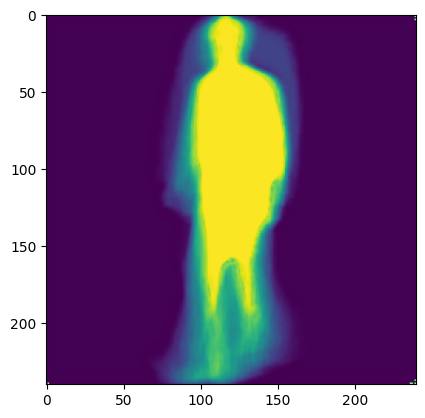

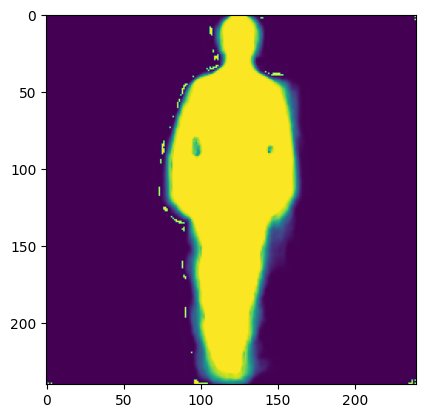

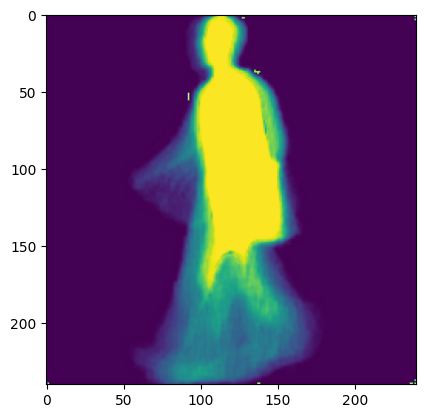

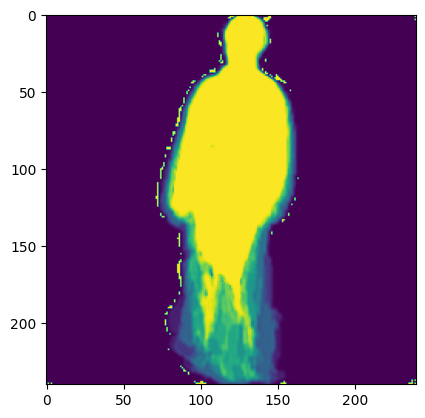

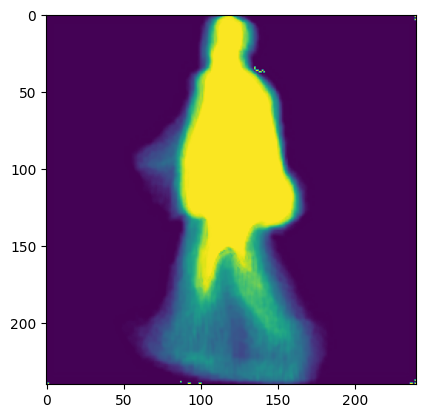

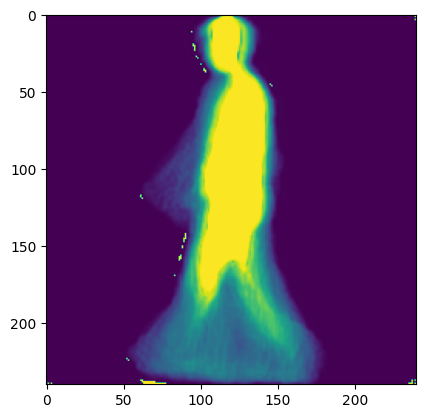

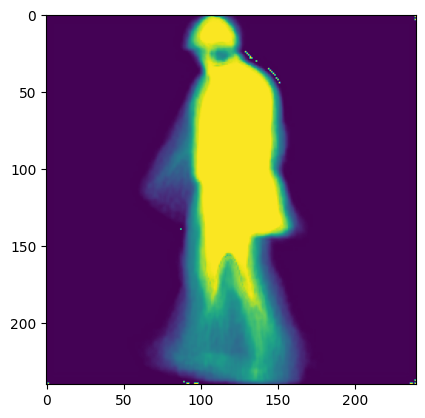

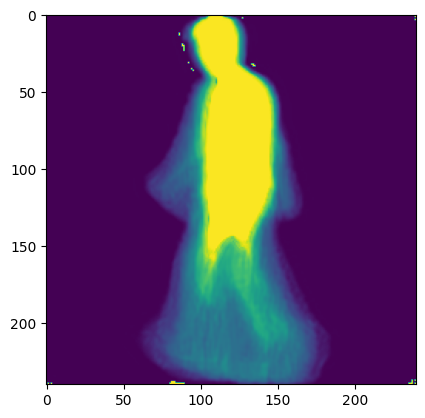

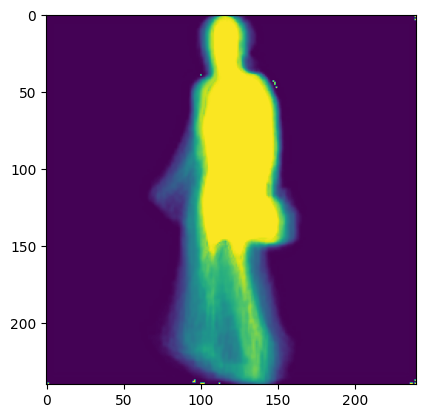

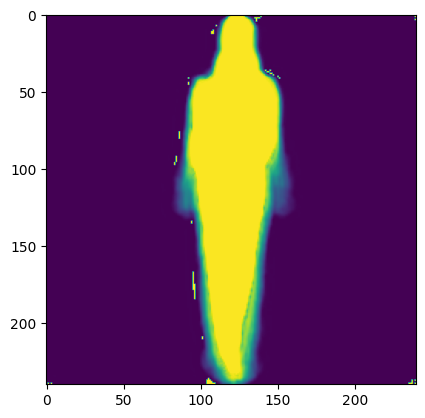

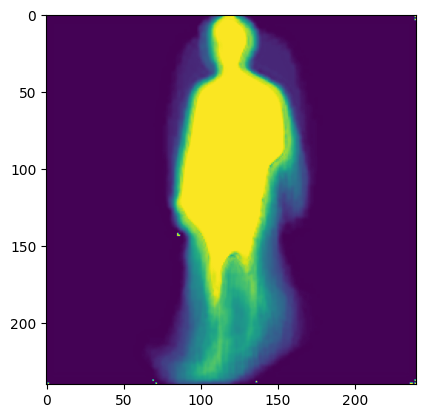

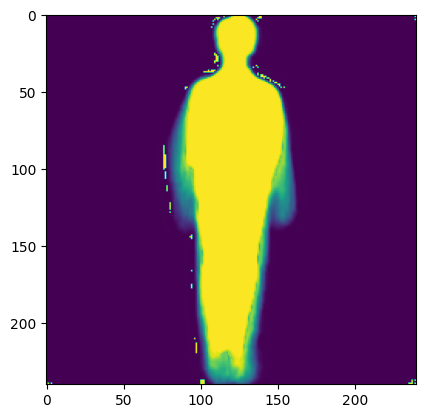

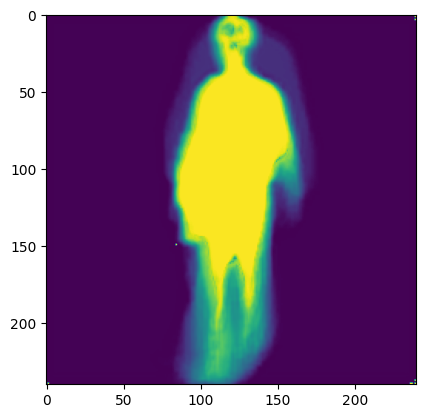

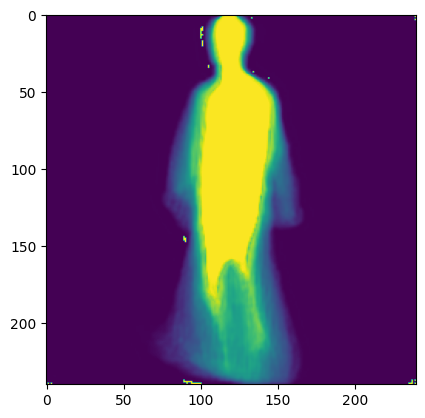

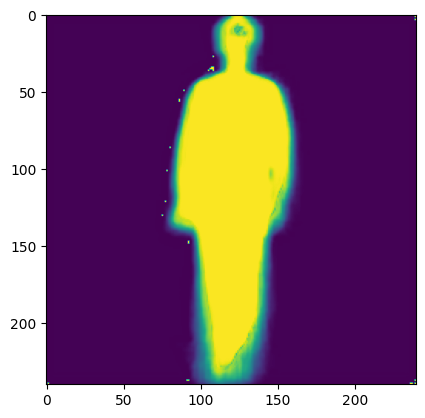

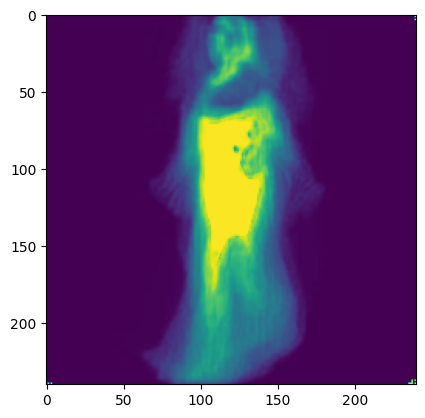

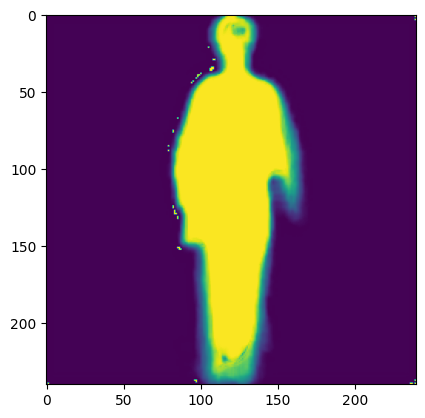

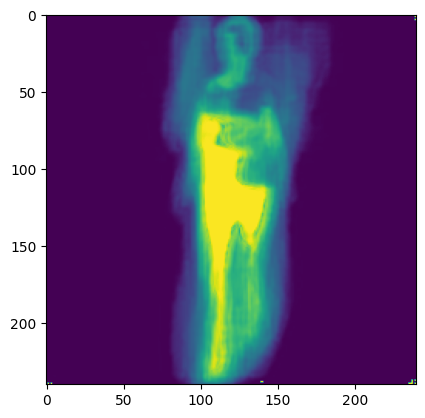

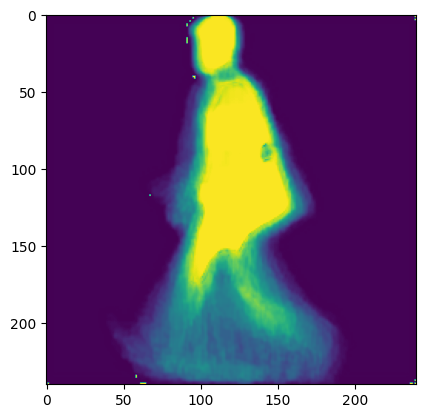

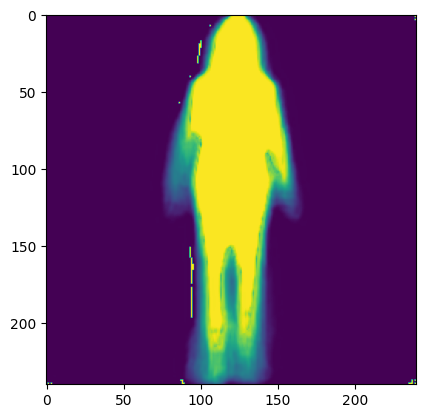

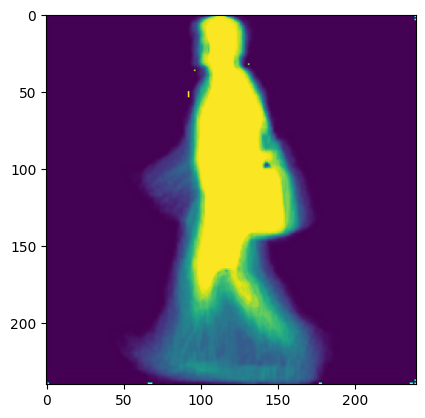

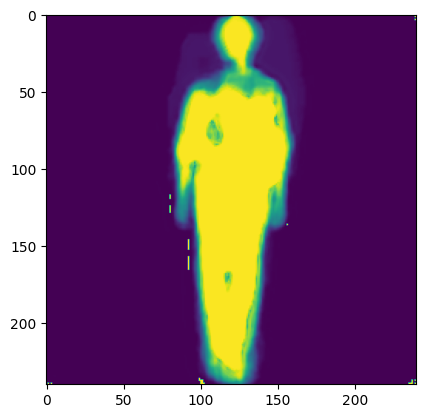

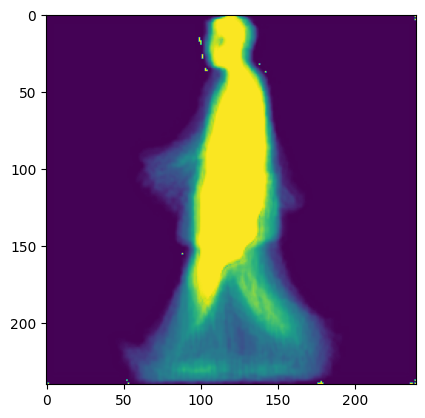

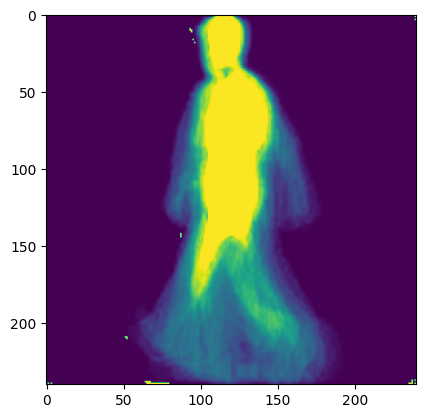

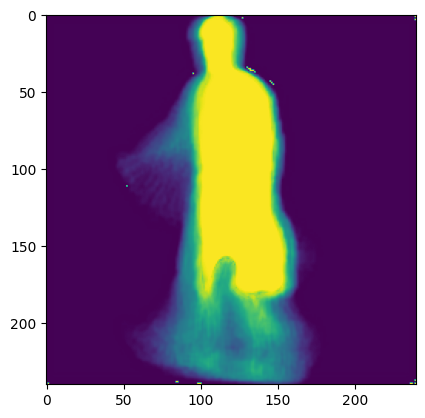

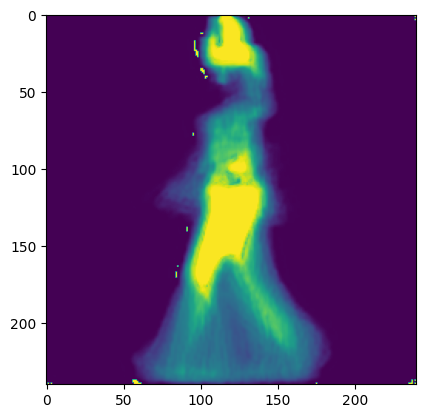

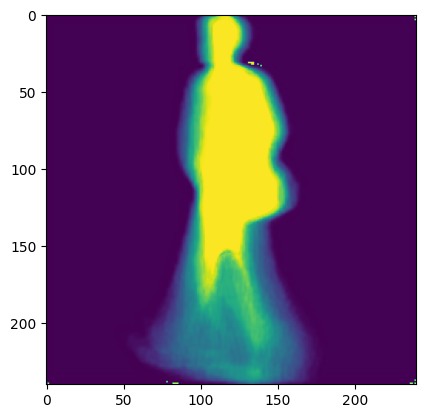

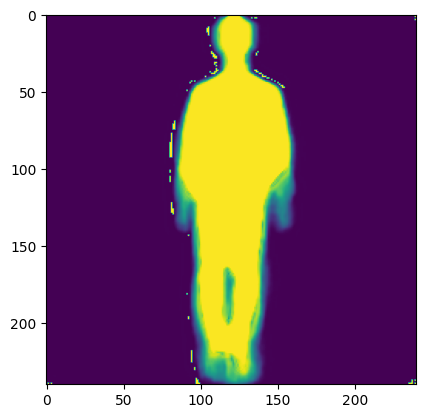

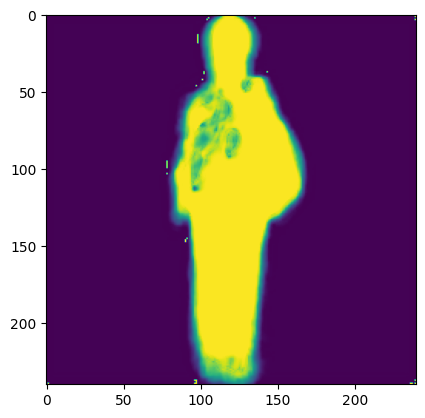

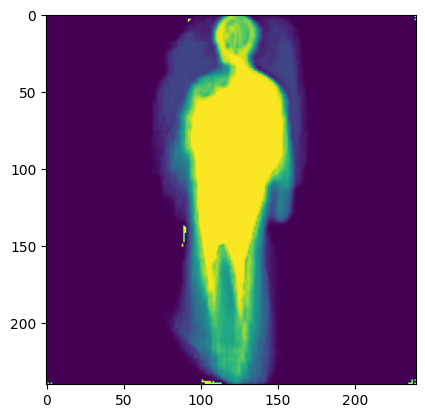

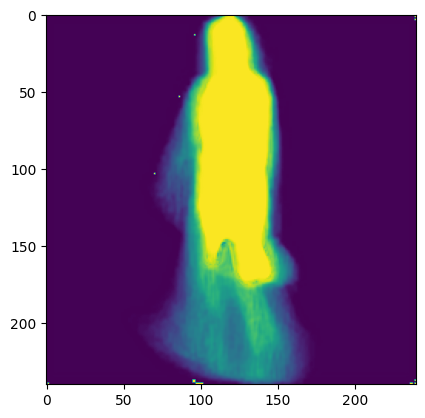

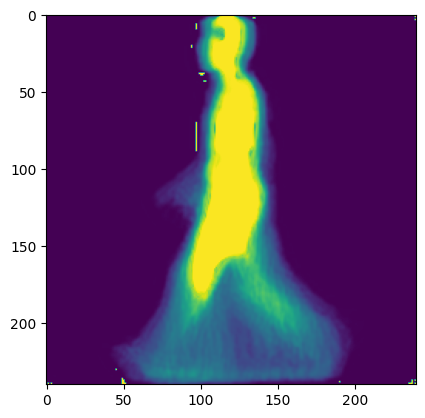

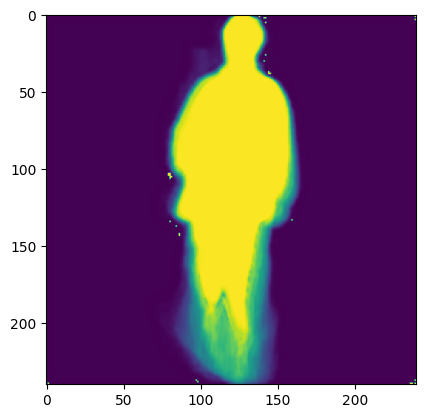

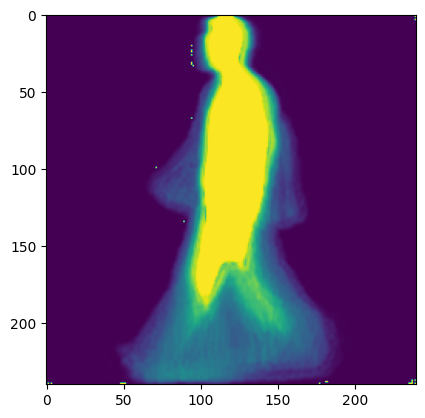

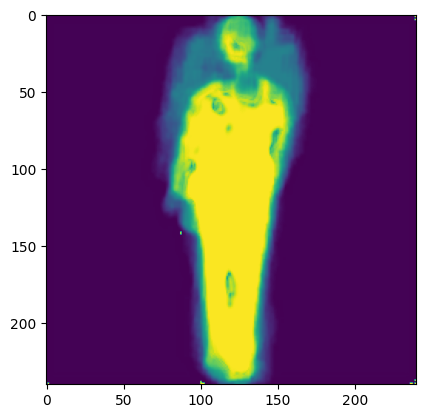

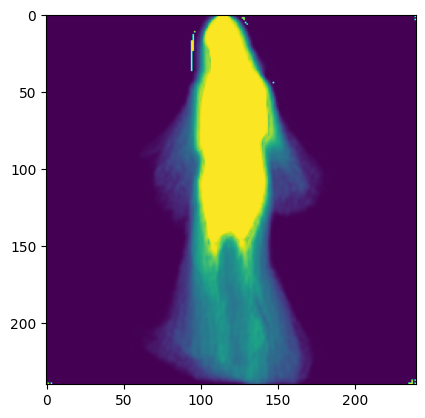

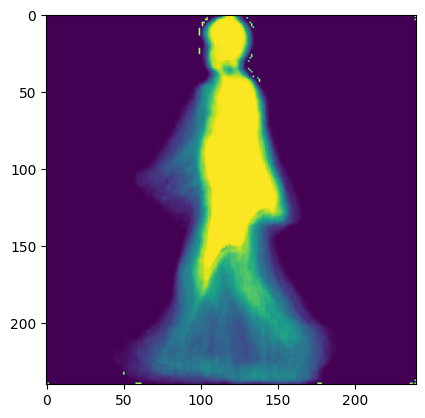

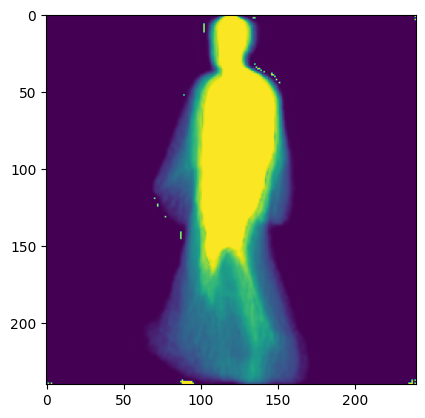

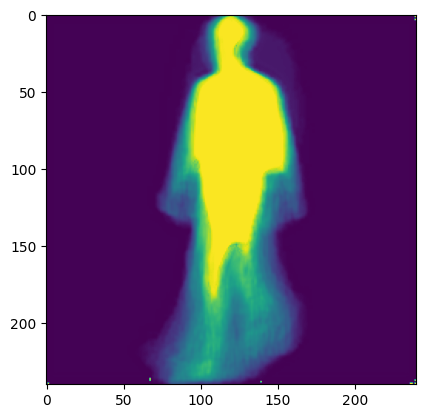

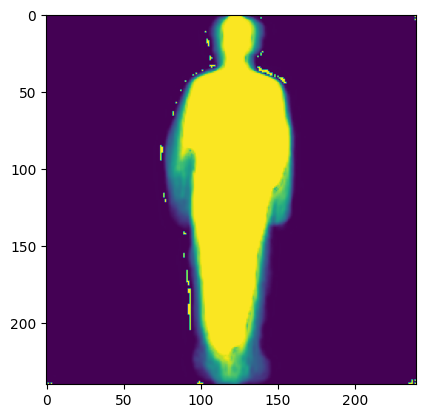

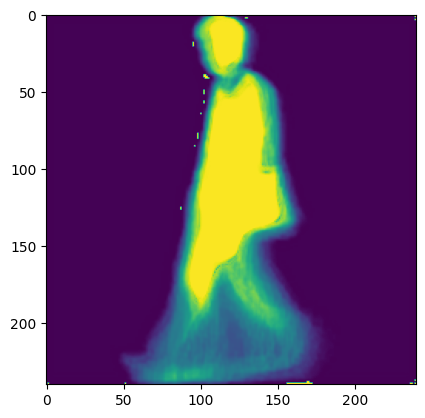

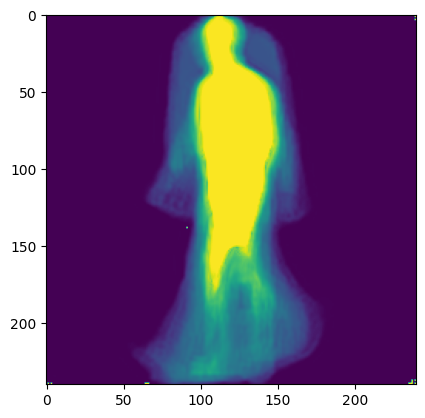

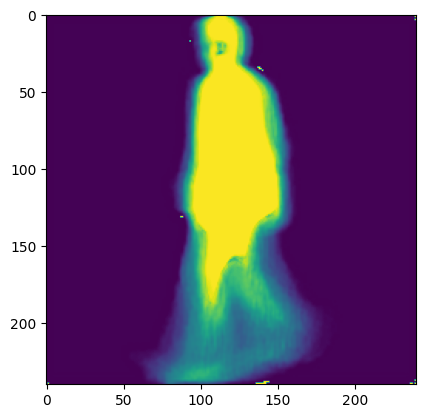

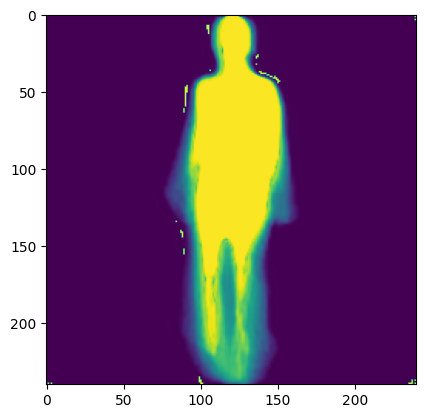

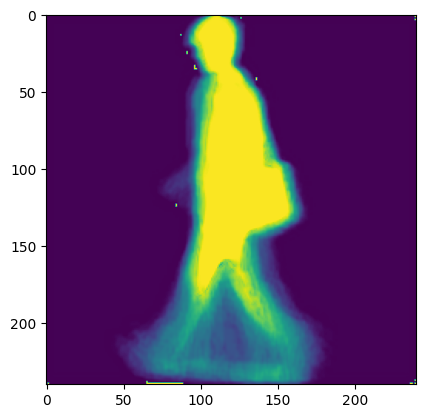

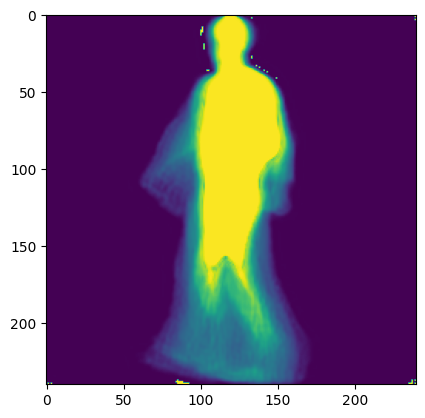

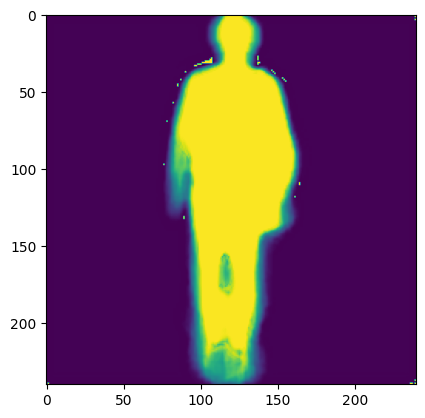

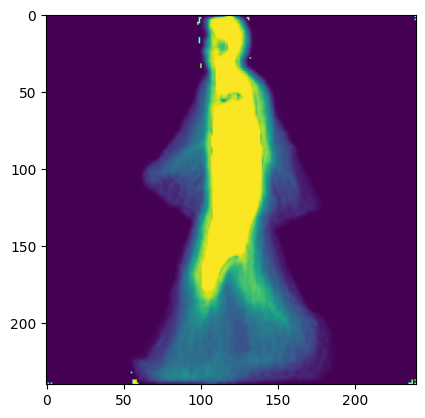

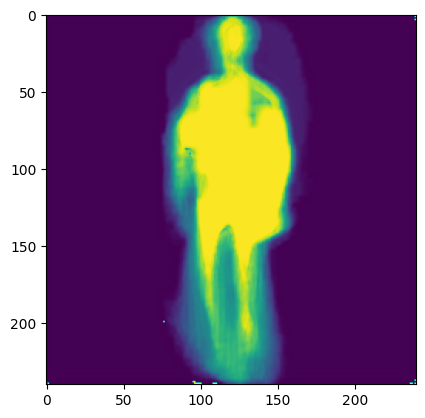

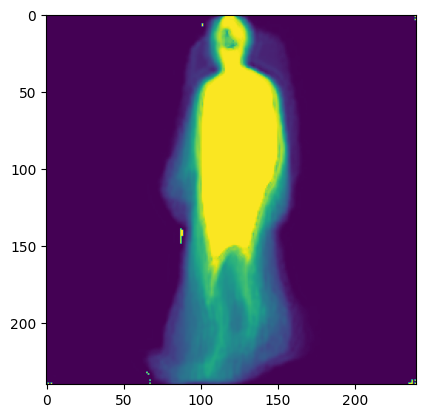

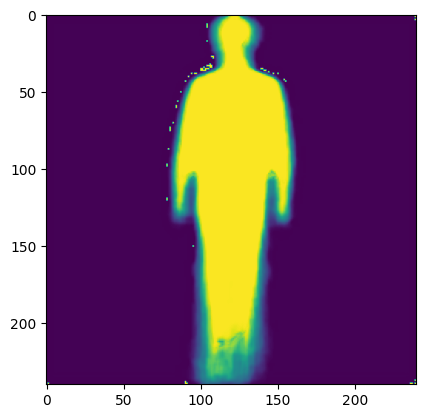

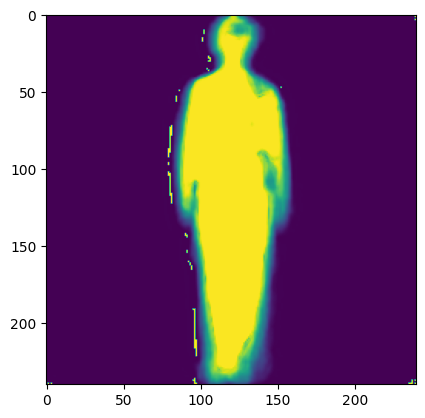

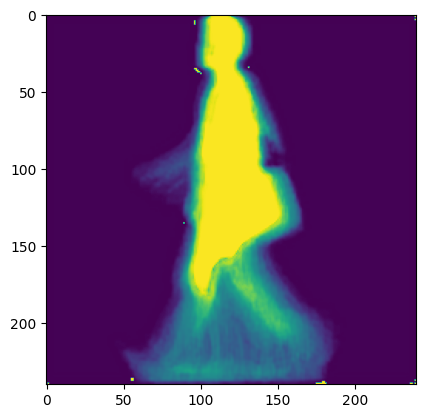

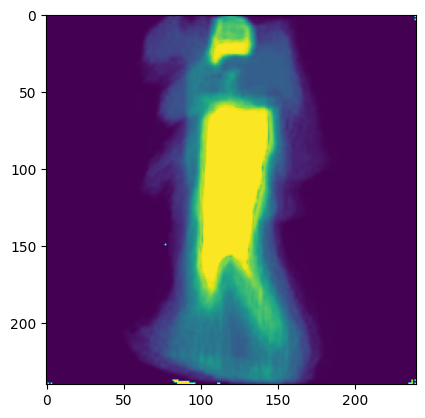

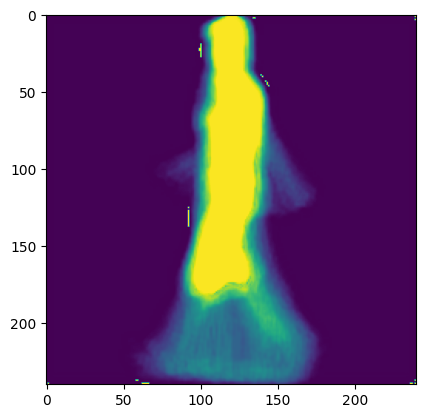

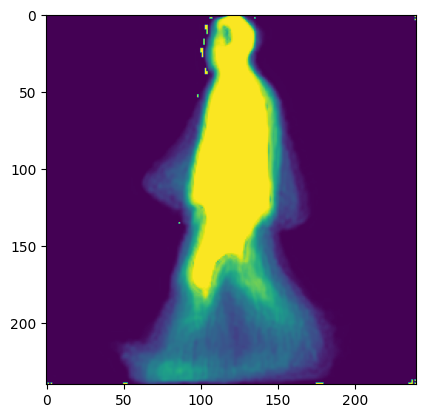

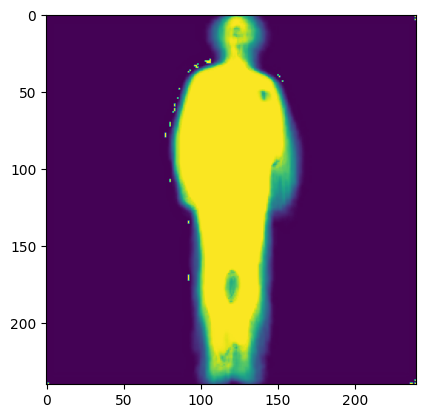

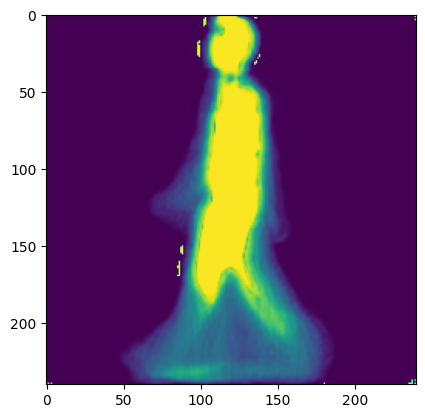

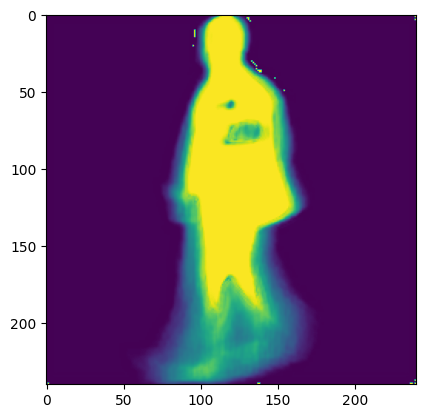

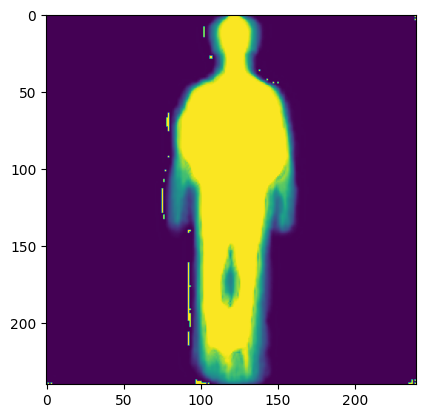

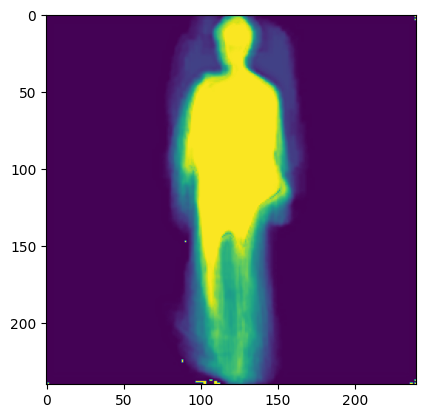

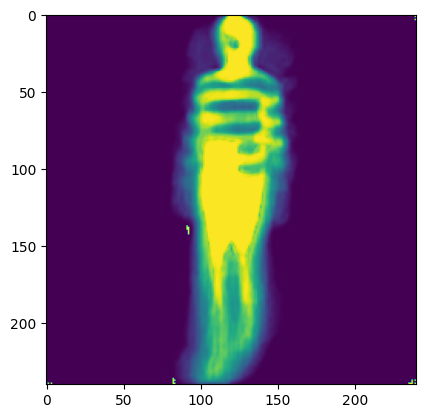

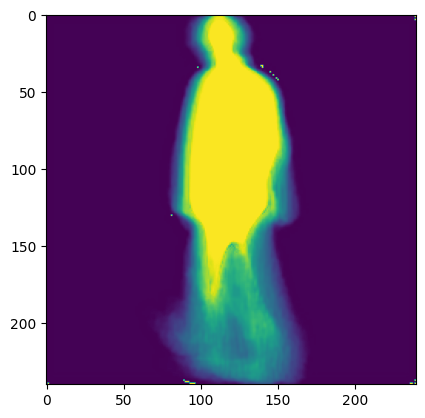

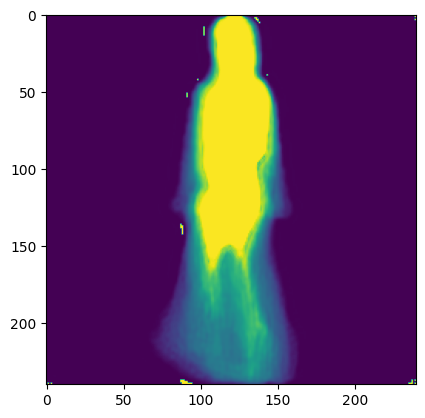

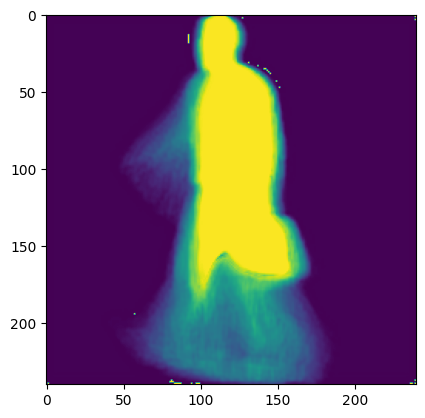

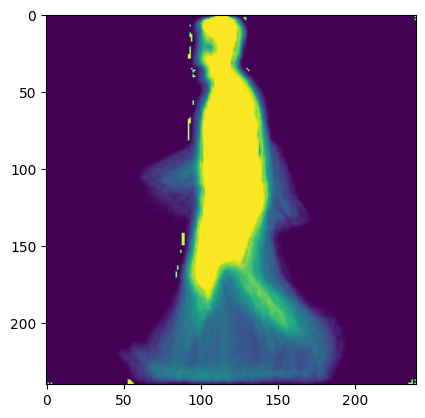

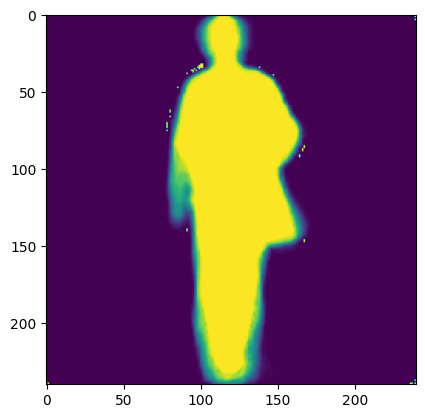

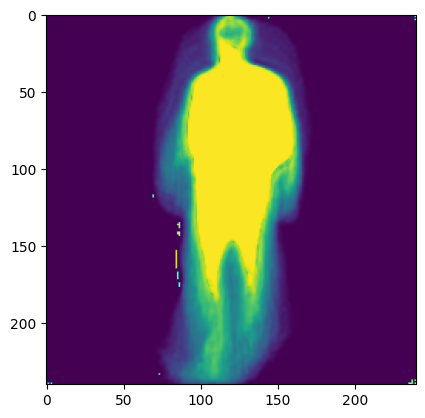

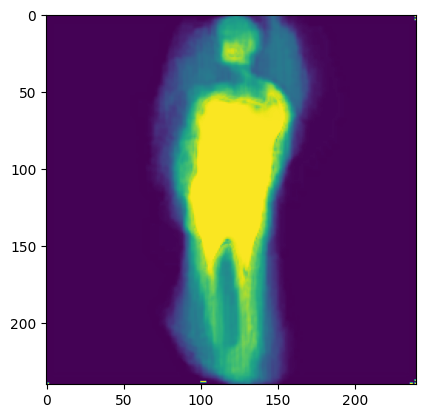

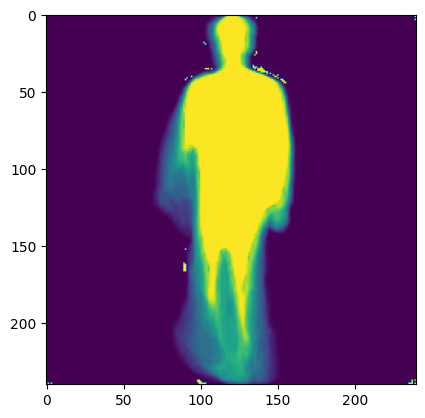

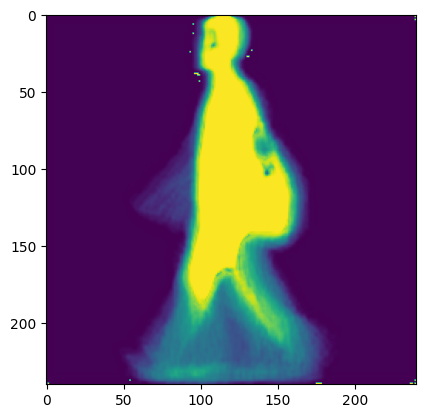

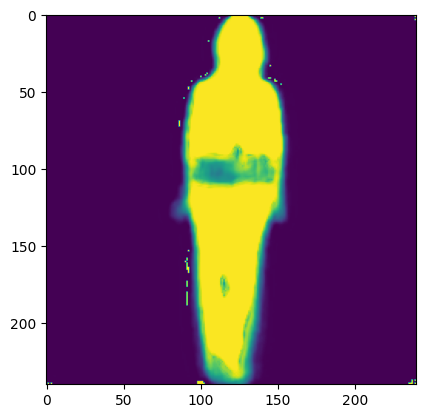

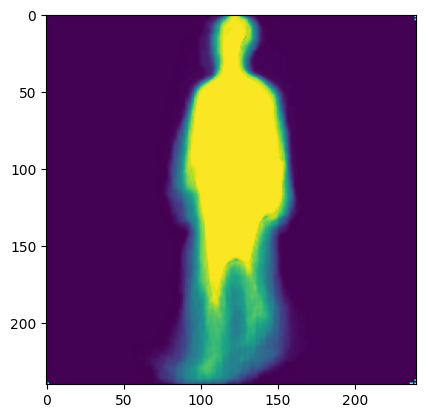

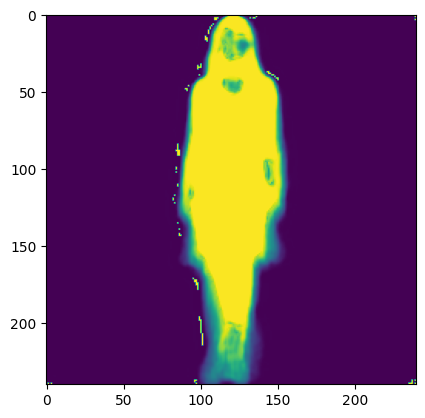

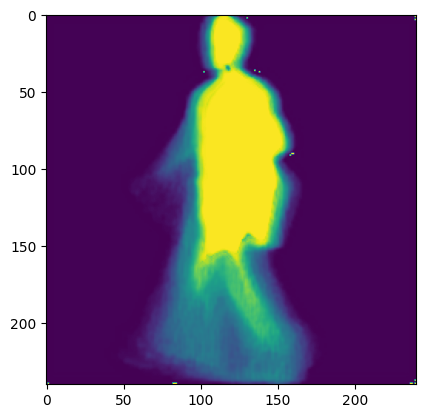

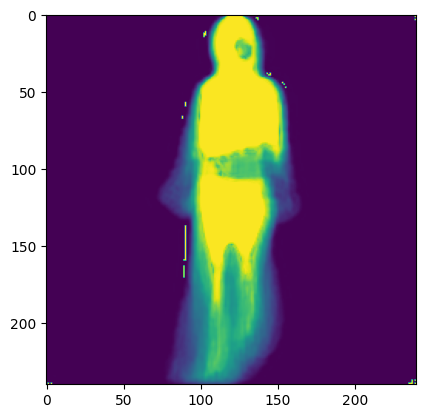

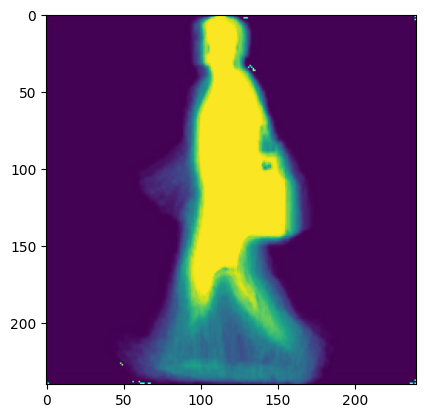

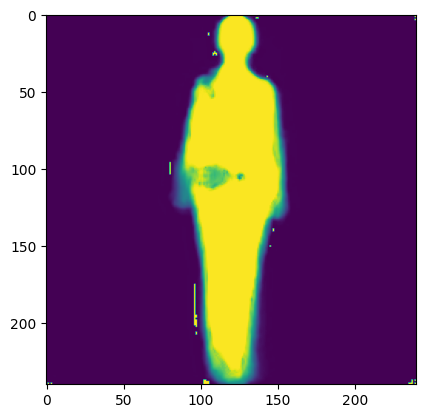

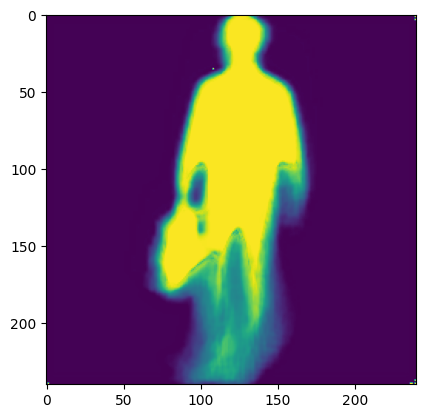

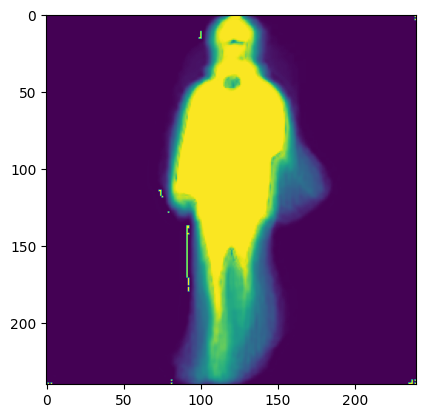

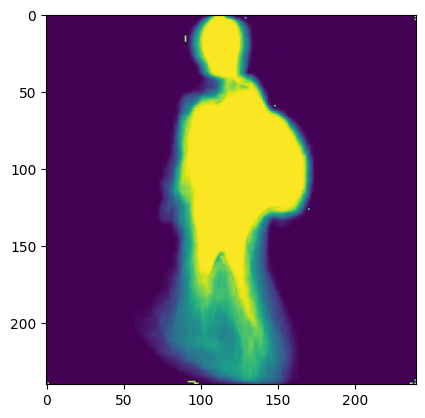

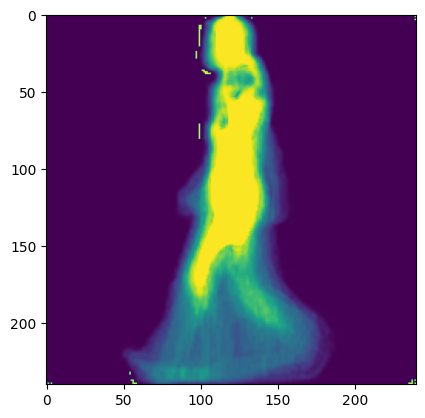

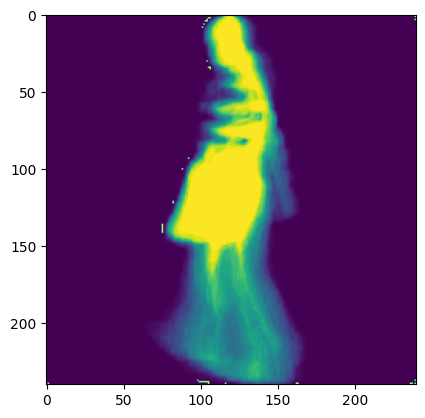

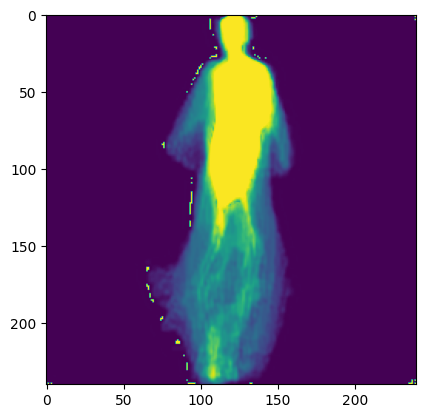

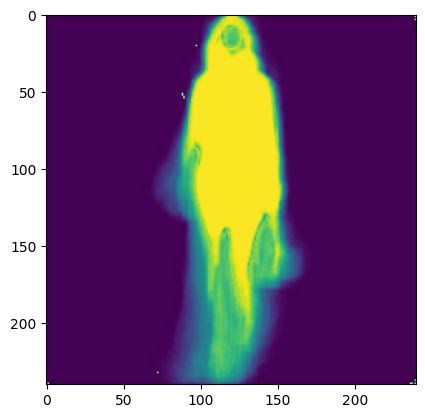

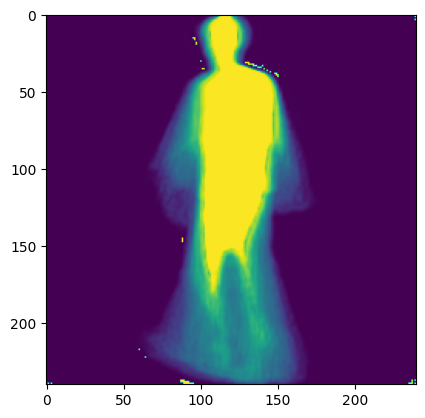

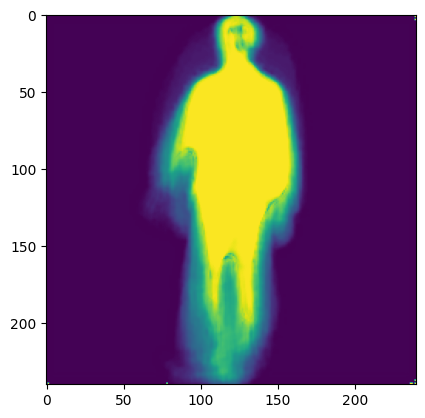

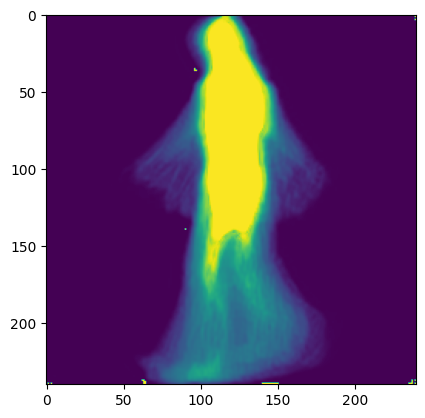

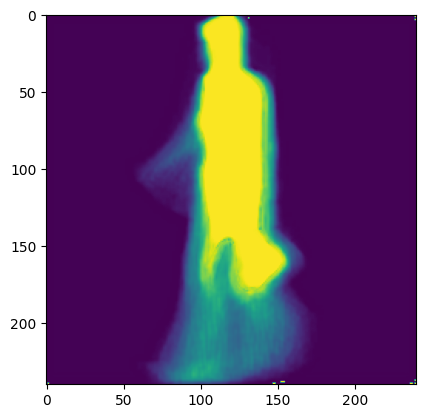

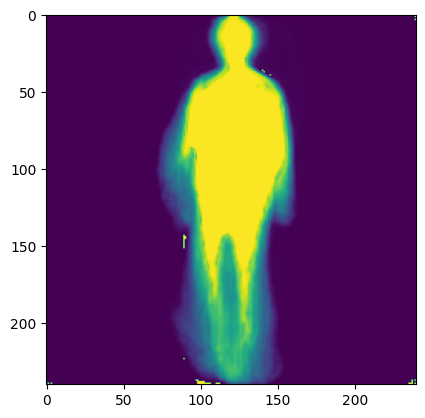

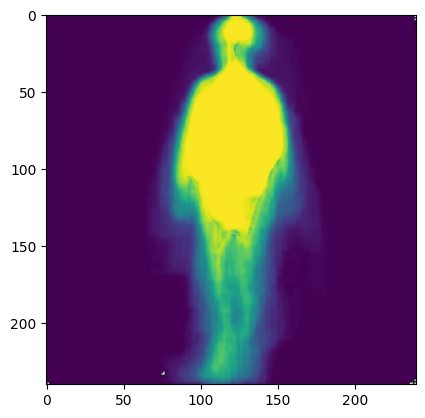

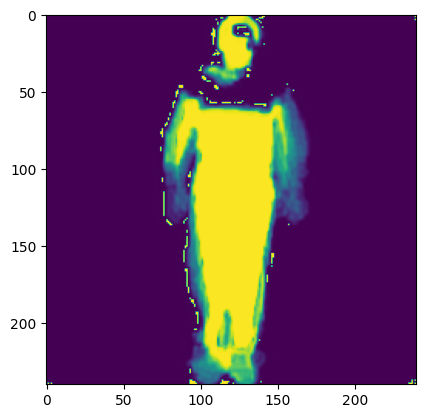

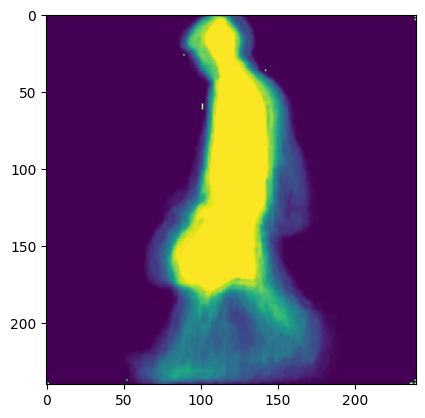

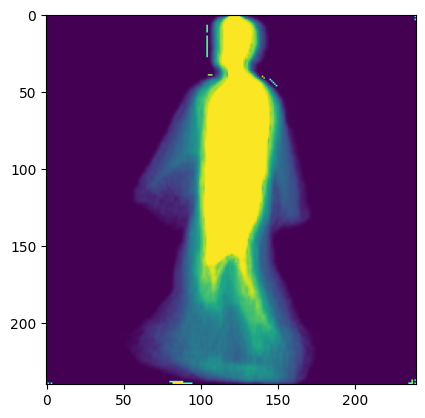

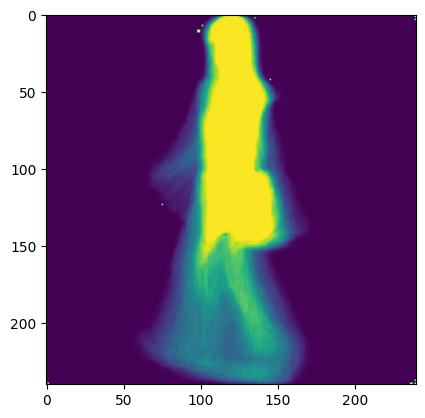

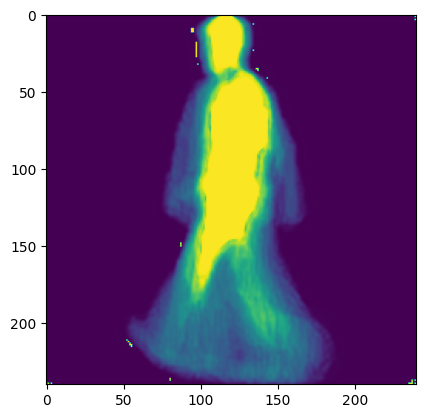

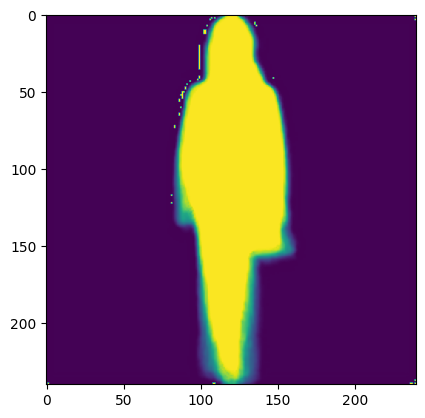

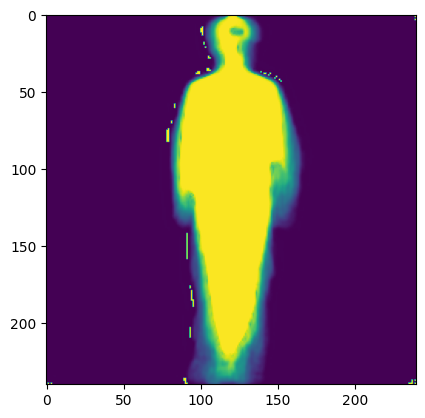

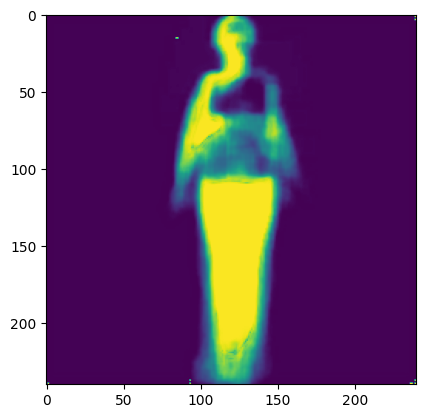

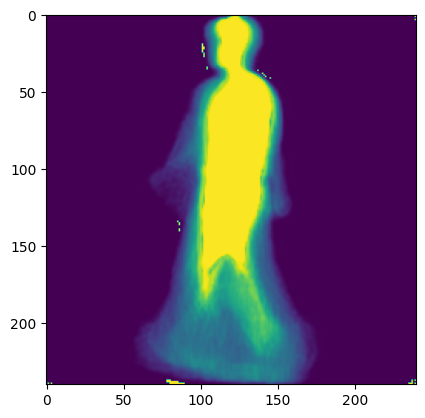

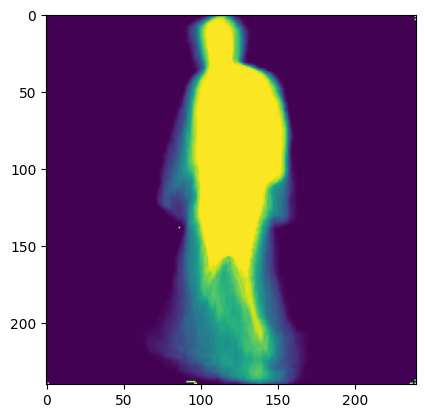

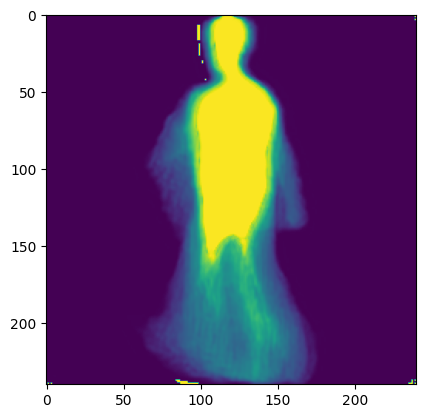

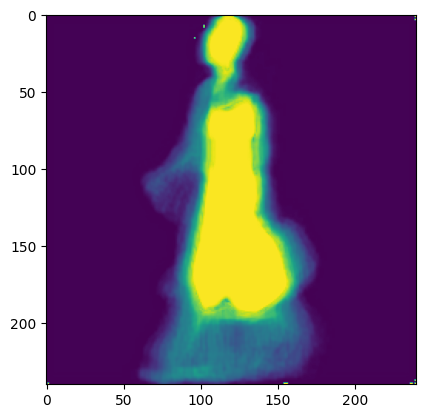

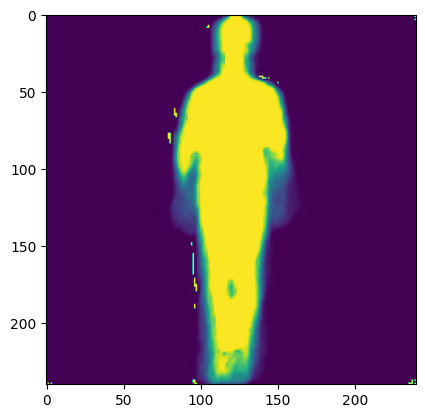

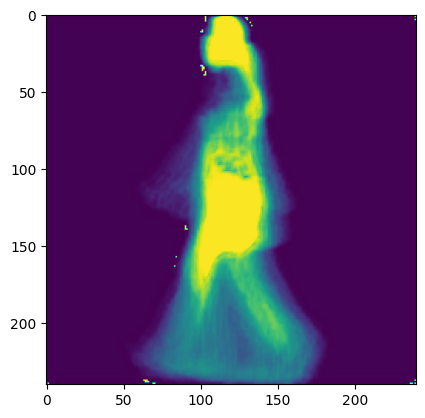

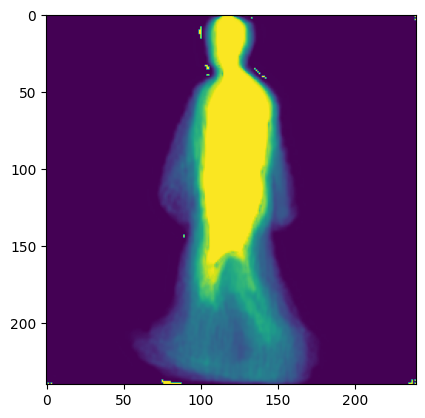

KeyboardInterrupt: 

In [34]:
from sklearn.metrics import accuracy_score, precision_score
from torchvision import transforms

# def validate_generator(generator, dataloader, device, threshold=0.5):
#     generator.eval()
    
#     all_predictions = []
#     all_targets = []

#     with torch.no_grad():
#         for bag, normal in tqdm(dataloader, leave=True):
#             bag, normal = bag.to(device), normal.to(device)

#             # Generate fake images
#             fake_normal = generator(bag)

#             # Apply threshold
#             fake_normal_binary = (fake_normal >= threshold).float()

#             # Convert to numpy arrays
#             fake_normal_binary_np = fake_normal_binary.cpu().numpy().flatten()
#             normal_np = normal.cpu().numpy().flatten()

#             # Store predictions and targets
#             all_predictions.extend(fake_normal_binary_np)
#             all_targets.extend(normal_np)

#     all_predictions = np.array(all_predictions)
#     all_targets = np.array(all_targets)

#     # Convert to binary values
#     all_predictions_binary = (all_predictions >= threshold).astype(int)
#     all_targets = all_targets.astype(int)  
    
#     # Print some information for debugging
#     print(f"all_predictions_binary: {all_predictions_binary}")
#     print(f"all_targets: {all_targets}")

#     accuracy = accuracy_score(all_targets, all_predictions_binary)
#     precision = precision_score(all_targets, all_predictions_binary)

#     return accuracy, precision

# # Assuming you have a validation dataset
validation_dataset = BagNormalDataset(rootbag='/kaggle/working/use/val/bg', rootnormal='/kaggle/working/use/val/nm', transforms=transform)
validation_loader = DataLoader(validation_dataset, batch_size=1, shuffle=False, num_workers=2)

# Use your trained generator
discoGAN.eval()
for idx,(bag,nm) in enumerate(validation_loader):
    bag=bag.to(device)
    nm=nm.to(device)
    fake_A,rec_A,fake_B,rec_B=discoGAN(bag,nm)
    displayImage(fake_A)
#     displayImage(fake_B)
#     displayImage(rec_A)
#     displayImage(rec_B)
    break


In [ ]:
# import shutil
# import os

# # Specify the path to the working directory
# working_directory = "/kaggle/working/saved_images"

# # Iterate over the files in the working directory and remove them
# for filename in os.listdir(working_directory):
#     file_path = os.path.join(working_directory, filename)
#     try:
#         if os.path.isfile(file_path) or os.path.islink(file_path):
#             os.unlink(file_path)
#         elif os.path.isdir(file_path):
#             shutil.rmtree(file_path)
#     except Exception as e:
#         print(f"Failed to delete {file_path}: {e}")
